In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import pprint
import category_encoders as ce
from sklearn import tree
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc, accuracy_score, roc_curve,\
                            roc_auc_score, confusion_matrix, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Dropout
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap 

RANDOM_STATE = 42 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)
le = preprocessing.LabelEncoder()
ord_enc = OrdinalEncoder()

# 1. Data Loading

In [153]:
#upload data
df = pd.read_csv('ctr_dataset_train.csv')
df = pd.DataFrame(df)
print('df.columns:',df.columns)
print('df.shape:',df.shape)

df.columns: Index(['op_id', 'timestamp', 'state', 'user_isp', 'app_id', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'device_height', 'device_width', 'resolution', 'clicked'], dtype='object')
df.shape: (2519056, 14)


In [154]:
df.describe(include='all')

op_id         timestamp    state      user_isp   app_id  app_cat banner_pos manufacturer device_model device_version  device_height   device_width resolution  clicked
count                                2519056    2519056.000000  2519056       2519024  2519056  2519056    2519056      1748114      1748210        2519056 2519056.000000 2519056.000000    2519056  2519056
unique                               2519056               nan       51          3316    14315       46          9          251         2256             16            nan            nan          1        2
top     3c6511e3-f6f2-4340-ba04-bce531873fa1               nan    Texas  T-Mobile USA  mc8dtso  unknown   top-left      Samsung   LM-X210(G)            7.0            nan            nan       True    False
freq                                       1               nan   327255        589526    43385   596348     304202       690996        88524         867074            nan            nan    2519056  2348498
mean                                     NaN 1569178025.952459      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN    1181.181645    1152.202143        NaN      NaN
std                                      NaN    2319487.007637      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN     519.304463     452.696444        NaN      NaN
min                                      NaN 1564423220.000000      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN      14.000000      14.000000        NaN      NaN
25%                                      NaN 1567305507.500000      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN     720.000000     720.000000        NaN      NaN
50%                                      NaN 1569316671.500000      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN    1080.000000    1080.000000        NaN      NaN
75%                                      NaN 1570937420.000000      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN    1280.000000    1280.000000        NaN      NaN
max                                      NaN 1573475093.000000      NaN           NaN      NaN      NaN        NaN          NaN          NaN            NaN    3120.000000    3120.000000        NaN      NaN

In [155]:
df.head()

op_id   timestamp       state                                       user_isp   app_id             app_cat banner_pos manufacturer device_model device_version  device_height  device_width  resolution  clicked
0  448ed944-b0a3-4f8e-9662-fb1202e2777b  1569445326  New Jersey                                  Comcast Cable  6rm7ag7  games - simulation  top-right      Samsung     SM-G925V          6.0.1            792          1408        True    False
1  3c501ca8-f771-4926-acce-d532f979b8b5  1566517297    Illinois                               Verizon Wireless  74193f6        games - card      right          NaN          NaN            7.0           2560          1440        True    False
2  db342130-0f34-4d43-a72c-3c1891eade24  1566375809  California                                   T-Mobile USA  6549c21      games - puzzle   top-left          NaN          NaN            7.0           1280           720        True    False
3  f080c21c-7791-44c5-9429-8eb411786fe7  1568568842  California                                   T-Mobile USA  dng7e8p             unknown       left      Samsung    SM-J700T1          7.1.1           1280           720        True    False
4  3ca5ac37-7beb-4d2e-b0a8-662a4f9eb614  1571357999     Georgia  North Carolina Research and Education Network  hp3monn  games - simulation   top-left     T-Mobile        5049W            7.0            720          1280        True     True

In [156]:
 df.isnull().sum()

op_id                  0
timestamp              0
state                  0
user_isp              32
app_id                 0
app_cat                0
banner_pos             0
manufacturer      770942
device_model      770846
device_version         0
device_height          0
device_width           0
resolution             0
clicked                0
dtype: int64

##### first low fruit conclusions:

##### op_id is unique per row - likely to remove

##### mostly categorical data - high cardinality need to reduce if possible


##### resolution has 1 unique value - will be removed

##### 3 columns with missing data. 2 with about 30% - need to find good way to fill. 1 with very little - can use most common category. 

# EDA

## Convert column types

In [157]:
df.dtypes

op_id             object
timestamp          int64
state             object
user_isp          object
app_id            object
app_cat           object
banner_pos        object
manufacturer      object
device_model      object
device_version    object
device_height      int64
device_width       int64
resolution          bool
clicked             bool
dtype: object

##### Converting to correct data types

##### Ordinal columns:

In [158]:
df['clicked'] =le.fit_transform(df['clicked'])
df['clicked'] = df['clicked'].astype('int32')

In [159]:
df.loc[df['device_version']=="P", 'device_version'] = '999'
df.loc[df['device_version']=="O", 'device_version'] = '999'

In [160]:
df['device_version'].unique()

array(['6.0.1', '7.0', '7.1.1', '8.0.0', '6.0', '8.1.0', '7.1.2', '9',
       '7.1', '3.5.4', '1.1.0', '8.0.1', '999', '8.0', '6.1'],
      dtype=object)

In [161]:
df['device_version'] =le.fit_transform(df['device_version'])
df['device_version'] = df['device_version'].astype('category')

##### Nominal columns:

In [162]:
#Nominal columns:
df['banner_pos'] = df['banner_pos'].astype('category')
df['state'] = df['state'].astype('category')
#convert to datetime(late split to weekend, holidays, hours of the day etc.)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')#Should be 2 months we see 4

##### which columns to remove

In [163]:
df.drop(['resolution'], axis=1, inplace=True)#removing this column as it has one unique value therfor has 0 cardinality and will not provide any information
df.drop(['op_id'], axis=1, inplace=True)#removing this as is had too high cardinality and provides no additional informatio - one per row
#df.drop(['app_id'], axis=1, inplace=True)

## Missing Data

##### Answer to question: We removed Na values from 3 columns. in User_isp we had only 32 missing - added the most common category to them

##### for Manufacturer we created a new collumn - 'combined'.

##### Combined is a combination of hight width and version per row. we assigned the missing values where they had one manufacturer per combination. filling over 75K rows acduratly.The rest we filled with 'unknown' category.

In [164]:
 df.isnull().sum()

timestamp              0
state                  0
user_isp              32
app_id                 0
app_cat                0
banner_pos             0
manufacturer      770942
device_model      770846
device_version         0
device_height          0
device_width           0
clicked                0
dtype: int64

##### 30% of the values are NA in 2 columns

### Quick NA solution for flow flush - need better solution!!!!

In [165]:
def MissingData(df):
    df['user_isp'].fillna(df['user_isp'].value_counts().index[0], inplace=True)#Fill na in user isp with most common value - only ~30 missing. 
    df['device_model'].fillna('Unknown', inplace=True)
    df['manufacturer'].fillna('Unknown', inplace=True)
    return df

##### Filling NA for Manufacturer based on the assumption that we will have unique manufacturer per combination below

In [166]:
df["combined"] = df["device_version"].astype(str).str.cat(df[['device_height','device_width']].astype(str), sep="_")

In [167]:
#find the combination that will provide 100% proof for a manufacturer. 
countman = df.groupby('combined')['manufacturer'].nunique()
c = countman[countman ==1]
df_c  = pd.DataFrame(c.keys())
df_c.head()

combined
0   0_1024_600
1  0_1920_1080
2  10_1024_768
3  10_1038_540
4  10_1047_540

In [168]:
#df_c.merge(df[['combined','manufacturer']], left_on='combined' , how= 'inner')
df_c = pd.merge(df_c, df[['combined','manufacturer']], on='combined' ,how='left')
df_c = df_c.drop_duplicates(subset=['combined','manufacturer'], keep='last')
df_c = df_c[df_c['manufacturer'].isnull()==False]
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 1 to 157303
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   combined      659 non-null    object
 1   manufacturer  659 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


In [169]:
#count the number of NA rows in DF that are in df_c
df[['manufacturer','combined']][df['manufacturer'].isnull()][df['combined'].isin(df_c['combined'])].count()

manufacturer        0
combined        75091
dtype: int64

##### 75091 missing value can be accuratly populate!

In [170]:
#Merge, Drop redundent column , change name back
df = pd.merge(df, df_c, on='combined' ,how='left')
df['manufacturer_x'] = np.where(df['manufacturer_x'].isnull(), df['manufacturer_y'], df['manufacturer_x'])
df['manufacturer_x'][df['manufacturer_x'].isnull()==True].count()
df.drop(['manufacturer_y'], axis=1, inplace=True)
df=df.rename(columns={"manufacturer_x": "manufacturer"})
df.head()

timestamp       state                                       user_isp   app_id             app_cat banner_pos manufacturer device_model device_version  device_height  device_width  clicked     combined
0 2019-09-25 21:02:06  New Jersey                                  Comcast Cable  6rm7ag7  games - simulation  top-right      Samsung     SM-G925V              3            792          1408        0   3_792_1408
1 2019-08-22 23:41:37    Illinois                               Verizon Wireless  74193f6        games - card      right          NaN          NaN              5           2560          1440        0  5_2560_1440
2 2019-08-21 08:23:29  California                                   T-Mobile USA  6549c21      games - puzzle   top-left          NaN          NaN              5           1280           720        0   5_1280_720
3 2019-09-15 17:34:02  California                                   T-Mobile USA  dng7e8p             unknown       left      Samsung    SM-J700T1              7           1280           720        0   7_1280_720
4 2019-10-18 00:19:59     Georgia  North Carolina Research and Education Network  hp3monn  games - simulation   top-left     T-Mobile        5049W              5            720          1280        1   5_720_1280

In [171]:
 df.isnull().sum()

timestamp              0
state                  0
user_isp              32
app_id                 0
app_cat                0
banner_pos             0
manufacturer      695851
device_model      770846
device_version         0
device_height          0
device_width           0
clicked                0
combined               0
dtype: int64

In [172]:
#fill the rest with the category 'Unknown'
df = MissingData(df)

## Reducing Cardinality

##### manufacturer - reduce cardinality

number of rows: 11295
% of rows to be combined: 0.4483822511289944
% of categories to be combined: 90.07936507936508


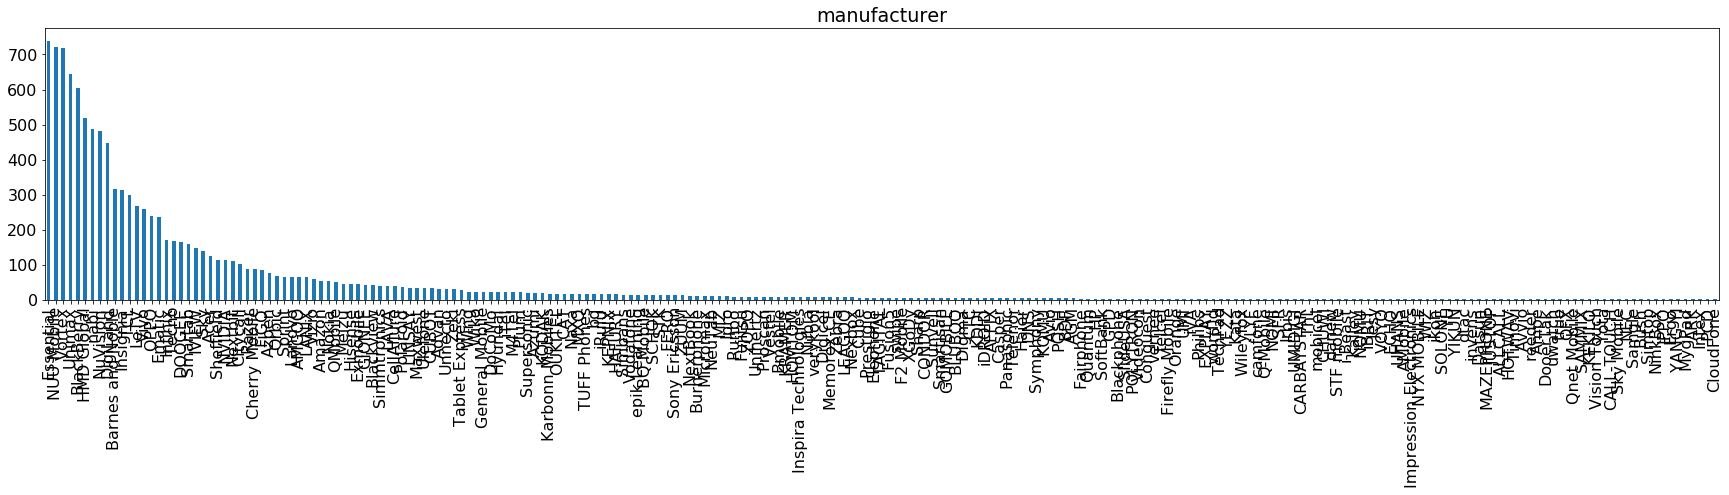

In [173]:
plt.rcParams['font.size'] = '16'
x = df['manufacturer'][df['manufacturer'].notna()].value_counts().sort_values(ascending=False)
x = x[df['manufacturer'][df['manufacturer'].notna()].value_counts()<1000]
x.plot.bar(title='manufacturer',figsize=(30,5))
print('number of rows:',x.sum())
print('% of rows to be combined:',100*(x.sum()/len(df['manufacturer'])))
print('% of categories to be combined:',100*(len(x.keys())/len(df['manufacturer'].unique())))

##### ~90% of the categories are responsible for ~0.4% of the data -> we will combine them all to one category, 'LongTail'

In [174]:
#get all the values that have a small number of uses in order to coombine
x = df['manufacturer'][df['manufacturer'].notna()==True].value_counts().sort_values(ascending=False)
x = x[df['manufacturer'][df['manufacturer'].notna()==True].value_counts()<1000]
#locate the values in the combine list and change them to longTail
df.loc[df['manufacturer'].isin(x.keys()) , "manufacturer"] = 'LongTail'
df['manufacturer'][df['manufacturer'] =='LongTail']
df['manufacturer'] = df['manufacturer'].astype('category')

##### Reduced from 251 categories to 25 + 1 unknown!!!

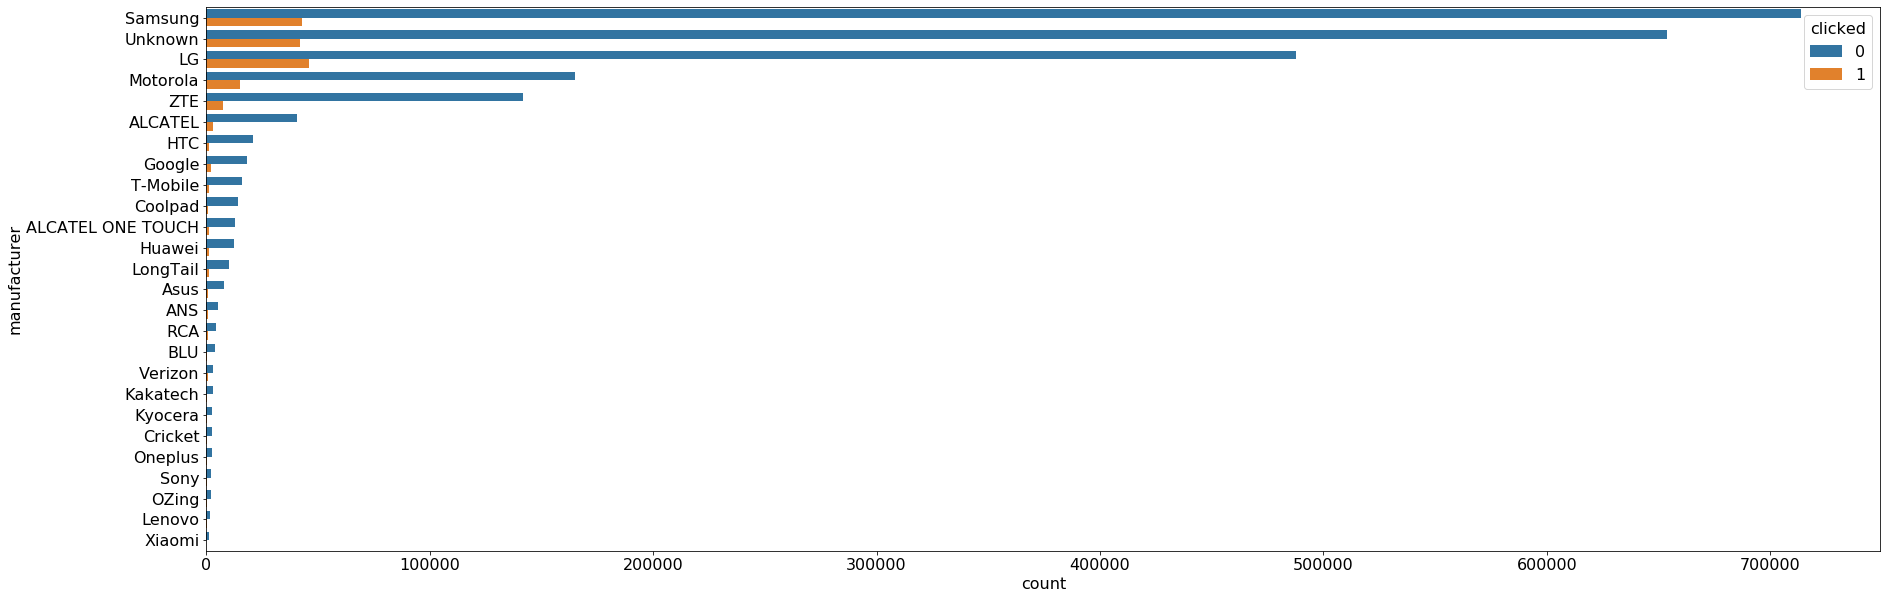

In [175]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(y= df['manufacturer'], hue=df['clicked'], data=df,order = df['manufacturer'].value_counts().index)

<Figure size 2160x720 with 0 Axes>

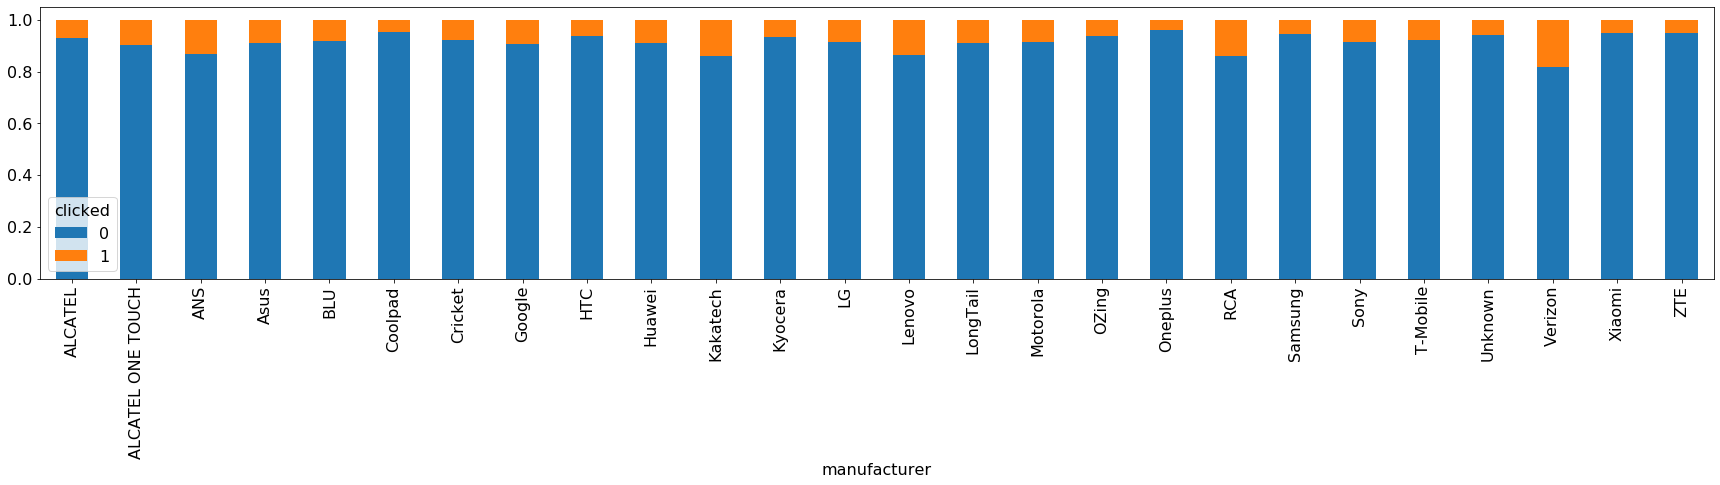

In [176]:
plt.figure(figsize=(30, 10))
df_pct = (df.groupby(['manufacturer','clicked'])['manufacturer'].count()/df.groupby(['manufacturer'])['manufacturer'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

##### App Cat - reduce cardinality

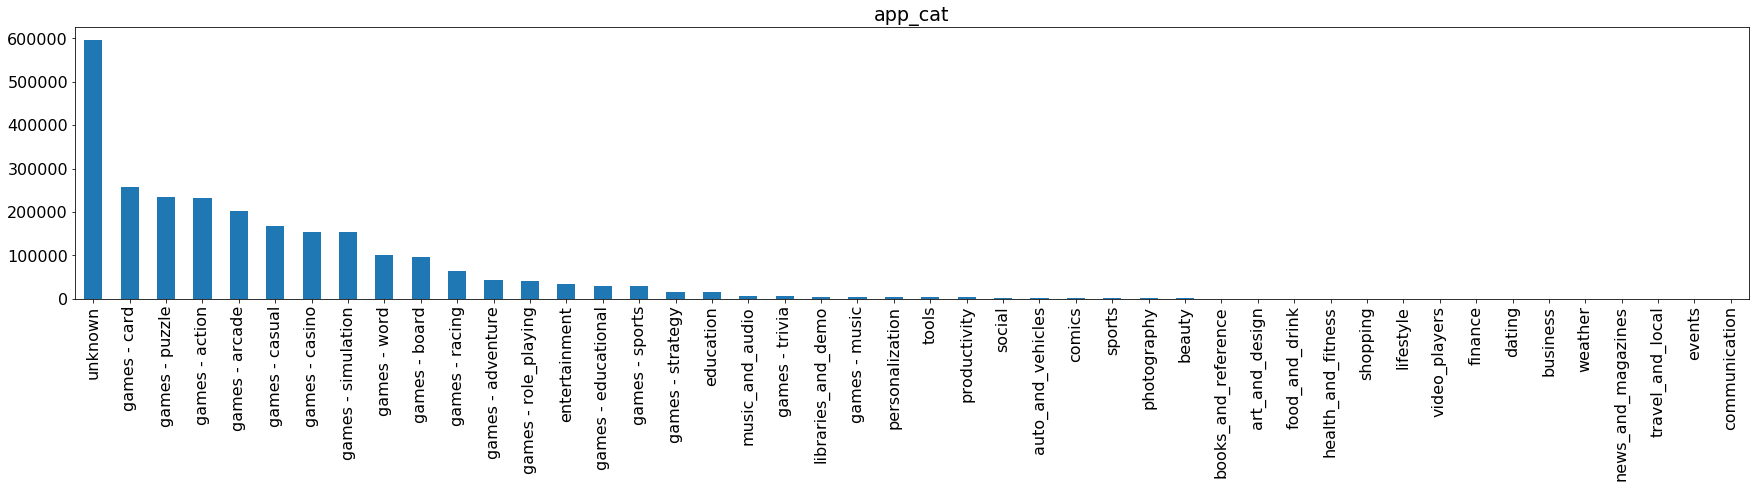

In [177]:
plt.rcParams['font.size'] = '16'
x = df['app_cat'][df['app_cat'].notna()].value_counts().sort_values(ascending=False)
x.plot.bar(title='app_cat',figsize=(30,5))

<Figure size 2160x720 with 0 Axes>

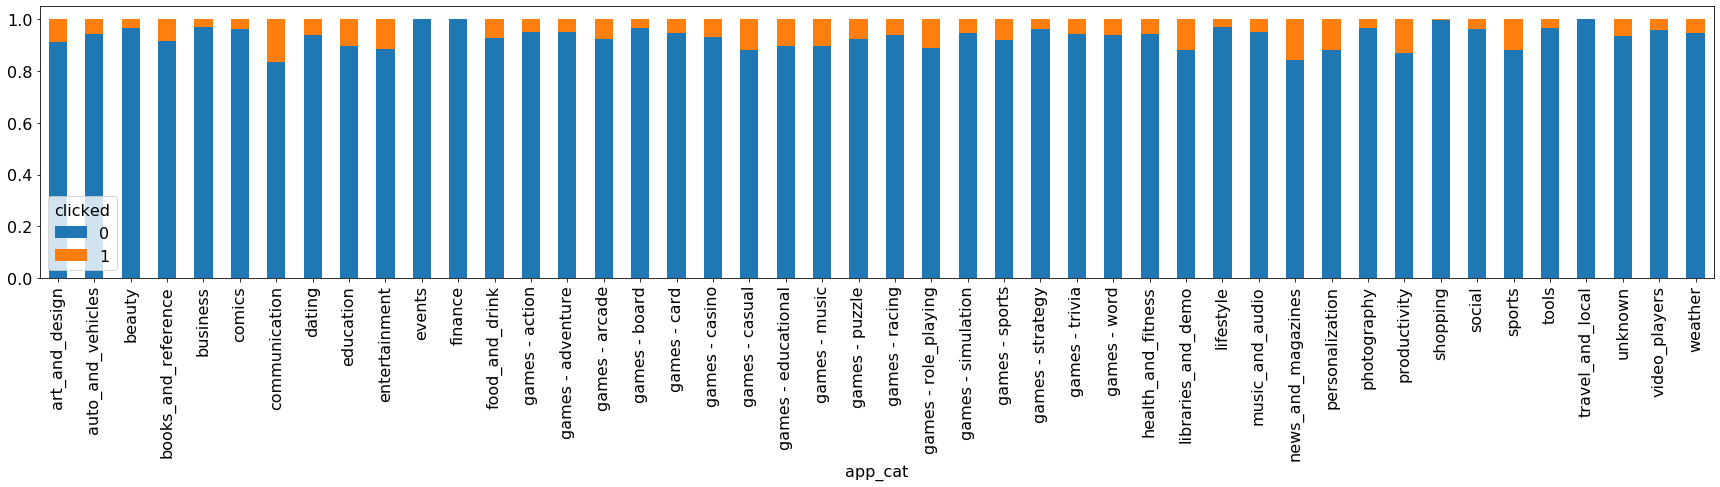

In [178]:
plt.figure(figsize=(30, 10))
df_pct = (df.groupby(['app_cat','clicked'])['app_cat'].count()/df.groupby(['app_cat'])['app_cat'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

In [179]:
df['app_cat'][df['app_cat']=='news_and_magazines'].count()

45

number of rows: 13030
% of rows to be combined: 0.5172572582745282
% of categories to be combined: 45.65217391304348


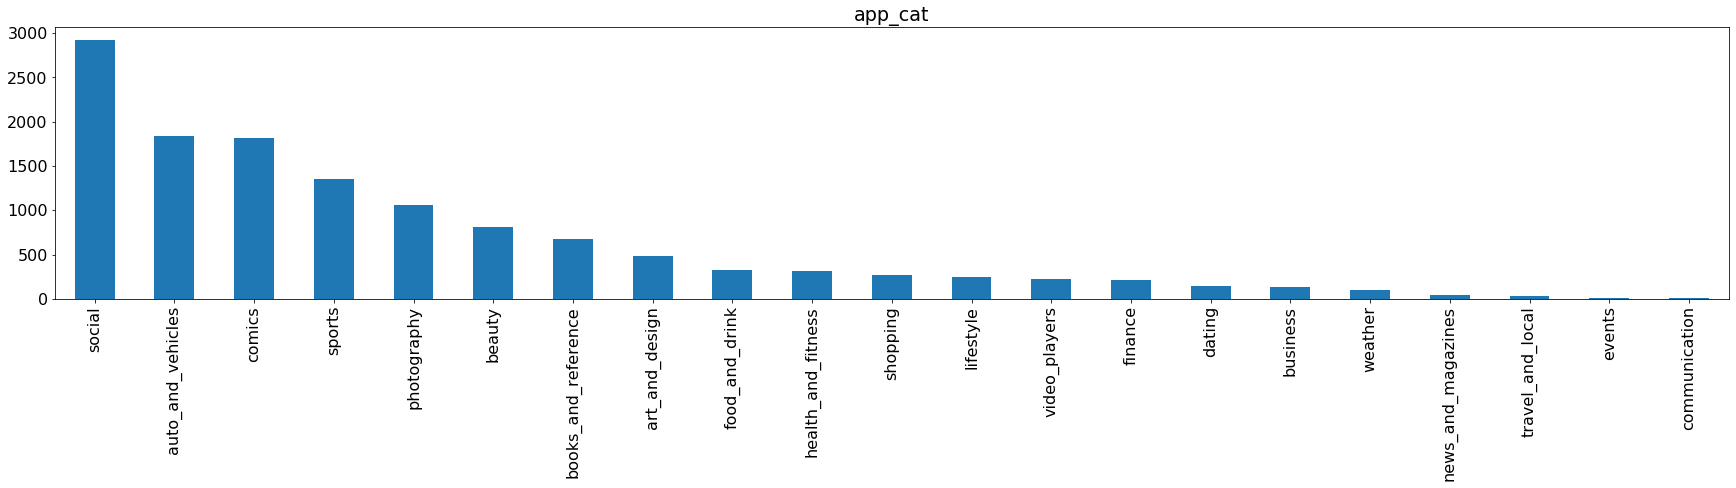

In [180]:
plt.rcParams['font.size'] = '16'
x = df['app_cat'][df['app_cat'].notna()].value_counts().sort_values(ascending=False)
x = x[df['app_cat'][df['app_cat'].notna()].value_counts()<3000]
x.plot.bar(title='app_cat',figsize=(30,5))
print('number of rows:',x.sum())
print('% of rows to be combined:',100*(x.sum()/len(df['app_cat'])))
print('% of categories to be combined:',100*(len(x.keys())/len(df['app_cat'].unique())))

##### ~45% of the categories are responsible for ~0.5% of the data -> we will combine them all to one category, 'LongTail'

In [181]:
#locate the values in the combine list and change them to longTail
df.loc[df['app_cat'].isin(x.keys()) , "app_cat"] = 'LongTail'
df['app_cat'][df['app_cat'] =='LongTail']
df['app_cat'] = df['app_cat'].astype('category')

<Figure size 2160x720 with 0 Axes>

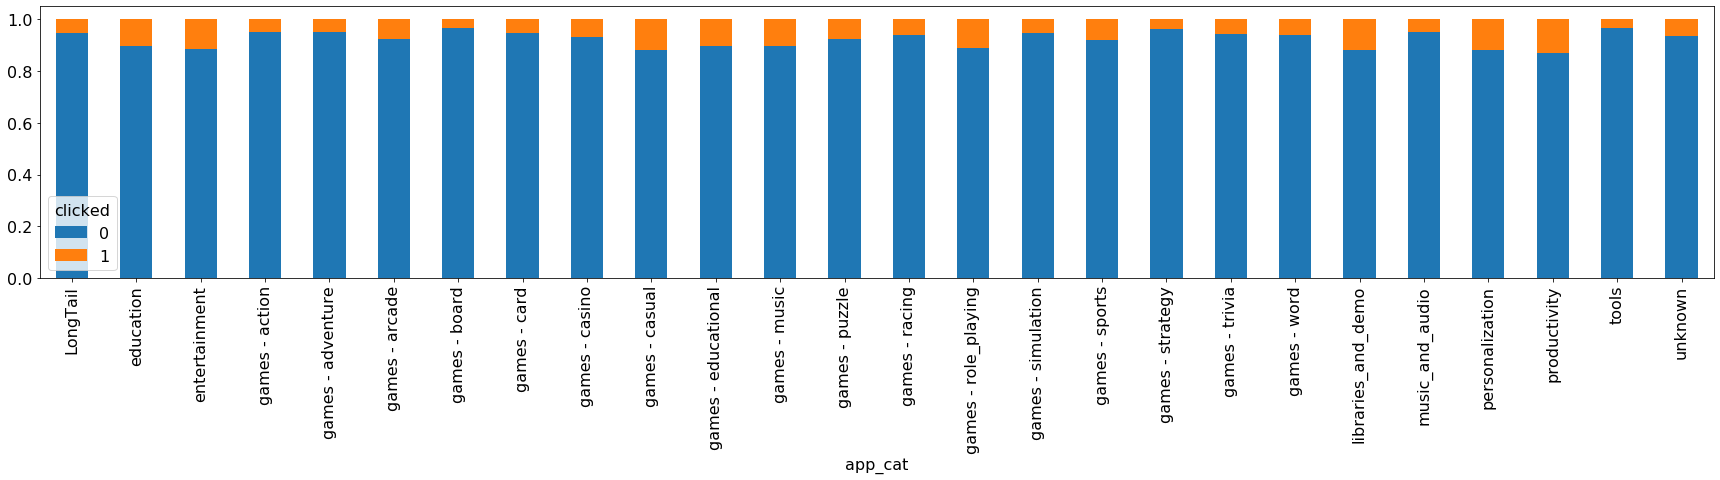

In [182]:
plt.figure(figsize=(30, 10))
df_pct = (df.groupby(['app_cat','clicked'])['app_cat'].count()/df.groupby(['app_cat'])['app_cat'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

##### reduced to 26 categories

##### user_isp - reduce cardinality¶

number of rows: 182723
% of rows to be combined: 7.253629931212327
% of categories to be combined: 99.36670687575392


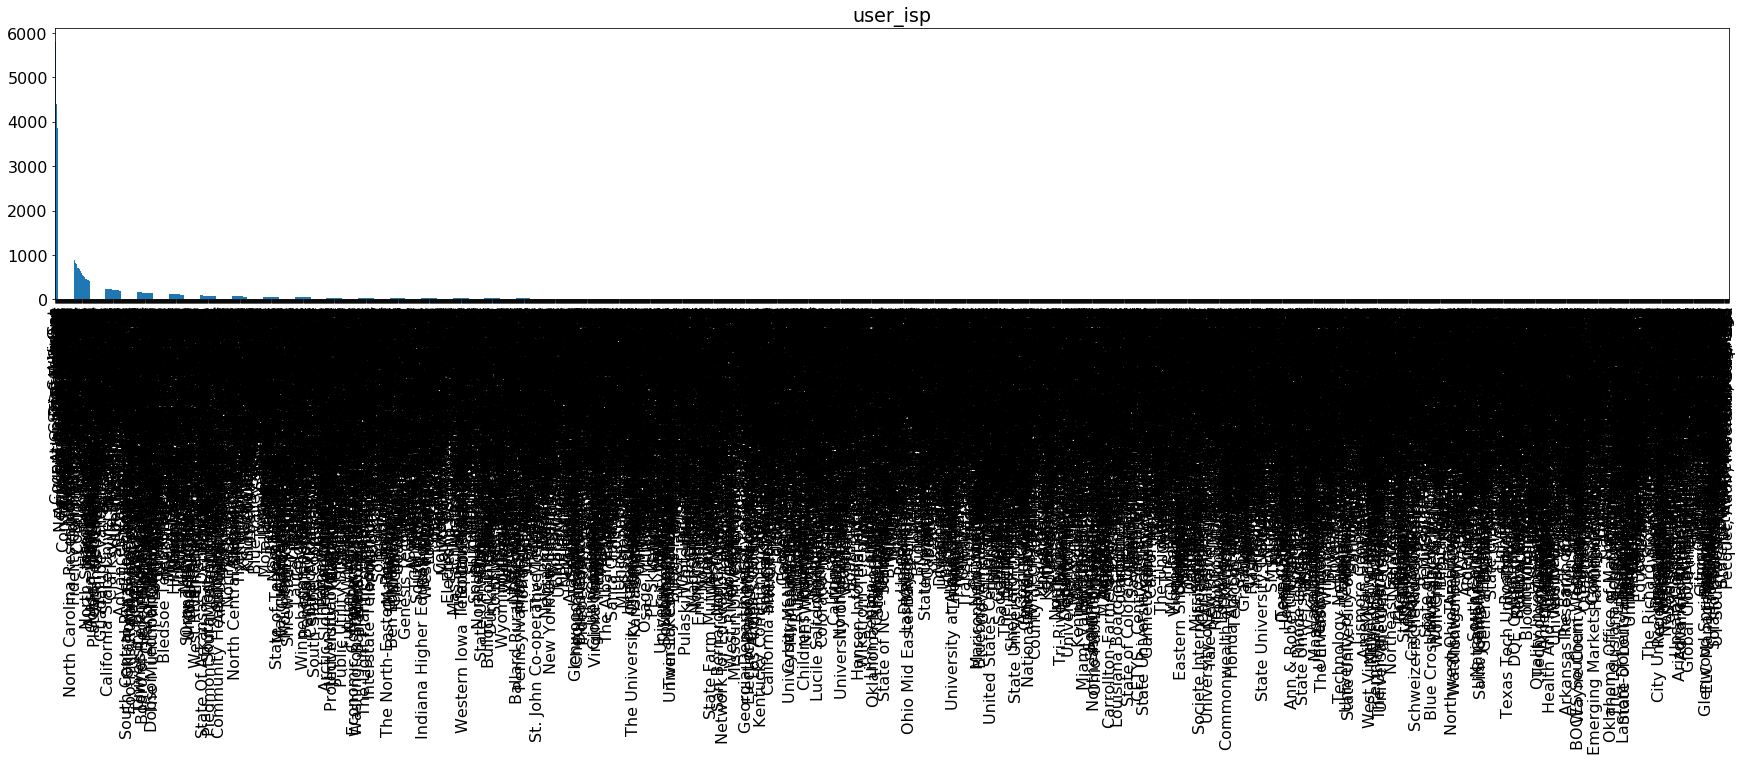

In [183]:
plt.rcParams['font.size'] = '16'
x = df['user_isp'][df['user_isp'].notna()].value_counts().sort_values(ascending=False)
x = x[df['user_isp'][df['user_isp'].notna()].value_counts()<6000]
x.plot.bar(title='user_isp',figsize=(30,5))
print('number of rows:',x.sum())
print('% of rows to be combined:',100*(x.sum()/len(df['user_isp'])))
print('% of categories to be combined:',100*(len(x.keys())/len(df['user_isp'].unique())))

##### ~99% of the categories fall under 5% of the data

In [184]:
#get all the values that have a small number of uses in order to coombine
x = df['user_isp'][df['user_isp'].notna()==True].value_counts().sort_values(ascending=False)
x = x[df['user_isp'][df['user_isp'].notna()==True].value_counts()<6000]
#locate the values in the combine list and change them to longTail
df.loc[df['user_isp'].isin(x.keys()) , "user_isp"] = 'LongTail'
df['user_isp'][df['user_isp'] =='LongTail']
df['user_isp'] = df['user_isp'].astype('category')

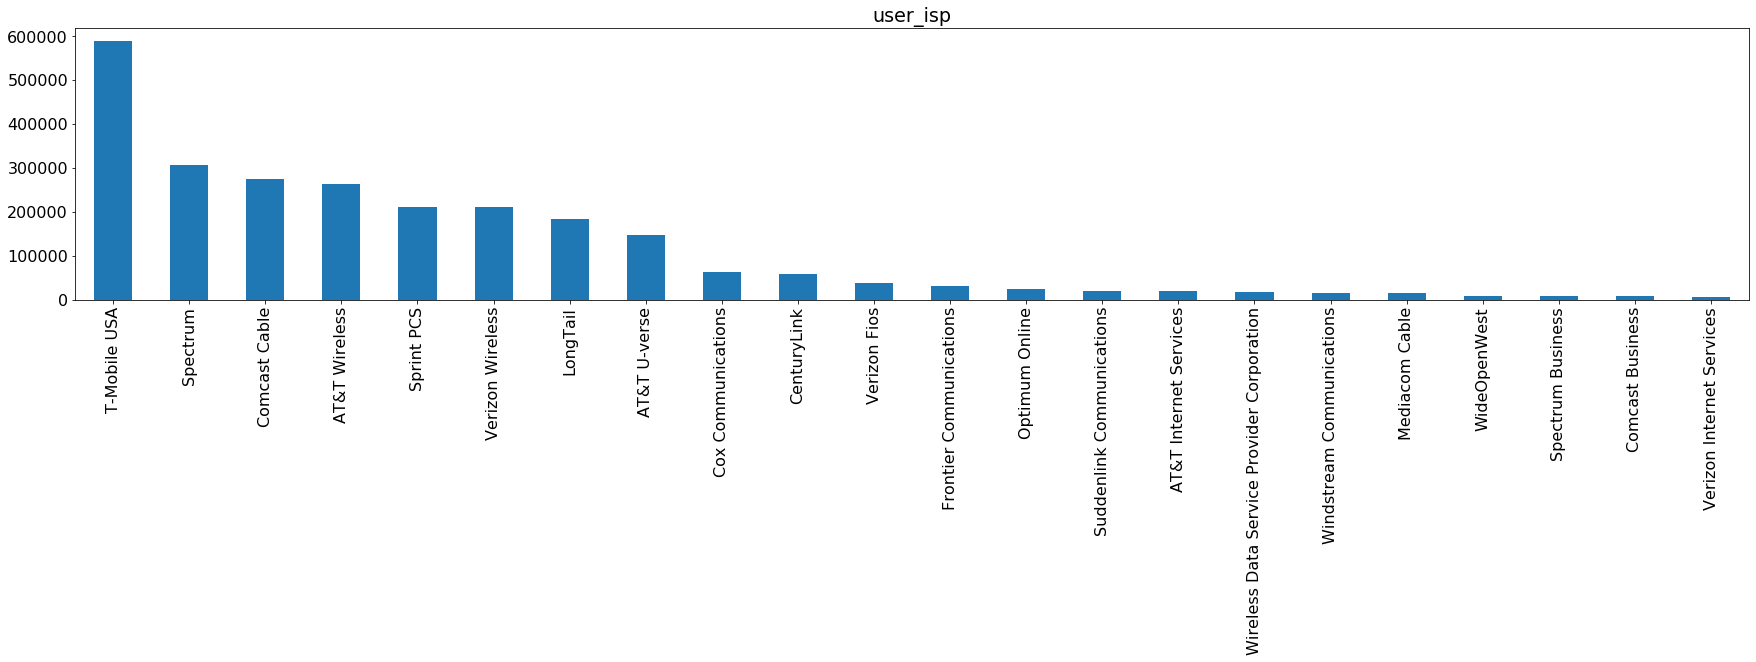

In [185]:
plt.rcParams['font.size'] = '16'
x = df['user_isp'].value_counts().sort_values(ascending=False)
x.plot.bar(title='user_isp',figsize=(30,5))

<Figure size 2160x720 with 0 Axes>

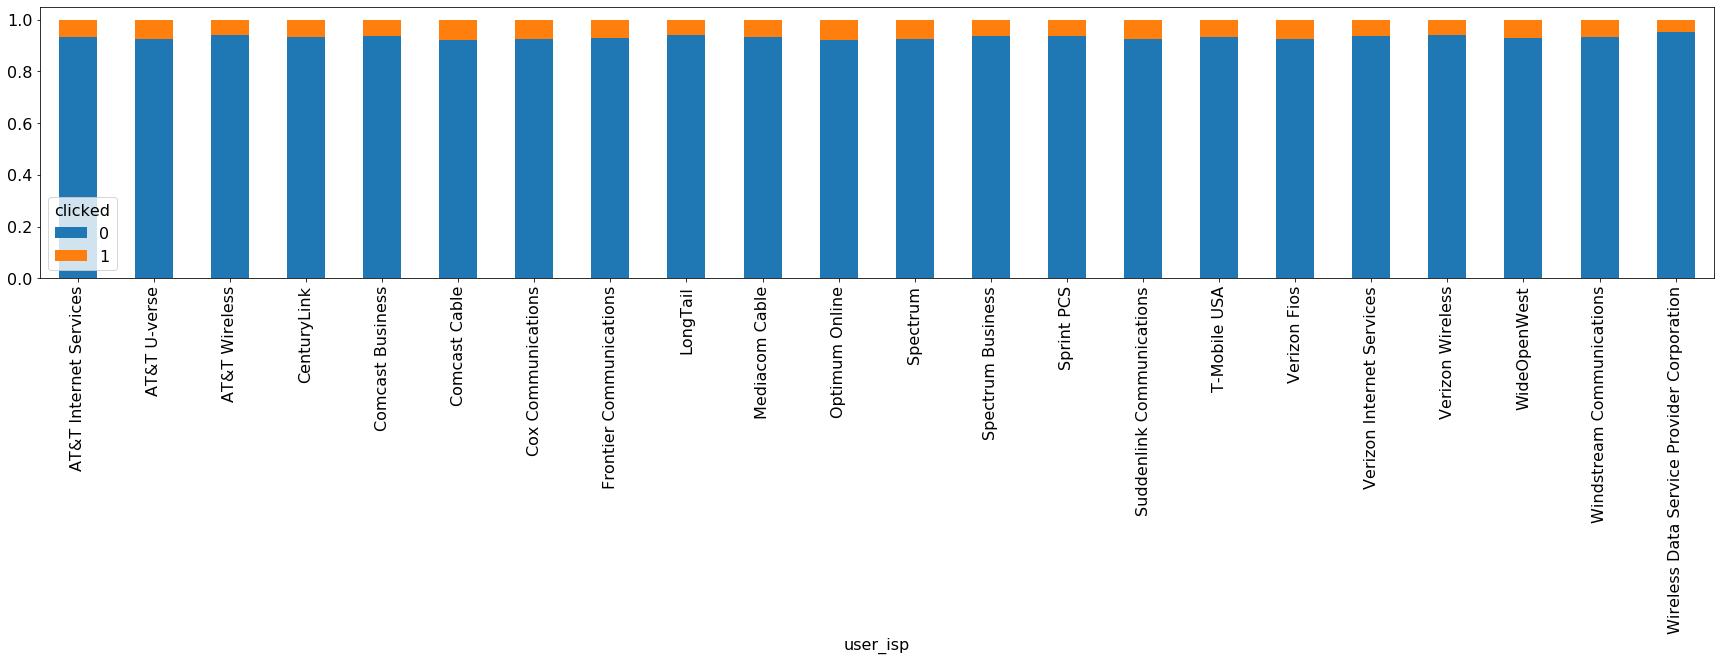

In [186]:
plt.figure(figsize=(30, 10))
df_pct = (df.groupby(['user_isp','clicked'])['user_isp'].count()/df.groupby(['user_isp'])['user_isp'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

##### 22 categories instead of 3316

##### State

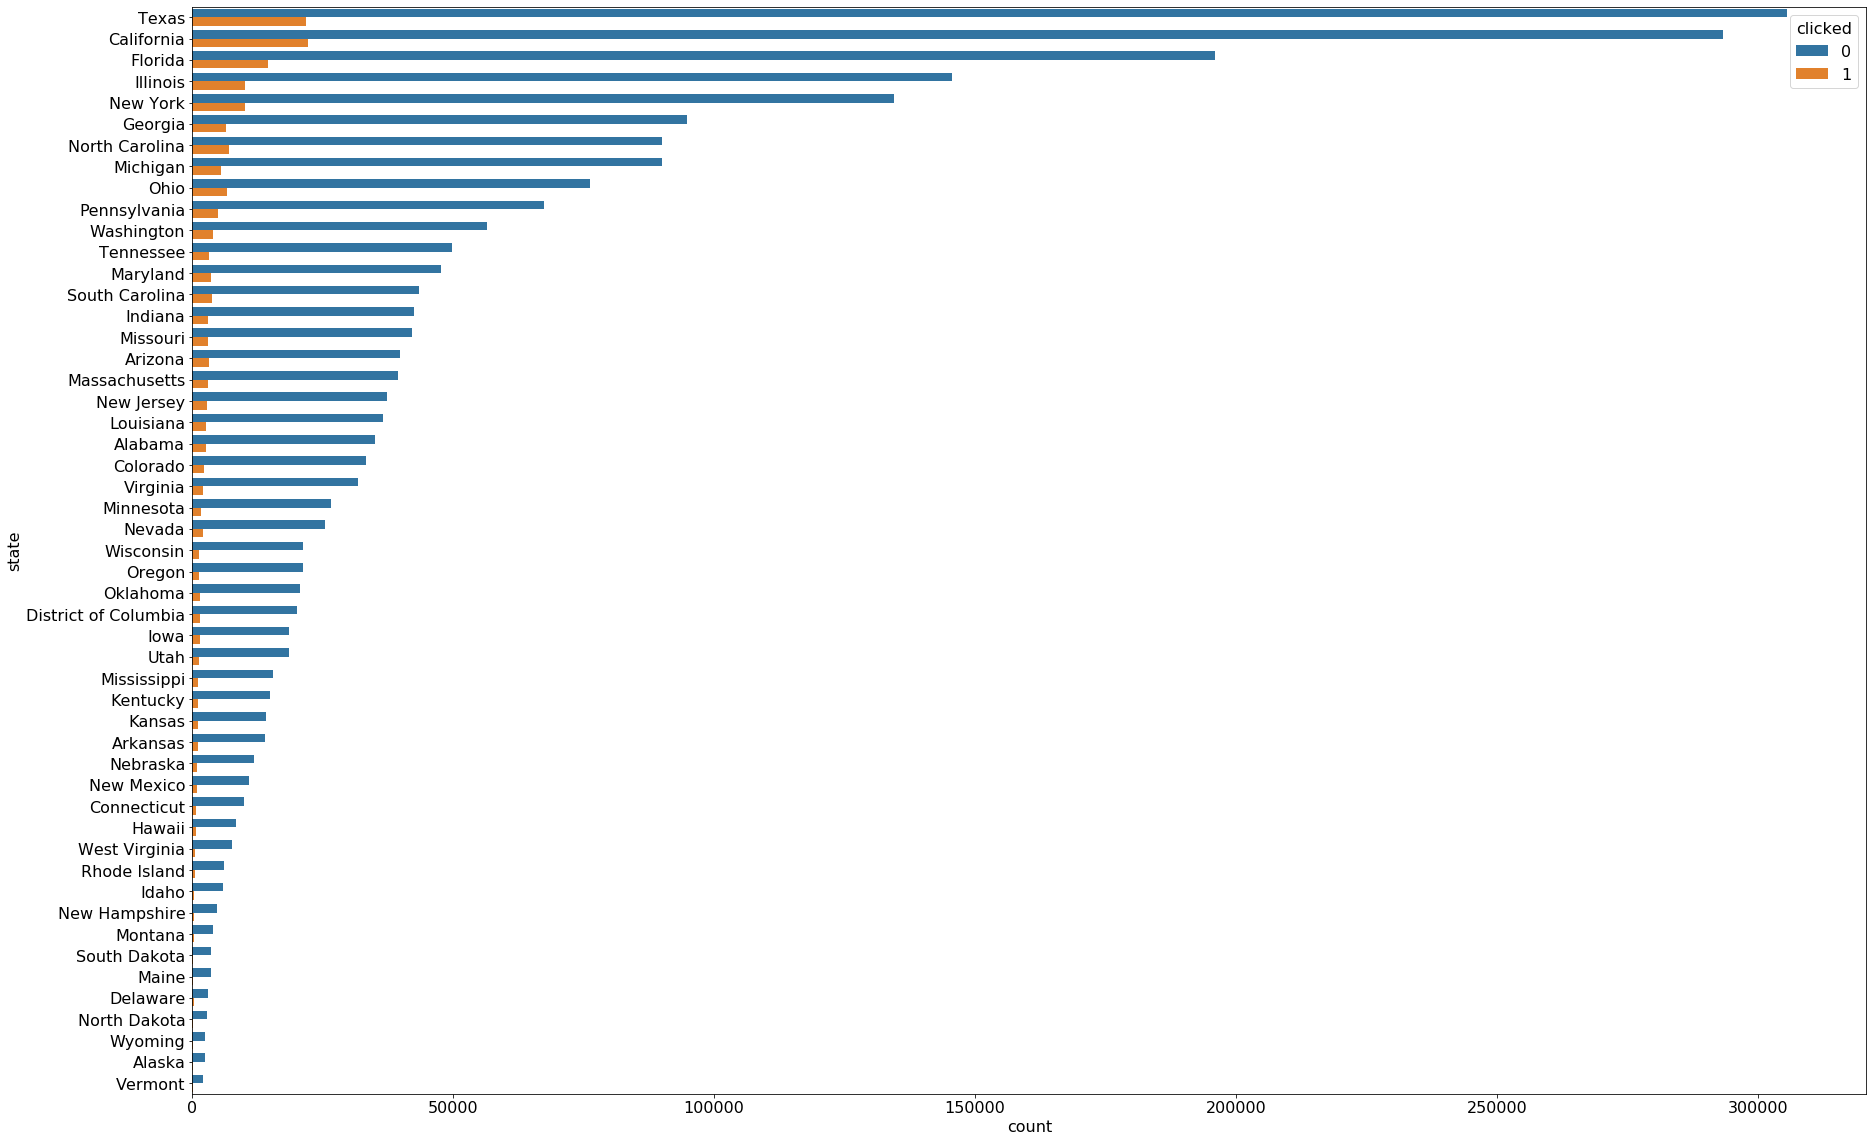

<Figure size 2160x720 with 0 Axes>

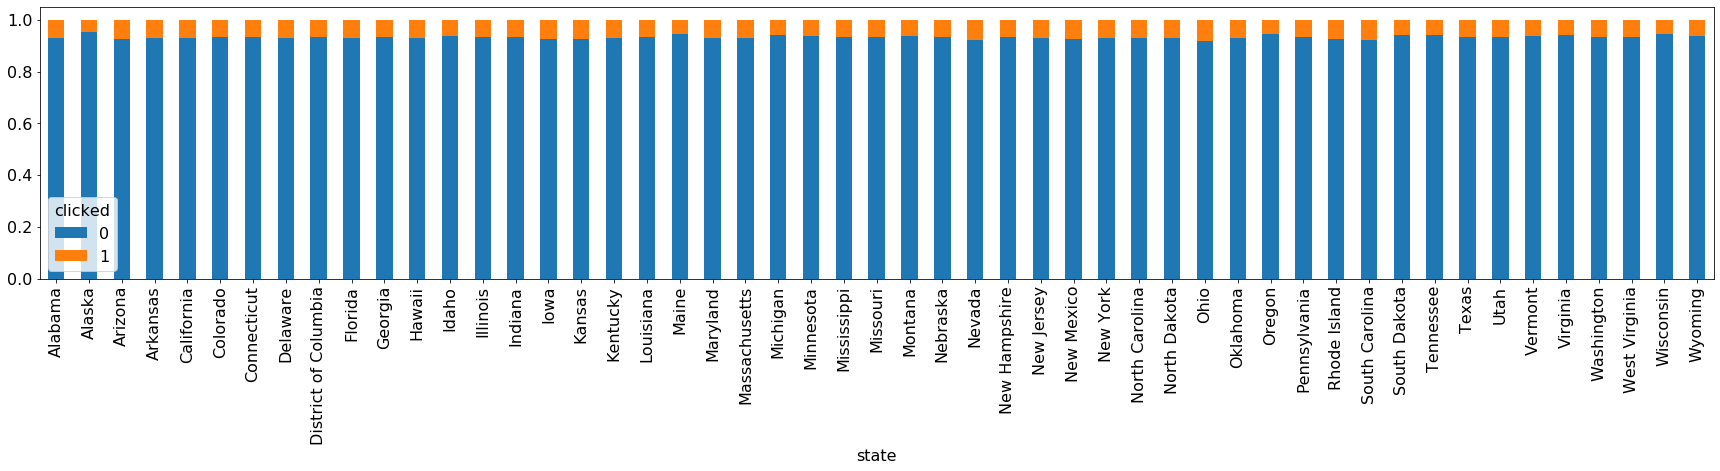

In [187]:
plt.figure(figsize=(30, 20))
ax = sns.countplot(y= df['state'], hue=df['clicked'], data=df,order = df['state'].value_counts().index)
plt.figure(figsize=(30, 10))
df_pct = (df.groupby(['state','clicked'])['state'].count()/df.groupby(['state'])['state'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

# Creating new columns

### Date - Split to Month/Week days/is weekend

In [188]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%d/%m/%Y %H:%M:%S')
df['Day of Week']=df['timestamp'].dt.dayofweek

In [189]:
df['Day of Week'].unique()

array([2, 3, 6, 4, 1, 0, 5], dtype=int64)

In [190]:
df['weekend'] = np.where(df['Day of Week'].isin(['6','7']), 1, 0).astype('int32')

In [191]:
df['month'] = df['timestamp'].dt.month

In [192]:
df.head()

timestamp       state          user_isp   app_id             app_cat banner_pos manufacturer device_model device_version  device_height  device_width  clicked     combined  Day of Week  weekend  month
0 2019-09-25 21:02:06  New Jersey     Comcast Cable  6rm7ag7  games - simulation  top-right      Samsung     SM-G925V              3            792          1408        0   3_792_1408            2        0      9
1 2019-08-22 23:41:37    Illinois  Verizon Wireless  74193f6        games - card      right      Unknown      Unknown              5           2560          1440        0  5_2560_1440            3        0      8
2 2019-08-21 08:23:29  California      T-Mobile USA  6549c21      games - puzzle   top-left      Unknown      Unknown              5           1280           720        0   5_1280_720            2        0      8
3 2019-09-15 17:34:02  California      T-Mobile USA  dng7e8p             unknown       left      Samsung    SM-J700T1              7           1280           720        0   7_1280_720            6        1      9
4 2019-10-18 00:19:59     Georgia          LongTail  hp3monn  games - simulation   top-left     T-Mobile        5049W              5            720          1280        1   5_720_1280            4        0     10

### High width Ratio

In [193]:
df['Ratio'] = df['device_height'] / df['device_width']

In [194]:
df[['Ratio','device_height','device_width']]

Ratio  device_height  device_width
0       0.562500            792          1408
1       1.777778           2560          1440
2       1.777778           1280           720
3       1.777778           1280           720
4       0.562500            720          1280
...          ...            ...           ...
2519051 1.779167            854           480
2519052 1.777778           1920          1080
2519053 0.562500           1080          1920
2519054 1.777778           1920          1080
2519055 1.779167            854           480

[2519056 rows x 3 columns]

##### Perhaps can remove width and hight and leave just ratio will see in corr plot

### Region & Devision from State

##### Getting Region and Division of the states 

In [195]:
#upload data
df_states_Region = pd.read_csv('UsStateToRegion.csv')
df_states_Region = pd.DataFrame(df_states_Region)
df_states_Region=df_states_Region.rename(columns={"State": "state"})
df_states_Region

state State Code     Region            Division
0                 Alaska         AK       West             Pacific
1                Alabama         AL      South  East South Central
2               Arkansas         AR      South  West South Central
3                Arizona         AZ       West            Mountain
4             California         CA       West             Pacific
5               Colorado         CO       West            Mountain
6            Connecticut         CT  Northeast         New England
7   District of Columbia         DC      South      South Atlantic
8               Delaware         DE      South      South Atlantic
9                Florida         FL      South      South Atlantic
10               Georgia         GA      South      South Atlantic
11                Hawaii         HI       West             Pacific
12                  Iowa         IA    Midwest  West North Central
13                 Idaho         ID       West            Mountain
14              Illinois         IL    Midwest  East North Central
15               Indiana         IN    Midwest  East North Central
16                Kansas         KS    Midwest  West North Central
17              Kentucky         KY      South  East South Central
18             Louisiana         LA      South  West South Central
19         Massachusetts         MA  Northeast         New England
20              Maryland         MD      South      South Atlantic
21                 Maine         ME  Northeast         New England
22              Michigan         MI    Midwest  East North Central
23             Minnesota         MN    Midwest  West North Central
24              Missouri         MO    Midwest  West North Central
25           Mississippi         MS      South  East South Central
26               Montana         MT       West            Mountain
27        North Carolina         NC      South      South Atlantic
28          North Dakota         ND    Midwest  West North Central
29              Nebraska         NE    Midwest  West North Central
30         New Hampshire         NH  Northeast         New England
31            New Jersey         NJ  Northeast     Middle Atlantic
32            New Mexico         NM       West            Mountain
33                Nevada         NV       West            Mountain
34              New York         NY  Northeast     Middle Atlantic
35                  Ohio         OH    Midwest  East North Central
36              Oklahoma         OK      South  West South Central
37                Oregon         OR       West             Pacific
38          Pennsylvania         PA  Northeast     Middle Atlantic
39          Rhode Island         RI  Northeast         New England
40        South Carolina         SC      South      South Atlantic
41          South Dakota         SD    Midwest  West North Central
42             Tennessee         TN      South  East South Central
43                 Texas         TX      South  West South Central
44                  Utah         UT       West            Mountain
45              Virginia         VA      South      South Atlantic
46               Vermont         VT  Northeast         New England
47            Washington         WA       West             Pacific
48             Wisconsin         WI    Midwest  East North Central
49         West Virginia         WV      South      South Atlantic
50               Wyoming         WY       West            Mountain

In [196]:
x = pd.merge(df, df_states_Region[['state','Region','Division']], how='left', on='state' )
df['Region'] = x['Region']
df['Division'] = x['Division']

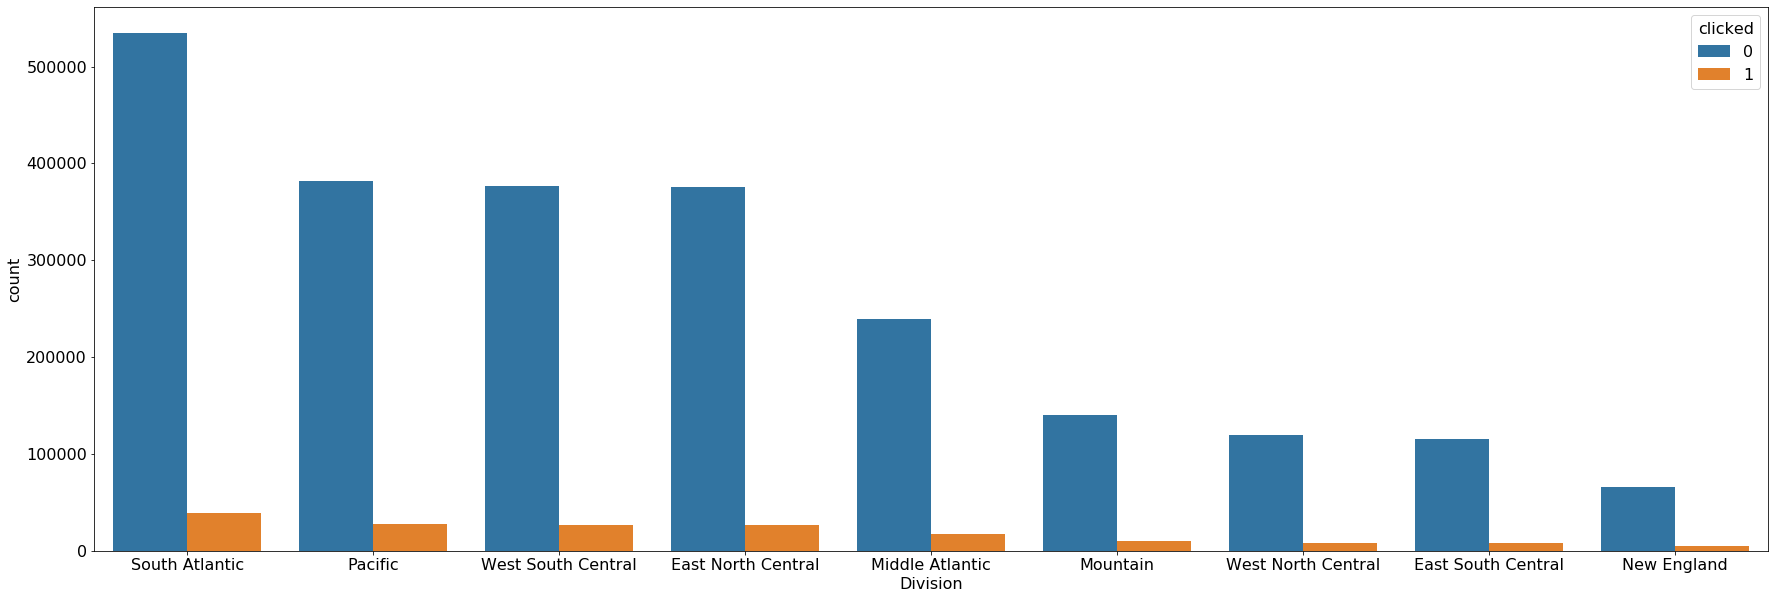

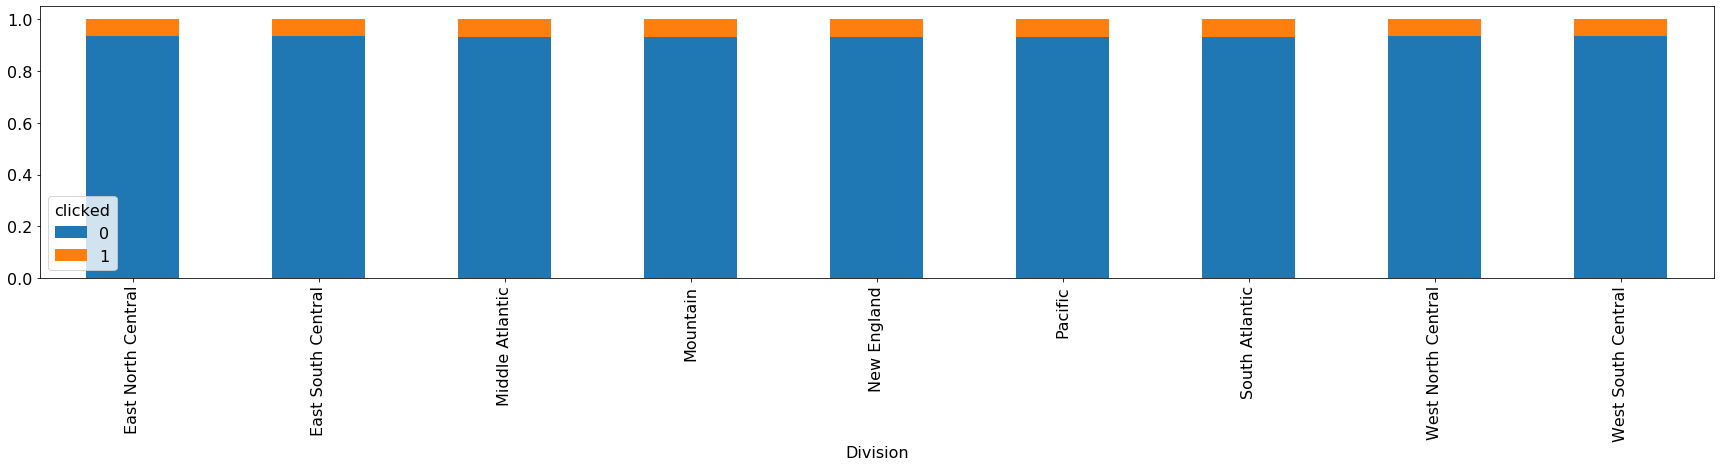

In [197]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x= df['Division'], hue=df['clicked'], data=df,order = df['Division'].value_counts().index)
df_pct = (df.groupby(['Division','clicked'])['Division'].count()/df.groupby(['Division'])['Division'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

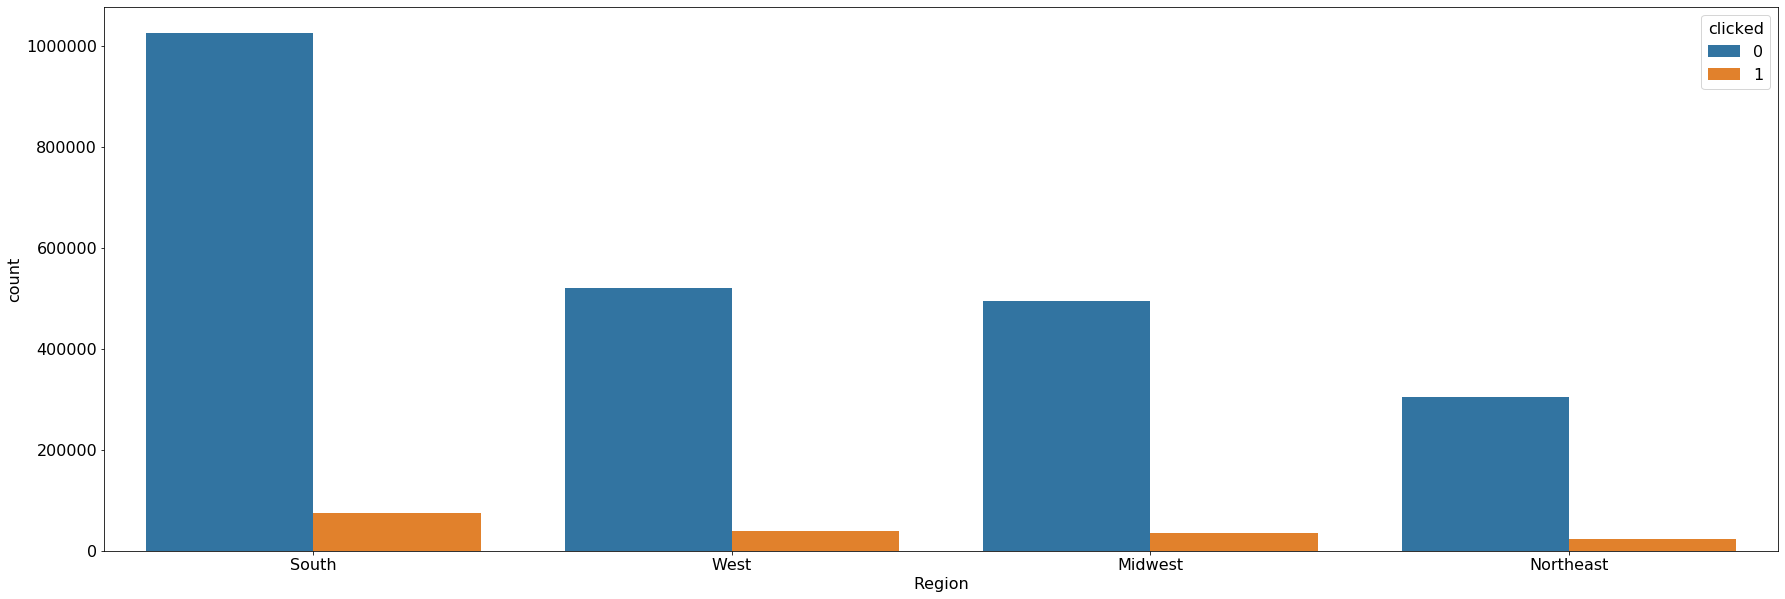

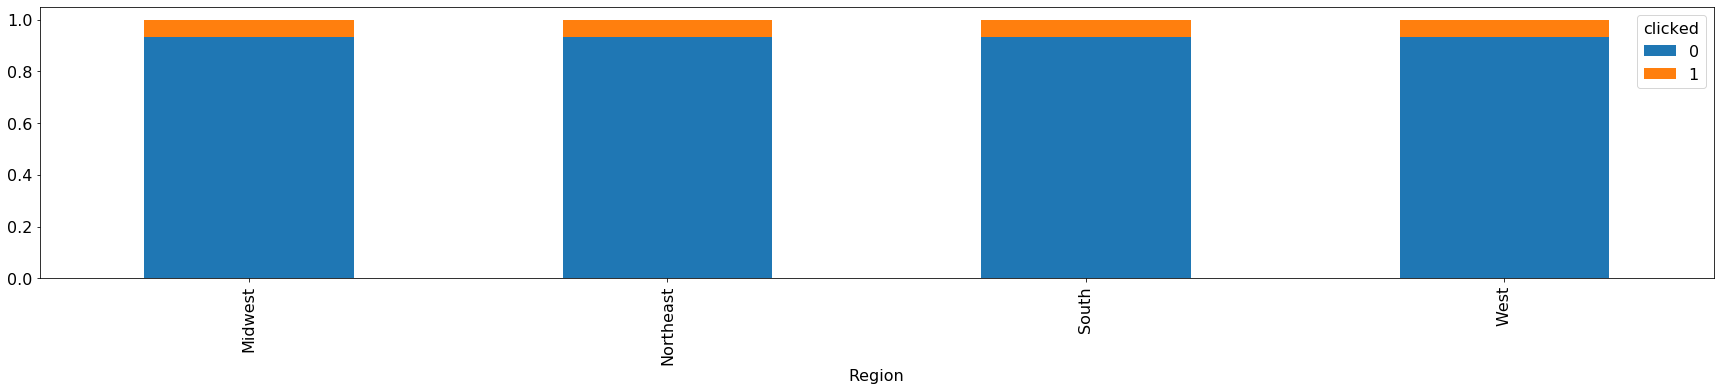

In [198]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x= df['Region'], hue=df['clicked'], data=df,order = df['Region'].value_counts().index)
df_pct = (df.groupby(['Region','clicked'])['Region'].count()/df.groupby(['Region'])['Region'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

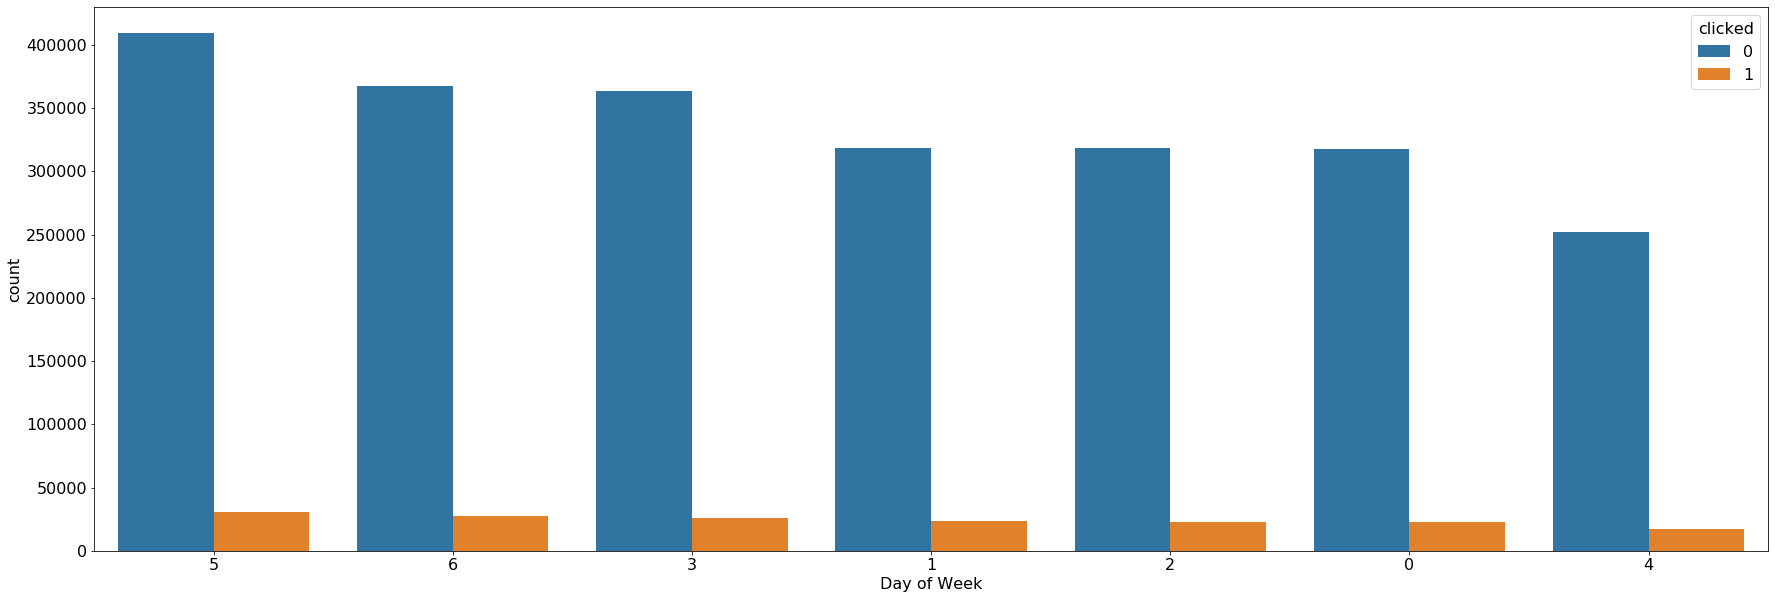

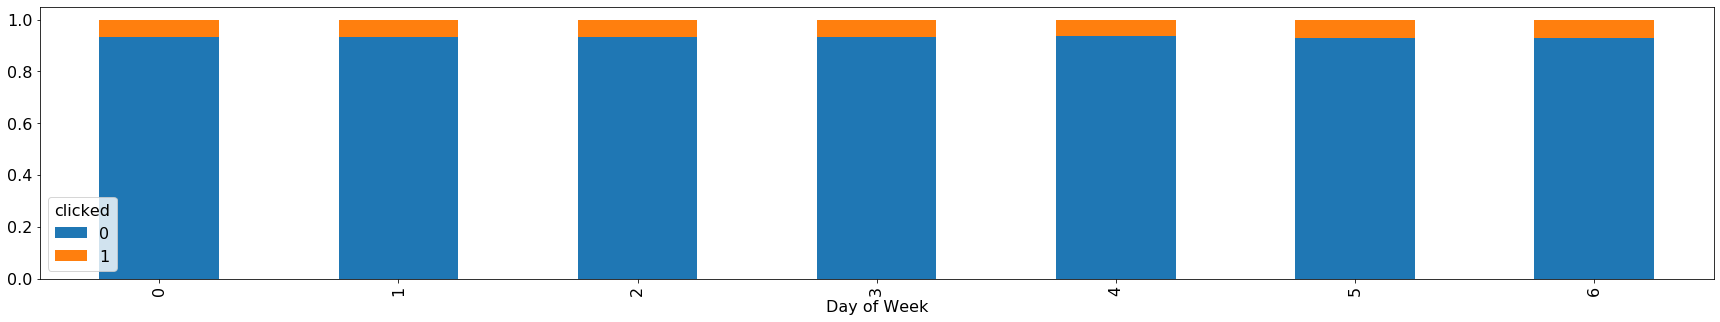

In [199]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x= df['Day of Week'], hue=df['clicked'], data=df,order = df['Day of Week'].value_counts().index)
df_pct = (df.groupby(['Day of Week','clicked'])['Day of Week'].count()/df.groupby(['Day of Week'])['Day of Week'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

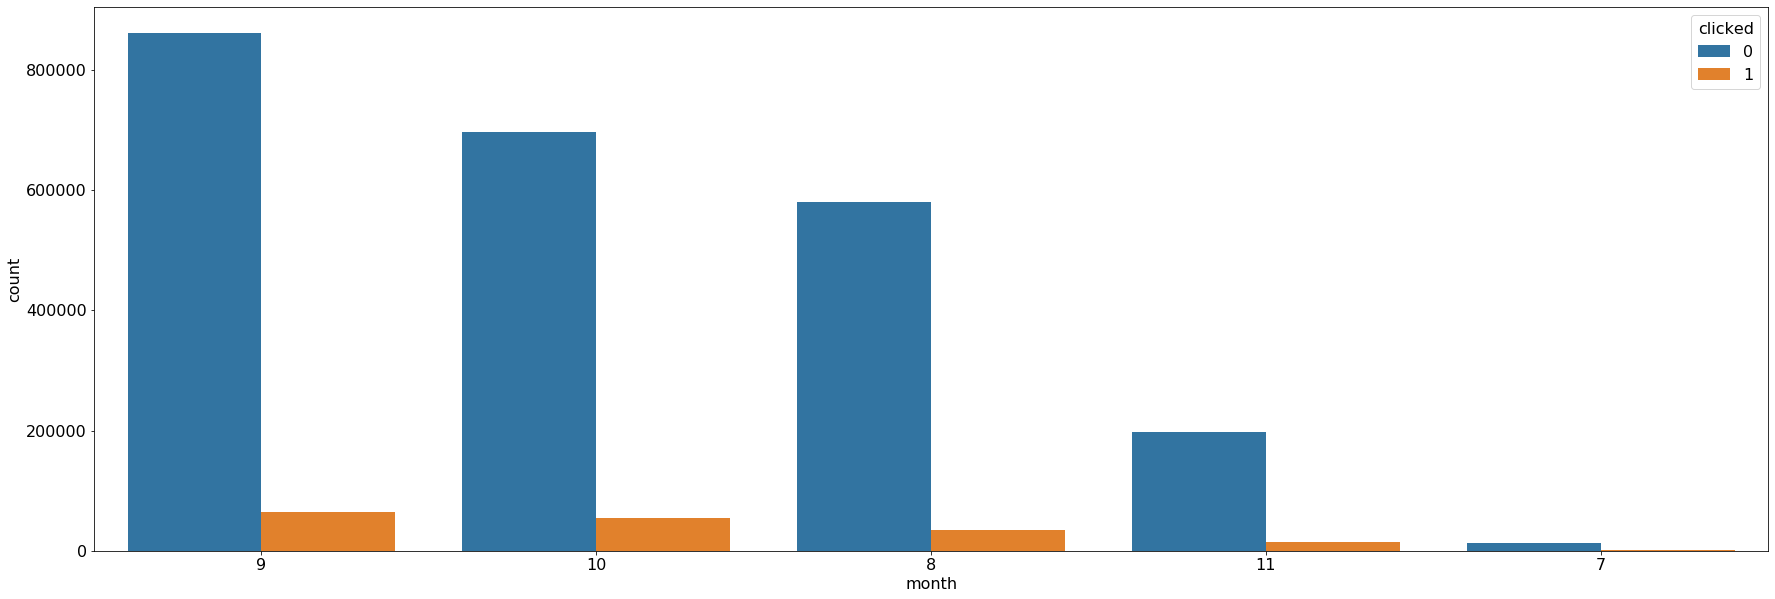

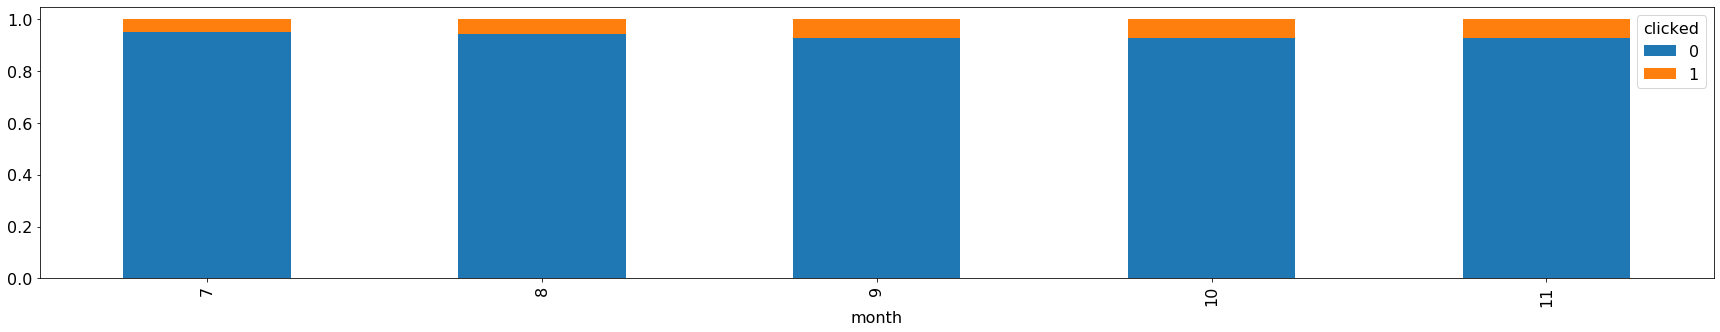

In [200]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x= df['month'], hue=df['clicked'], data=df,order = df['month'].value_counts().index)
df_pct = (df.groupby(['month','clicked'])['month'].count()/df.groupby(['month'])['month'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

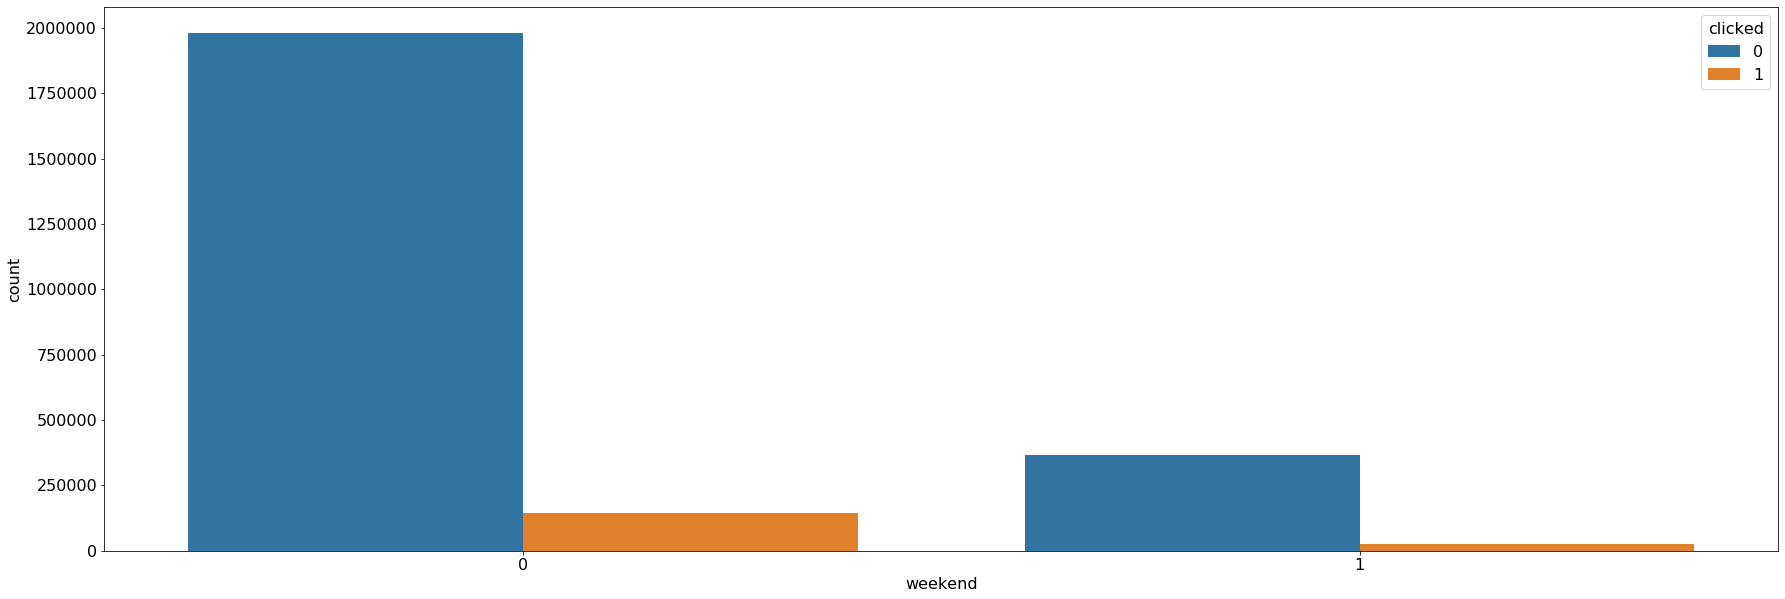

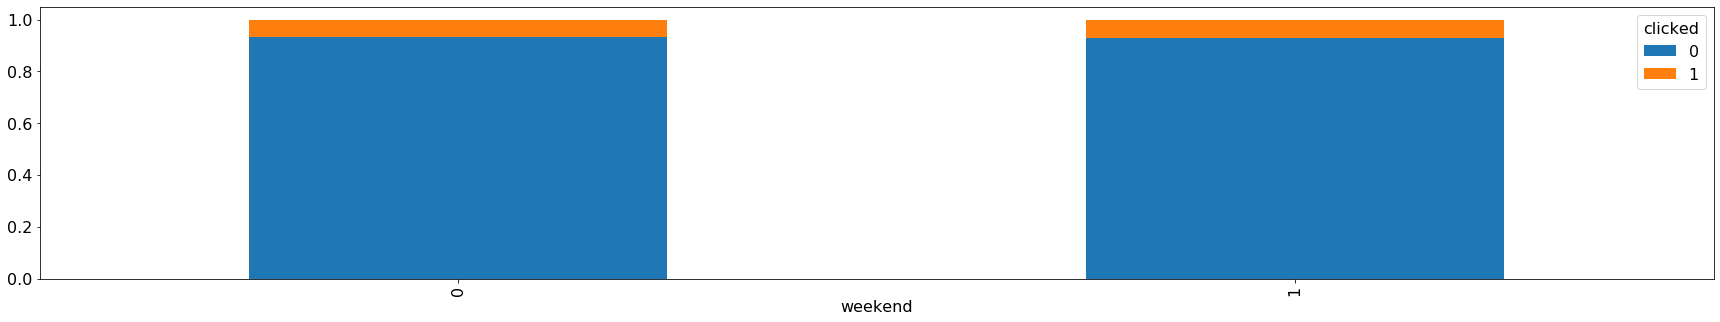

In [201]:
plt.figure(figsize=(30, 10))
ax = sns.countplot(x= df['weekend'], hue=df['clicked'], data=df,order = df['weekend'].value_counts().index)
df_pct = (df.groupby(['weekend','clicked'])['weekend'].count()/df.groupby(['weekend'])['weekend'].count())
df_pct.unstack().plot.bar(stacked=True,figsize=(30,5))

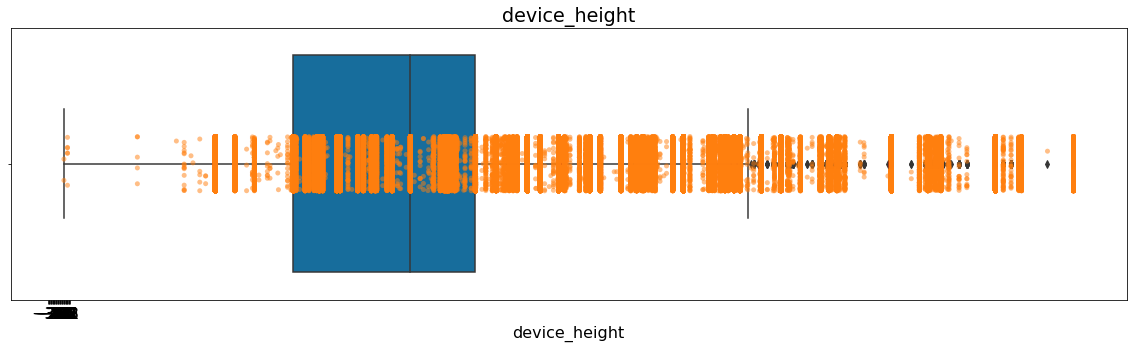

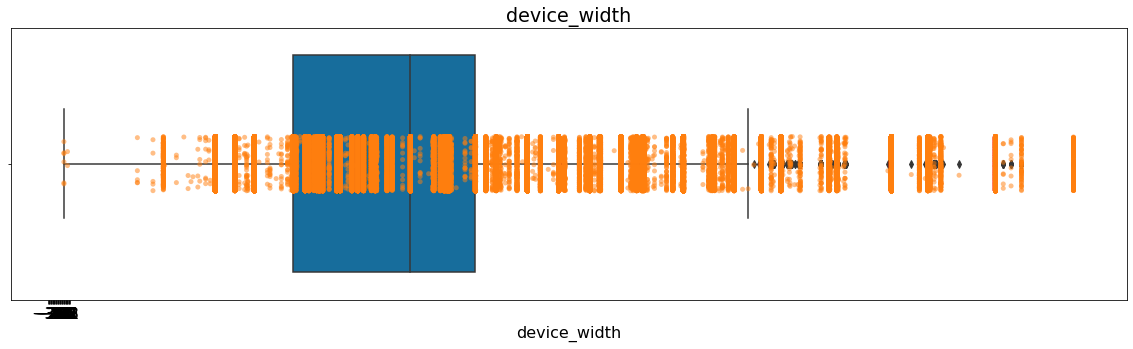

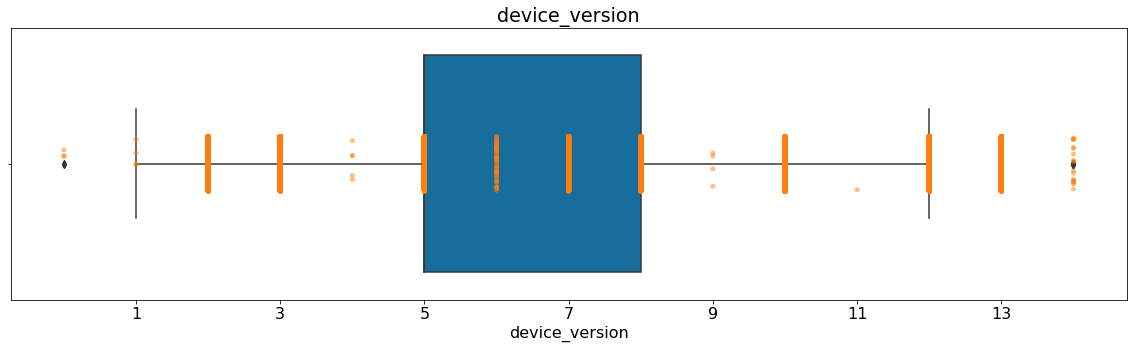

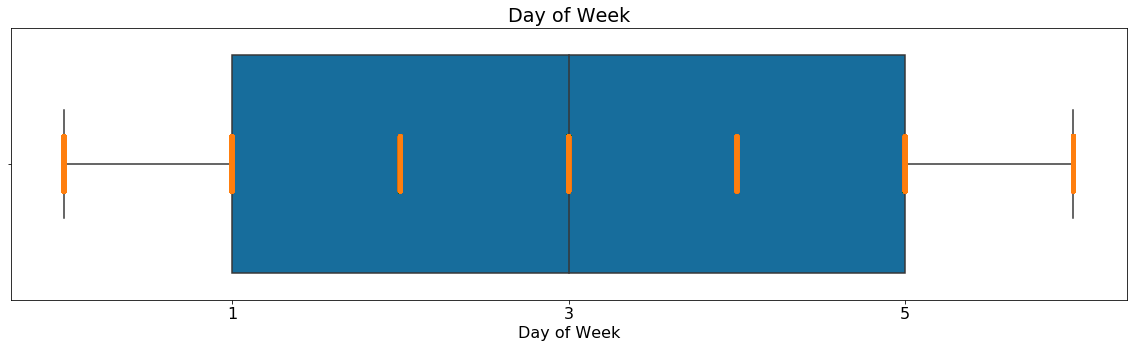

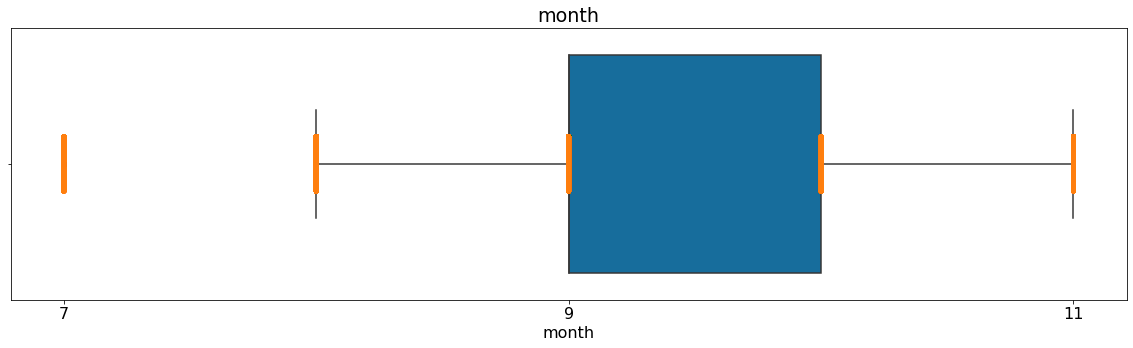

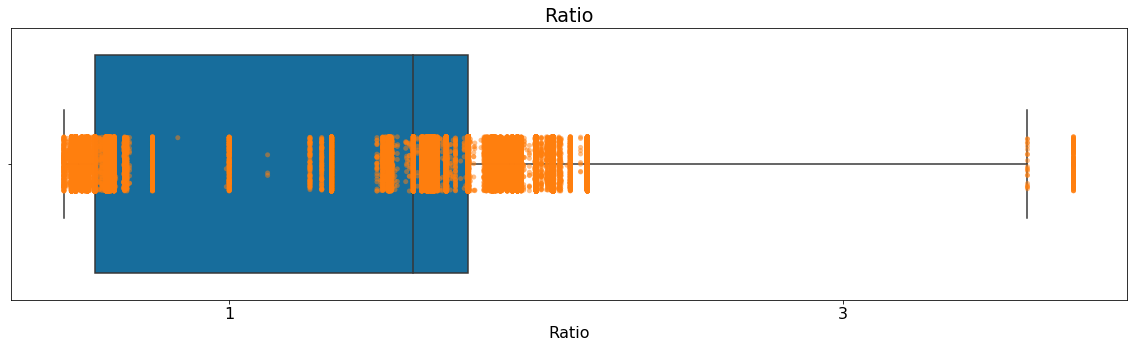

In [202]:
def print_box_plot_and_outliers(df):
    #created dict of data frames with outliers
    #dictionary key is the name of the column
#   #dictionary value is the dataframe of outliers
    outliers_dict ={}
    for col in df.columns:
        #box plot
        if col =='clicked':
            break
        plt.figure(figsize=(20,5))
        plt.xticks(range(-35, 35, 2))
        bplot = sns.boxplot(x=df[col],palette="colorblind", whis=1.5)
        bplot = sns.stripplot(x=df[col],jitter=True,marker='o',alpha=0.5,hue=df['clicked'], palette=["C1", "k"])
        plt.title(col)
        plt.show()

        
    return outliers_dict

outliers_dict = print_box_plot_and_outliers(df[['device_height','device_width' ,'device_version','Day of Week','month', 'Ratio','clicked']])    

##### no significant corelation other that ratio with hight and width - expected. 

In [203]:
df.isnull().sum()

timestamp         0
state             0
user_isp          0
app_id            0
app_cat           0
banner_pos        0
manufacturer      0
device_model      0
device_version    0
device_height     0
device_width      0
clicked           0
combined          0
Day of Week       0
weekend           0
month             0
Ratio             0
Region            0
Division          0
dtype: int64

# One Hot Encoding

In [204]:
def GetOneHotEnc(df_, column_):
    enc = OneHotEncoder(handle_unknown='ignore')
    matrix = enc.fit_transform(df_[column_].to_frame())
    column_names = enc.get_feature_names([column_])
    res = pd.DataFrame(matrix.todense(), columns= column_names).astype('int16')
    return res

# Normalization

In [205]:
# normalizing feature values from zero to one
def NormalizingFromZeroToOne(column_):
    Max= column_.max()
    Min= column_.min()
    MinMax= Max-Min
    res = (column_-Min)/(MinMax)
    return res.astype('float16')

# Corelation

### Corelation of the categorical features 

Text(0.5, 1, 'Correlation Matrix')

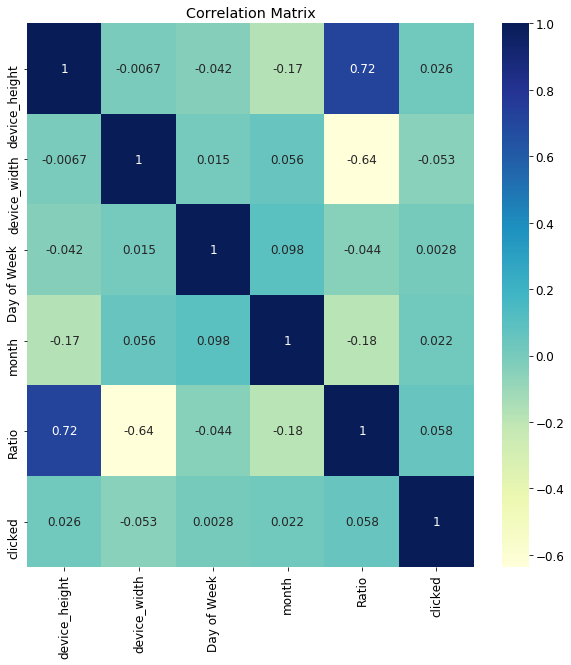

In [206]:
df_corr = df[['device_height','device_width' ,'device_version','Day of Week','month', 'Ratio','clicked']]
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 12})
ax = sns.heatmap(df_corr.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")

##### no significant corelation other that ratio with hight and width - expected. 

### Corelation of the numerical features 



***************************************************


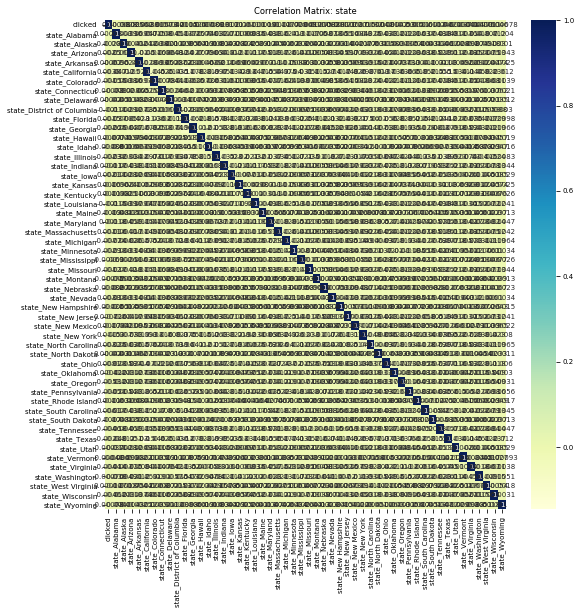



***************************************************


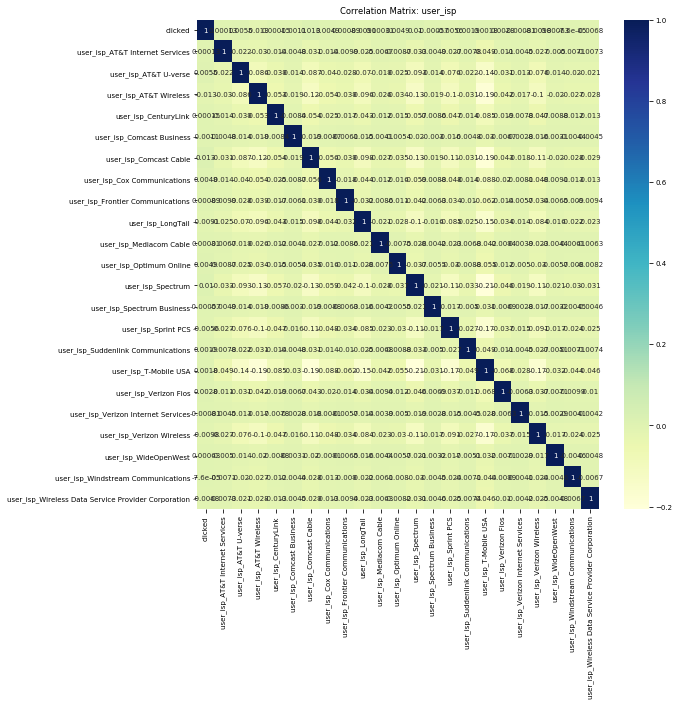



***************************************************


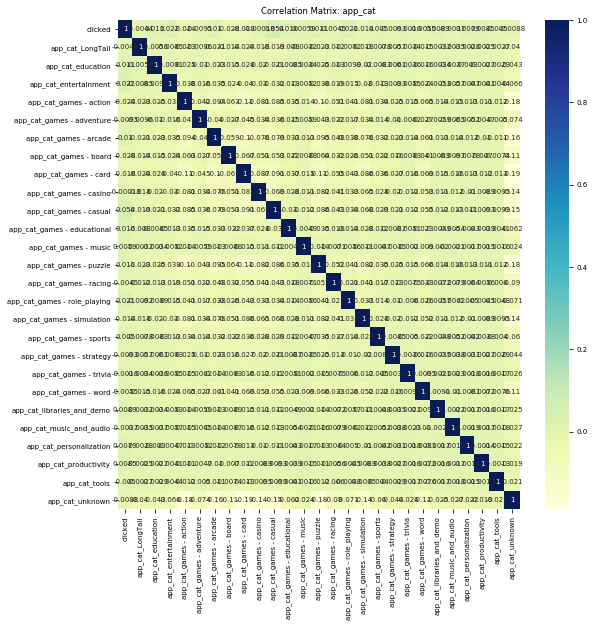



***************************************************


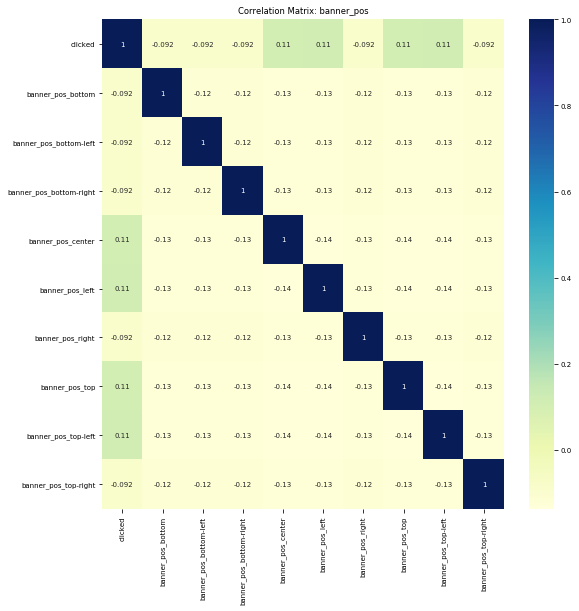



***************************************************


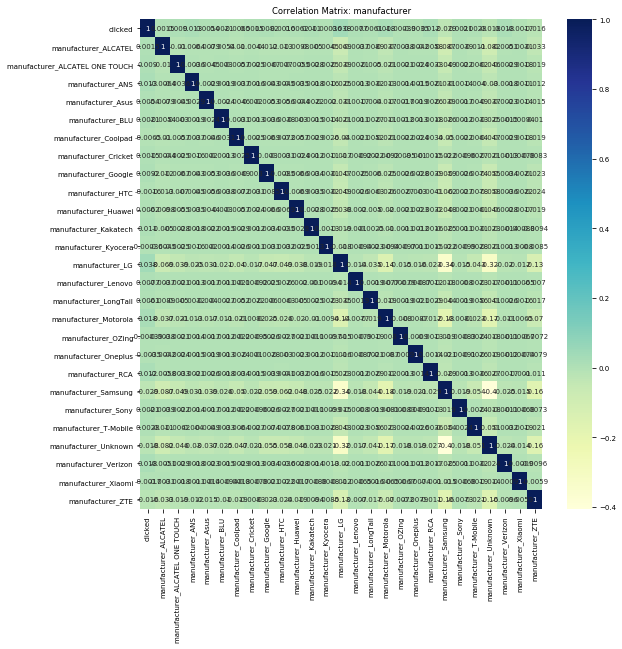



***************************************************


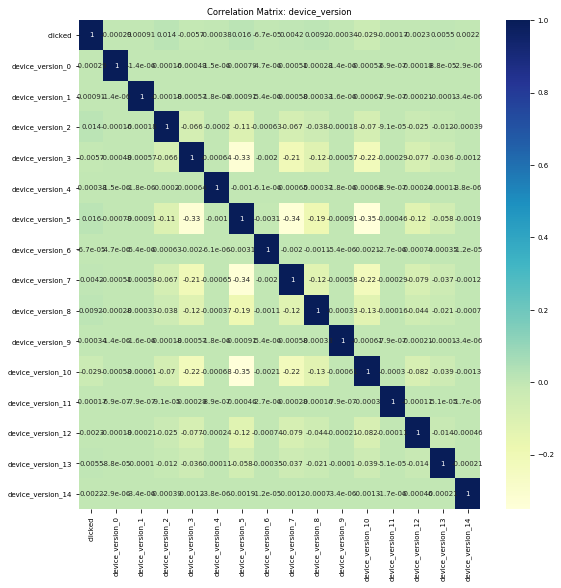



***************************************************


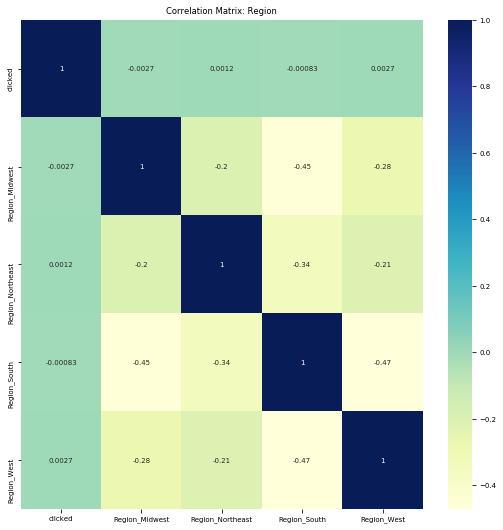



***************************************************


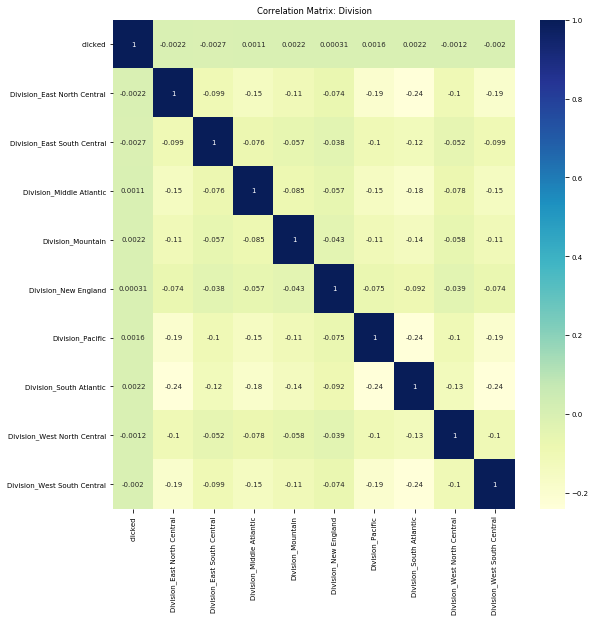

In [210]:
cat_feat_list = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_version', 'Region', 'Division']
for feat in cat_feat_list:
    print('\n\n***************************************************')
    feat_df = feat+'_df'
    feat_df = GetOneHotEnc(df, feat)
    feat_df = pd.merge(df['clicked'], feat_df, how = 'left', left_index = True, right_index = True)
    plt.figure(figsize=(9,9))
    plt.rcParams.update({'font.size': 7})
    ax = sns.heatmap(feat_df.corr(), annot=True, cmap="YlGnBu")
    plt.title("Correlation Matrix: "+ feat)
    plt.show()

# Imbalanced Data

In [56]:
# # all the over smaplling options availble here:
# # https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC

# data = df.head(5000)
# print('The original imbalanced dataset')
# print(sorted(Counter(data.clicked).items()))
# data = data.dropna(axis=0, how='any').copy()
# print('The original imbalanced dataset')
# print(sorted(Counter(data.clicked).items()))
# target = df['clicked'].copy()
# features = df.drop(['clicked'], axis=1)

In [57]:
# # SMOTE NC
# sm = SMOTENC(random_state=42, categorical_features=[0,2,3,4,5,6,7,8,9,12], sampling_strategy=0.35)
# X_res, y_res = sm.fit_resample(features, target)

In [58]:
# print('Dataset after resampling')
# print(sorted(Counter(y_res).items()))

In [59]:
# # ADASYN
# ada = ADASYN(random_state=42, sampling_strategy=0.5)
# X_res, y_res = ada.fit_resample(features, target)

In [60]:
# print('Dataset after resampling')
# print(sorted(Counter(y_res).items()))

In [61]:
# # Random Under Samplling
# rus = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
# X_res, y_res = rus.fit_resample(features, target)

In [62]:
# print('Dataset after resampling')
# print(sorted(Counter(y_res).items()))

# XGB

In [63]:
data_xgb = df.head(300000).copy()
target_xgb = data_xgb.pop('clicked')

In [64]:
data_xgb.drop(['combined'], axis=1, inplace=True)
data_xgb.drop(['app_id'], axis=1, inplace=True)
data_xgb.drop(['timestamp'], axis=1, inplace=True)
data_xgb.drop(['device_model'], axis=1, inplace=True)
data_xgb.drop(['device_height'], axis=1, inplace=True)
data_xgb.drop(['device_width'], axis=1, inplace=True)
# data_xgb.drop(['Day of Week'], axis=1, inplace=True)
# data_xgb.drop(['Region'], axis=1, inplace=True)

In [65]:
data_xgb.dtypes

state             category
user_isp          category
app_cat           category
banner_pos        category
manufacturer      category
device_version    category
Day of Week          int64
weekend              int32
month                int64
Ratio              float64
Region              object
Division            object
dtype: object

In [66]:
cat_feat_list = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_version', 'Region', 'Division']
num_feat_list = ['Day of Week', 'weekend', 'month', 'Ratio']

In [67]:
for feat in cat_feat_list:
    feat_df = feat+'_df'
    feat_df = GetOneHotEnc(data_xgb, feat)
    data_xgb = pd.merge(data_xgb, feat_df, how = 'left', left_index = True, right_index = True)
    data_xgb.drop([feat], axis=1, inplace=True)

In [68]:
for feat in num_feat_list:
    data_xgb[feat] = NormalizingFromZeroToOne(data_xgb[feat])

In [69]:
# split the data to train(70%), val(15%) and test(15%)
x_train_val_xgb, x_test_xgb, y_train_val_xgb, y_test_xgb = train_test_split(data_xgb, target_xgb, test_size=0.15, random_state=RANDOM_STATE)
x_train_xgb, x_val_xgb, y_train_xgb, y_val_xgb = train_test_split(x_train_val_xgb, y_train_val_xgb, test_size=0.20, random_state=RANDOM_STATE)
# x_train_xgb = x_train_xgb.reset_index(drop=True)
# y_train_xgb = y_train_xgb.reset_index(drop=True)
# x_val_xgb = x_val_xgb.reset_index(drop=True)
# y_val_xgb = y_val_xgb.reset_index(drop=True)
# x_test_xgb = x_test_xgb.reset_index(drop=True)
# y_test_xgb = y_test_xgb.reset_index(drop=True)

In [70]:
# ADASYN
#ada = ADASYN(random_state=42, sampling_strategy=0.6)
#x_train_xgb_resmp, y_train_xgb_resmp = ada.fit_resample(x_train_xgb, y_train_xgb)
sm = SMOTE(random_state=42, sampling_strategy=0.2)
x_train_xgb_resmp, y_train_xgb_resmp = sm.fit_resample(x_train_xgb, y_train_xgb)
#x_train_xgb_resmp = x_train_xgb
#y_train_xgb_resmp = y_train_xgb

In [71]:
def run_xgb(x_train_, y_train_, x_val_, y_val_, objective_ ='binary:logistic' ,booster_='gbtree', n_estimators_=100, 
            max_depth_=10, learning_rate_=0.1, reg_lambda_=0.5):
    scale_pos_weight = len(y_train_[y_train_ == 0])/len(y_train_[y_train_ == 1])


    parameters = {
         'scale_pos_weight': scale_pos_weight,
         'objective':objective_,
         'booster': booster_,
         'n_estimators': n_estimators_, 
         'max_depth': max_depth_, 
         'learning_rate': learning_rate_,  
         'reg_lambda': reg_lambda_,
         'verbosity': 1}

    
    xgb_model = xgb.XGBClassifier(**parameters, random_state = RANDOM_STATE)
    xgb_model.fit(x_train_, y_train_, eval_metric=["error", "logloss"])
       
    threshold = 0.5
    predicted_proba = xgb_model.predict_proba(x_val_)
    print(predicted_proba)
    print(predicted_proba [:,1])
    predicted = (predicted_proba [:,1] >= threshold).astype('int')
    accuracy = accuracy_score(y_val_, predicted)
    auc = roc_auc_score(y_val_, predicted, average='weighted')
    precision = precision_score(y_val_, predicted)
    precision_weighted = precision_score(y_val_, predicted, average='weighted')
    recall = recall_score(y_val_, predicted)
    recall_weighted = recall_score(y_val_, predicted, average='weighted')
    f1 = f1_score(y_val_, predicted)
    f1_weighted = f1_score(y_val_, predicted, average='weighted')
    
    
    
#     threshold = 0.1
#     predicted_proba = xgb_model.predict_proba(df_to_predict.iloc[:, 1:])
#     predicted_labels_after_threshold_move = (predicted_proba[:,1] >= threshold).astype('int')
#     predicted_labels_after_threshold_move_df = pd.DataFrame(data = predicted_labels_after_threshold_move, columns = ['predicted_labels'], index = df_to_predict.index.copy())


    return xgb_model, accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted

In [72]:
# xgb random search
objective_list =['binary:logistic','binary:logitraw','binary:hinge','']
boosting_list = ['gbtree','gbtree','']

evaluations = 30

# set seeds to make the random search to be with the same set of hyper-parameters

np.random.seed(22)
objective_indexes= np.random.uniform(low=0, high=len(objective_list)-1, size=(evaluations,))

np.random.seed(298)
boosting_indexes= np.random.uniform(low=0, high=len(boosting_list)-1, size=(evaluations,))

np.random.seed(20)
n_estimators_list= np.random.uniform(low=40, high=500, size=(evaluations,))

np.random.seed(256)
max_depth_list= np.random.uniform(low=2, high=15, size=(evaluations,))

np.random.seed(62)
learning_rate_list=  np.random.uniform(low=0.001, high=0.3, size=(evaluations,))


np.random.seed(54)
reg_lambda_list= np.random.uniform(low=0.01, high=1, size=(evaluations,))

xgb_results = pd.DataFrame(columns = ['Evaluation', 'objective','boosting','n_estimators', 'max_depth', 'learning_rate',
                                      'reg_lambda', 'accuracy', 'auc', 'precision', 'precision_weighted', 
                                       'recall', 'recall_weighted', 'f1', 'f1_weighted'
                                     ], index = list(range(evaluations)))
best_xgb_model = {}
highest_xgb_value = 0

for eval in range(evaluations):
    print("*******************************************************************************************")
    print('Evaluation #{}'.format(eval+1))
    objective = objective_list[int(objective_indexes[eval])]
    boosting = boosting_list[int(boosting_indexes[eval])]
    n_estimators = int(n_estimators_list[eval])
    max_depth = int(max_depth_list[eval])
    learning_rate = learning_rate_list[eval]
    reg_lambda = reg_lambda_list[eval]
    print("objective: %s; boosting: %s; n_estimators: %d; max_depth: %d; learning_rate: %4f; reg_lambda: %4f;"  \
      % (objective, boosting, n_estimators, max_depth, learning_rate, reg_lambda))

    
    xgb_model, accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted = \
    run_xgb(x_train_xgb_resmp, y_train_xgb_resmp, x_val_xgb, y_val_xgb, 
            objective_=objective, booster_=boosting, n_estimators_=n_estimators, \
            max_depth_=max_depth, learning_rate_=learning_rate, reg_lambda_=reg_lambda
            )
    
    print("objective: %s; boosting: %s; n_estimators: %d; max_depth: %d; learning_rate: %4f; reg_lambda: %4f; \
          accuracy: %4f; auc: %4f; precision: %4f; precision_weighted: %4f; recall: %4f; recall_weighted: %4f; \
          f1: %4f; f1_weighted: %4f;;" 
          % (objective, boosting, n_estimators, max_depth, learning_rate, reg_lambda, \
             accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted))
    
    xgb_results.loc[eval, ['Evaluation']] = eval+1
    xgb_results.loc[eval, ['objective']] = objective
    xgb_results.loc[eval, ['boosting']] = boosting
    xgb_results.loc[eval, ['n_estimators']] = n_estimators
    xgb_results.loc[eval, ['max_depth']] = max_depth
    xgb_results.loc[eval, ['learning_rate']] = learning_rate
    xgb_results.loc[eval, ['reg_lambda']] = reg_lambda
    xgb_results.loc[eval, ['accuracy']] = accuracy
    xgb_results.loc[eval, ['auc']] = auc
    xgb_results.loc[eval, ['precision']] = precision
    xgb_results.loc[eval, ['precision_weighted']] = precision_weighted
    xgb_results.loc[eval, ['recall']] = recall
    xgb_results.loc[eval, ['recall_weighted']] = recall_weighted
    xgb_results.loc[eval, ['f1']] = f1
    xgb_results.loc[eval, ['f1_weighted']] = f1_weighted
    if f1 > highest_xgb_value: 
        highest_xgb_value = f1
        best_xgb_model['objective'] = objective
        best_xgb_model['boosting'] = boosting
        best_xgb_model['n_estimators'] = n_estimators
        best_xgb_model['max_depth'] = max_depth
        best_xgb_model['learning_rate'] = learning_rate
        best_xgb_model['reg_lambda'] = reg_lambda
        best_xgb_model['accuracy'] = accuracy
        best_xgb_model['auc'] = auc
        best_xgb_model['precision'] = precision
        best_xgb_model['precision_weighted'] = precision_weighted
        best_xgb_model['recall'] = recall
        best_xgb_model['recall_weighted'] = recall_weighted
        best_xgb_model['f1'] = f1
        best_xgb_model['f1_weighted'] = f1_weighted 
        best_xgb_model['model'] = xgb_model     
        print('\033[4m The best xgb model is:\n', best_xgb_model, ' \033[0m')
        
# return best_xgb_model['n_estimators'],best_xgb_model['max_depth'],best_xgb_model['learning_rate'],\
#             best_xgb_model['subsample'],best_xgb_model['reg_lambda']


*******************************************************************************************
Evaluation #1
objective: binary:logistic; boosting: gbtree; n_estimators: 310; max_depth: 2; learning_rate: 0.011093; reg_lambda: 0.425981;
[[0.27637982 0.7236202 ]
 [0.84992886 0.15007111]
 [0.7272913  0.2727087 ]
 ...
 [0.81285757 0.18714245]
 [0.38758773 0.6124123 ]
 [0.8486835  0.15131651]]
[0.7236202  0.15007111 0.2727087  ... 0.18714245 0.6124123  0.15131651]
objective: binary:logistic; boosting: gbtree; n_estimators: 310; max_depth: 2; learning_rate: 0.011093; reg_lambda: 0.425981;           accuracy: 0.586686; auc: 0.778097; precision: 0.142538; precision_weighted: 0.941087; recall: 1.000000; recall_weighted: 0.586686;           f1: 0.249510; f1_weighted: 0.682844;;
 The best xgb model is:
 {'objective': 'binary:logistic', 'boosting': 'gbtree', 'n_estimators': 310, 'max_depth': 2, 'learning_rate': 0.011092658416539287, 'reg_lambda': 0.4259811374693661, 'accuracy': 0.5866862745098039, 'au

[[3.7344611e-01 6.2655389e-01]
 [9.9973661e-01 2.6341606e-04]
 [9.9941397e-01 5.8605050e-04]
 ...
 [9.9997425e-01 2.5748359e-05]
 [5.7905555e-01 4.2094445e-01]
 [9.9952853e-01 4.7144620e-04]]
[6.2655389e-01 2.6341606e-04 5.8605050e-04 ... 2.5748359e-05 4.2094445e-01
 4.7144620e-04]
objective: binary:logistic; boosting: gbtree; n_estimators: 214; max_depth: 6; learning_rate: 0.163297; reg_lambda: 0.803367;           accuracy: 0.834039; auc: 0.728772; precision: 0.230786; precision_weighted: 0.916440; recall: 0.606735; recall_weighted: 0.834039;           f1: 0.334382; f1_weighted: 0.865983;;
 The best xgb model is:
 {'objective': 'binary:logistic', 'boosting': 'gbtree', 'n_estimators': 214, 'max_depth': 6, 'learning_rate': 0.1632972863901326, 'reg_lambda': 0.8033674434562963, 'accuracy': 0.8340392156862745, 'auc': 0.7287718244766394, 'precision': 0.23078593139383413, 'precision_weighted': 0.9164401381219319, 'recall': 0.6067351598173516, 'recall_weighted': 0.8340392156862745, 'f1': 0.33

[[8.8982946e-01 1.1017052e-01]
 [9.9996769e-01 3.2328651e-05]
 [9.9999928e-01 7.3010528e-07]
 ...
 [9.9999958e-01 3.8804058e-07]
 [9.1376603e-01 8.6233988e-02]
 [9.9998116e-01 1.8814673e-05]]
[1.1017052e-01 3.2328651e-05 7.3010528e-07 ... 3.8804058e-07 8.6233988e-02
 1.8814673e-05]
objective: binary:logistic; boosting: gbtree; n_estimators: 396; max_depth: 14; learning_rate: 0.216861; reg_lambda: 0.620556;           accuracy: 0.903078; auc: 0.600101; precision: 0.273955; precision_weighted: 0.898855; recall: 0.248858; recall_weighted: 0.903078;           f1: 0.260805; f1_weighted: 0.900915;;
*******************************************************************************************
Evaluation #16
objective: binary:logistic; boosting: gbtree; n_estimators: 56; max_depth: 6; learning_rate: 0.123738; reg_lambda: 0.927011;
[[0.3863551  0.6136449 ]
 [0.9957255  0.0042745 ]
 [0.99222416 0.00777586]
 ...
 [0.99580455 0.00419543]
 [0.32036966 0.67963034]
 [0.9937866  0.00621341]]
[0.6136449  0

[[  0.72061336   0.2793866 ]
 [  9.2696      -8.2696    ]
 [  9.919391    -8.919391  ]
 ...
 [ 11.999196   -10.999196  ]
 [  2.498218    -1.4982179 ]
 [  8.131534    -7.1315336 ]]
[  0.2793866  -8.2696     -8.919391  ... -10.999196   -1.4982179
  -7.1315336]
objective: binary:logitraw; boosting: gbtree; n_estimators: 122; max_depth: 10; learning_rate: 0.183741; reg_lambda: 0.172188;           accuracy: 0.908157; auc: 0.622388; precision: 0.316770; precision_weighted: 0.904642; recall: 0.291096; recall_weighted: 0.908157;           f1: 0.303391; f1_weighted: 0.906354;;
*******************************************************************************************
Evaluation #25
objective: binary:logitraw; boosting: gbtree; n_estimators: 394; max_depth: 7; learning_rate: 0.295758; reg_lambda: 0.589164;
[[  1.2173918   -0.21739185]
 [ 11.006909   -10.006909  ]
 [ 14.593928   -13.593928  ]
 ...
 [ 16.066002   -15.066001  ]
 [  2.3177266   -1.3177266 ]
 [  9.938095    -8.938095  ]]
[ -0.2173918

In [147]:
xgb_results.sort_values('f1', ascending = False, inplace = True)
xgb_results.to_csv (r'xgb_results_with_smote.csv', index = None, header=True)
display(xgb_results)

Evaluation        objective boosting n_estimators max_depth learning_rate reg_lambda accuracy      auc precision precision_weighted   recall recall_weighted       f1 f1_weighted
6           7  binary:logistic   gbtree          214         6      0.163297   0.803367 0.834039 0.728772  0.230786           0.916440 0.606735        0.834039 0.334382    0.865983
10         11  binary:logistic   gbtree          165         6      0.194097   0.397646 0.830196 0.730013  0.227427           0.916588 0.613870        0.830196 0.331893    0.863518
5           6  binary:logitraw   gbtree          358         7      0.087992   0.969247 0.906373 0.637422  0.321137           0.906977 0.325628        0.906373 0.323367    0.906673
8           9  binary:logistic   gbtree          342        12      0.072843   0.674769 0.862373 0.684509  0.244066           0.909488 0.478311        0.862373 0.323209    0.882161
2           3  binary:logitraw   gbtree          450         4      0.253979   0.193028 0.908059 0.631191  0.323608           0.906280 0.310217        0.908059 0.316771    0.907158
23         24  binary:logitraw   gbtree          122        10      0.183741   0.172188 0.908157 0.622388  0.316770           0.904642 0.291096        0.908157 0.303391    0.906354
11         12  binary:logitraw   gbtree          370        11      0.006339   0.410746 0.847373 0.669450  0.215652           0.905816 0.463185        0.847373 0.294288    0.871826
24         25  binary:logitraw   gbtree          394         7      0.295758   0.589164 0.908314 0.614807  0.310724           0.903224 0.274543        0.908314 0.291515    0.905676
1           2  binary:logitraw   gbtree          452         9      0.147243   0.369607 0.911863 0.609839  0.323728           0.903405 0.259703        0.911863 0.288203    0.907346
15         16  binary:logistic   gbtree           56         6      0.123738   0.927011 0.731627 0.758904  0.176175           0.924021 0.790525        0.731627 0.288136    0.797096
25         26  binary:logitraw   gbtree          266        13      0.121524   0.478800 0.914804 0.604546  0.335549           0.903480 0.244863        0.914804 0.283122    0.908569
27         28  binary:logistic   gbtree          426        13      0.176647   0.242802 0.897882 0.612643  0.268478           0.900223 0.281963        0.897882 0.275056    0.899038
22         23  binary:logitraw   gbtree          298        10      0.288872   0.183631 0.910824 0.598972  0.307238           0.900875 0.237443        0.910824 0.267869    0.905481
14         15  binary:logistic   gbtree          396        14      0.216861   0.620556 0.903078 0.600101  0.273955           0.898855 0.248858        0.903078 0.260805    0.900915
19         20  binary:logistic   gbtree          157         8      0.015287   0.996988 0.618902 0.777551  0.148610           0.937067 0.961473        0.618902 0.257431    0.710268
4           5  binary:logistic   gbtree           56         2      0.189793   0.018519 0.612235 0.779787  0.147762           0.938409 0.974030        0.612235 0.256597    0.704656
0           1  binary:logistic   gbtree          310         2      0.011093   0.425981 0.586686 0.778097  0.142538           0.941087 1.000000        0.586686 0.249510    0.682844
21         22     binary:hinge   gbtree          476        14      0.266850   0.180267 0.925706 0.550395  0.369625           0.898842 0.115297        0.925706 0.175767    0.907143
12         13     binary:hinge   gbtree          400         9      0.298842   0.197735 0.928412 0.549733  0.420368           0.902227 0.110731        0.928412 0.175288    0.908490
20         21     binary:hinge   gbtree          434        11      0.265270   0.314794 0.928078 0.549554  0.412766           0.901685 0.110731        0.928078 0.174617    0.908276
13         14     binary:hinge   gbtree          431         8      0.220823   0.769435 0.932216 0.545960  0.536661           0.909728 0.098174        0.932216 0.165983    0.909798
17         18     bin

In [74]:
pprint.pprint(best_xgb_model)

{'accuracy': 0.8340392156862745,
 'auc': 0.7287718244766394,
 'boosting': 'gbtree',
 'f1': 0.3343818810946839,
 'f1_weighted': 0.8659827225391126,
 'learning_rate': 0.1632972863901326,
 'max_depth': 6,
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1632972863901326, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=214, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.8033674434562963,
              scale_pos_weight=5.000052616347899, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1),
 'n_estimators': 214,
 'objective': 'binary:logistic',
 'precision': 0.23078593139383413,
 'precision_weighted': 0.9164401381219319,
 'recall': 0.6067351

# ANN

In [75]:
data_ann = df.head(200000).copy()
target_ann = data_ann.pop('clicked')

In [76]:
data_ann.drop(['combined'], axis=1, inplace=True)
data_ann.drop(['app_id'], axis=1, inplace=True)
data_ann.drop(['timestamp'], axis=1, inplace=True)
data_ann.drop(['device_model'], axis=1, inplace=True)
data_ann.drop(['device_height'], axis=1, inplace=True)
data_ann.drop(['device_width'], axis=1, inplace=True)
# data_ann.drop(['Day of Week'], axis=1, inplace=True)
# data_ann.drop(['Region'], axis=1, inplace=True)

In [77]:
data_ann.dtypes

state             category
user_isp          category
app_cat           category
banner_pos        category
manufacturer      category
device_version    category
Day of Week          int64
weekend              int32
month                int64
Ratio              float64
Region              object
Division            object
dtype: object

In [78]:
cat_feat_list = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_version', 'Region', 'Division']
num_feat_list = ['Day of Week', 'weekend', 'month', 'Ratio']

In [79]:
for feat in cat_feat_list:
    feat_df = feat+'_df'
    feat_df = GetOneHotEnc(data_ann, feat)
    data_ann = pd.merge(data_ann, feat_df, how = 'left', left_index = True, right_index = True)
    data_ann.drop([feat], axis=1, inplace=True)

In [80]:
for feat in num_feat_list:
    data_ann[feat] = NormalizingFromZeroToOne(data_ann[feat])

In [81]:
# split the data to train(70%), val(15%) and test(15%)
x_train_val_ann, x_test_ann, y_train_val_ann, y_test_ann = train_test_split(data_ann, target_ann, test_size=0.15, random_state=RANDOM_STATE)
x_train_ann, x_val_ann, y_train_ann, y_val_ann = train_test_split(x_train_val_ann, y_train_val_ann, test_size=0.20, random_state=RANDOM_STATE)
# x_train_ann = x_train_ann.reset_index(drop=True)
# y_train_ann = y_train_ann.reset_index(drop=True)
# x_val_ann = x_val_ann.reset_index(drop=True)
# y_val_ann = y_val_ann.reset_index(drop=True)
# x_test_ann = x_test_ann.reset_index(drop=True)
# y_test_ann = y_test_ann.reset_index(drop=True)

In [82]:
# ADASYN
#ada = ADASYN(random_state=42, sampling_strategy=0.6)
#x_train_ann_resmp, y_train_ann_resmp = ada.fit_resample(x_train_ann, y_train_ann)
sm = SMOTE(random_state=42, sampling_strategy=0.4)
x_train_ann_resmp, y_train_ann_resmp = sm.fit_resample(x_train_ann, y_train_ann)
#x_train_ann_resmp = x_train_ann
#y_train_ann_resmp = y_train_ann

In [83]:
def df_to_arr(features_, target_):
    # convert the dataframes to np arrays 
    features_arr = features_.iloc[:,:].values
    target_arr= target_.iloc[:].values
    # convert the target to categorical 
    #target_arr = keras.utils.to_categorical(target_arr,2)
    return features_arr, target_arr  

In [84]:
# convert the dataframes to np arrays 
x_train_ann_resmp_arr, y_train_ann_resmp_arr = df_to_arr(x_train_ann_resmp, y_train_ann_resmp)
x_val_ann_arr, y_val_ann_arr = df_to_arr(x_val_ann, y_val_ann)
x_test_ann_arr, y_test_ann_arr = df_to_arr(x_test_ann, y_test_ann)

In [85]:
# in order to run single model with set of hyper-parameters
def run_ann(x_train_, x_train_arr_, y_train_arr_, x_val_, y_val_ , x_val_arr_, y_val_arr_, num_units, num_units_list, dropout_list, active_func, optimizer_):
    #keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train_.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train_.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))    
    model.add(Dense(1, activation='sigmoid')) # 1 because it's binary clasification 
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.RecallAtPrecision(precision=0.3)])
    #tf.keras.metrics.RecallAtPrecision(precision=0.3)
    #tf.keras.metrics.AUC()
    history = model.fit(x=x_train_arr_, y=y_train_arr_, batch_size=32, epochs=17, validation_data=(x_val_arr_,y_val_arr_) , verbose=0)
    prediction_matrix = model.predict(x=x_train_, batch_size=32, verbose=2)
    
    threshold = 0.5
    predicted_proba =model.predict(x=x_val_, batch_size=32, verbose=0)
    predicted = (predicted_proba [:] >= threshold).astype('int')   
    accuracy = accuracy_score(y_val_, predicted)
    auc = roc_auc_score(y_val_, predicted, average='weighted')
    precision = precision_score(y_val_, predicted)
    precision_weighted = precision_score(y_val_, predicted, average='weighted')
    recall = recall_score(y_val_, predicted)
    recall_weighted = recall_score(y_val_, predicted, average='weighted')
    f1 = f1_score(y_val_, predicted)
    f1_weighted = f1_score(y_val_, predicted, average='weighted')
    
    return accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted

In [86]:
# ann random search
evaluations = 20

optimizer_list =['SGD','Adam', 'Adamax', 'Adagrad', 'Adadelta','RMSprop','Nadam','']
activation_function_list = ['relu','linear','selu','tanh','']


# set seeds to make the random search to be with the same set of hyper-parameters
np.random.seed(30)
num_units_list= np.random.uniform(low=3, high=150, size=(evaluations,))

np.random.seed(536)
num_layers_list= np.random.uniform(low=1, high=10, size=(evaluations,))

np.random.seed(53)
dropout_list= np.random.uniform(low=0.0001, high=0.2, size=(evaluations,))

np.random.seed(939)
optimizers_indexes= np.random.uniform(low=0, high=len(optimizer_list)-1, size=(evaluations,))

np.random.seed(38)
activation_functions_indexes= np.random.uniform(low=0, high=len(activation_function_list)-1, size=(evaluations,))

ann_results = pd.DataFrame(columns = ['Evaluation', '# of layers', '# of units per layer', 'Dropout',
                                      'Activation function','Optimizer', 'accuracy', 'auc','precision',
                                      'precision_weighted','recall', 'recall_weighted', 'f1', 'f1_weighted'
                                     ], index = list(range(evaluations)))
best_ann_model = {}
highest_ann_value = 0

for eval in range(evaluations):
    print("*******************************************************************************************")
    print('Evaluation #{}'.format(eval+1))
    num_layers = int(num_layers_list[eval])
    num_units = int(num_units_list[eval])
    dropout = dropout_list[eval]
    activation_function = activation_function_list[int(activation_functions_indexes[eval])]
    optimizer = optimizer_list[int(optimizers_indexes[eval])]
    print("num_layers: %d; num_units: %d; dropout: %4f; activation_function: %s; optimizer: %4s;"  \
      % (num_layers, num_units, dropout, activation_function, optimizer))
    
    accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted = \
    run_ann(x_train_ann_resmp, x_train_ann_resmp_arr, y_train_ann_resmp_arr, 
                                x_val_ann, y_val_ann, x_val_ann_arr, y_val_ann_arr,
                               num_layers,[num_units]*num_layers, [dropout]*num_layers, activation_function, optimizer)
    print("num_layers: %d; num_units: %d; dropout: %4f; activation_function: %s; optimizer: %s;\
          accuracy: %4f; auc: %4f; precision: %4f; precision_weighted: %4f; recall: %4f; recall_weighted: %4f; \
          f1: %4f; f1_weighted: %4f"  
      % (num_layers, num_units, dropout, activation_function, optimizer, \
        accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted))
   
    ann_results.loc[eval, ['Evaluation']] = eval+1
    ann_results.loc[eval, ['# of layers']] = num_layers
    ann_results.loc[eval, ['# of units per layer']] = num_units
    ann_results.loc[eval, ['Dropout']] = dropout
    ann_results.loc[eval, ['Activation function']] = activation_function
    ann_results.loc[eval, ['Optimizer']] = optimizer
    ann_results.loc[eval, ['accuracy']] = accuracy
    ann_results.loc[eval, ['auc']] = auc
    ann_results.loc[eval, ['auc']] = auc
    ann_results.loc[eval, ['precision']] = precision
    ann_results.loc[eval, ['precision_weighted']] = precision_weighted
    ann_results.loc[eval, ['recall']] = recall
    ann_results.loc[eval, ['recall_weighted']] = recall_weighted
    ann_results.loc[eval, ['f1']] = f1
    ann_results.loc[eval, ['f1_weighted']] = f1_weighted
    if f1 > highest_ann_value: 
        highest_ann_value = f1
        best_ann_model['# of layers'] = num_layers
        best_ann_model['# of units per layer'] = num_units
        best_ann_model['Dropout'] = dropout
        best_ann_model['Activation function'] = activation_function
        best_ann_model['Optimizer'] = optimizer
        best_ann_model['accuracy'] = accuracy
        best_ann_model['auc'] = auc
        best_ann_model['precision'] = precision
        best_ann_model['precision_weighted'] = precision_weighted
        best_ann_model['recall'] = recall
        best_ann_model['recall_weighted'] = recall_weighted
        best_ann_model['f1'] = f1
        best_ann_model['f1_weighted'] = f1_weighted
        print('\033[4m The best ann model is:\n', best_ann_model, ' \033[0m')
        
# return best_ann_model['n_estimators'],best_ann_model['max_depth'],best_ann_model['learning_rate'],\
#             best_ann_model['subsample'],best_ann_model['reg_lambda']


*******************************************************************************************
Evaluation #1
num_layers: 1; num_units: 97; dropout: 0.169348; activation_function: linear; optimizer: Nadam;
5542/5542 - 2s
num_layers: 1; num_units: 97; dropout: 0.169348; activation_function: linear; optimizer: Nadam;          accuracy: 0.921206; auc: 0.531256; precision: 0.260563; precision_weighted: 0.888878; recall: 0.079094; recall_weighted: 0.921206;           f1: 0.121351; f1_weighted: 0.901145
 The best ann model is:
 {'# of layers': 1, '# of units per layer': 97, 'Dropout': 0.16934781520130576, 'Activation function': 'linear', 'Optimizer': 'Nadam', 'accuracy': 0.9212058823529412, 'auc': 0.5312558575489468, 'precision': 0.2605633802816901, 'precision_weighted': 0.8888782573642339, 'recall': 0.07909362975630611, 'recall_weighted': 0.9212058823529412, 'f1': 0.12135126270908494, 'f1_weighted': 0.9011451723500185}  
**************************************************************************

5542/5542 - 3s
num_layers: 3; num_units: 115; dropout: 0.078919; activation_function: tanh; optimizer: Adadelta;          accuracy: 0.895559; auc: 0.589548; precision: 0.237662; precision_weighted: 0.894957; recall: 0.234716; recall_weighted: 0.895559;           f1: 0.236180; f1_weighted: 0.895257
 The best ann model is:
 {'# of layers': 3, '# of units per layer': 115, 'Dropout': 0.07891923161534266, 'Activation function': 'tanh', 'Optimizer': 'Adadelta', 'accuracy': 0.8955588235294117, 'auc': 0.5895476055058965, 'precision': 0.23766233766233766, 'precision_weighted': 0.8949567724694513, 'recall': 0.23471569046601112, 'recall_weighted': 0.8955588235294117, 'f1': 0.23617982361798237, 'f1_weighted': 0.8952569815537927}  
*******************************************************************************************
Evaluation #15
num_layers: 2; num_units: 140; dropout: 0.074386; activation_function: selu; optimizer: RMSprop;
5542/5542 - 2s
num_layers: 2; num_units: 140; dropout: 0.074386; ac

In [148]:
ann_results.sort_values('f1', ascending = False, inplace = True)
ann_results.to_csv (r'ann_results_with_smote.csv', index = None, header=True)
display(ann_results)

Evaluation # of layers # of units per layer  Dropout Activation function Optimizer accuracy      auc precision precision_weighted   recall recall_weighted       f1 f1_weighted
13         14           3                  115 0.078919                tanh  Adadelta 0.895559 0.589548  0.237662           0.894957 0.234716        0.895559 0.236180    0.895257
7           8           3                   37 0.052982              linear  Adadelta 0.884353 0.593429  0.214618           0.894053 0.256092        0.884353 0.233528    0.889032
14         15           2                  140 0.074386                selu   RMSprop 0.884882 0.586389  0.208225           0.892665 0.240274        0.884882 0.223104    0.888666
3           4           3                   27 0.070500                selu  Adadelta 0.890412 0.571144  0.201977           0.890151 0.200941        0.890412 0.201457    0.890281
10         11           9                   23 0.026982              linear       SGD 0.901588 0.564277  0.222895           0.890580 0.173151        0.901588 0.194899    0.895810
5           6           2                   53 0.107196                selu     Nadam 0.899500 0.563947  0.215717           0.890065 0.174861        0.899500 0.193152    0.894593
6           7           5                  148 0.165509                relu   RMSprop 0.898912 0.561256  0.209831           0.889319 0.169731        0.898912 0.187662    0.893926
15         16           1                   16 0.111391                selu   RMSprop 0.905882 0.553516  0.220273           0.888986 0.144934        0.905882 0.174832    0.896762
11         12           5                   82 0.052069              linear    Adamax 0.917471 0.544098  0.263425           0.890685 0.111159        0.917471 0.156344    0.901559
8           9           4                   89 0.095728              linear     Nadam 0.916500 0.543973  0.255859           0.890155 0.112014        0.916500 0.155813    0.901024
18         19           4                   37 0.081501                selu      Adam 0.909500 0.544174  0.216590           0.887525 0.120564        0.909500 0.154902    0.897341
16         17           5                   31 0.179509              linear      Adam 0.915559 0.536143  0.229124           0.887347 0.096195        0.915559 0.135501    0.899193
1           2           6                   58 0.112277                tanh   Adagrad 0.922382 0.535451  0.287535           0.891244 0.086789        0.922382 0.133333    0.902545
0           1           1                   97 0.169348              linear     Nadam 0.921206 0.531256  0.260563           0.888878 0.079094        0.921206 0.121351    0.901145
4           5           9                  144 0.117212                selu   RMSprop 0.919559 0.529184  0.237401           0.887037 0.076528        0.919559 0.115745    0.899930
19         20           7                   38 0.130505                tanh   RMSprop 0.919735 0.528684  0.237197           0.886961 0.075246        0.919735 0.114249    0.899920
9          10           2                   62 0.069622                relu   RMSprop 0.920618 0.527970  0.242857           0.887259 0.072681        0.920618 0.111879    0.900213
2           3           4                  100 0.091030                tanh    Adamax 0.925941 0.518950  0.275689           0.888398 0.047029        0.925941 0.080351    0.900805
17         18           9                  149 0.033552                selu     Nadam 0.928029 0.511163  0.273109           0.887274 0.027790        0.928029 0.050446    0.899847
12         13           9                   79 0.009622              linear     Nadam 0.929206 0.507637  0.282051           0.887463 0.018811        0.929206 0.035271    0.899415

In [88]:
pprint.pprint(best_ann_model)

{'# of layers': 3,
 '# of units per layer': 115,
 'Activation function': 'tanh',
 'Dropout': 0.07891923161534266,
 'Optimizer': 'Adadelta',
 'accuracy': 0.8955588235294117,
 'auc': 0.5895476055058965,
 'f1': 0.23617982361798237,
 'f1_weighted': 0.8952569815537927,
 'precision': 0.23766233766233766,
 'precision_weighted': 0.8949567724694513,
 'recall': 0.23471569046601112,
 'recall_weighted': 0.8955588235294117}


# Light GBM

In [89]:
data_lgbm = df.sample(n=500000, random_state=1).copy()
target_lgbm = data_lgbm.pop('clicked')

In [90]:
data_lgbm.drop(['combined'], axis=1, inplace=True)
data_lgbm.drop(['app_id'], axis=1, inplace=True)
data_lgbm.drop(['device_model'], axis=1, inplace=True)
data_lgbm.drop(['timestamp'], axis=1, inplace=True)
data_lgbm.drop(['device_height'], axis=1, inplace=True)
data_lgbm.drop(['device_width'], axis=1, inplace=True)
# data_lgbm.drop(['Day of Week'], axis=1, inplace=True)
# data_lgbm.drop(['Region'], axis=1, inplace=True)

In [91]:
#data_lgbm['app_id'] = data_lgbm['app_id'].astype('category')
#data_lgbm['device_model'] = data_lgbm['device_model'].astype('category')
data_lgbm['Region'] = data_lgbm['Region'].astype('category')
data_lgbm['Division'] = data_lgbm['Division'].astype('category')
data_lgbm['device_version'] = data_lgbm['device_version'].astype('category')
data_lgbm['app_cat'] = data_lgbm['app_cat'].astype('category')
data_lgbm['manufacturer'] = data_lgbm['manufacturer'].astype('category')

In [92]:
data_lgbm.dtypes

state             category
user_isp          category
app_cat           category
banner_pos        category
manufacturer      category
device_version    category
Day of Week          int64
weekend              int32
month                int64
Ratio              float64
Region            category
Division          category
dtype: object

In [93]:
num_feat_list = ['Day of Week','weekend','month','Ratio']
#num_feat_list = ['weekend','month','Ratio']

In [94]:
for feat in num_feat_list:
    data_lgbm[feat] = NormalizingFromZeroToOne(data_lgbm[feat])

In [95]:
# split the data to train(70%), val(15%) and test(15%)
x_train_val_lgbm, x_test_lgbm, y_train_val_lgbm, y_test_lgbm = train_test_split(data_lgbm, target_lgbm, test_size=0.15, random_state=RANDOM_STATE)
x_train_lgbm, x_val_lgbm, y_train_lgbm, y_val_lgbm = train_test_split(x_train_val_lgbm, y_train_val_lgbm, test_size=0.20, random_state=RANDOM_STATE)
# x_train_lgbm = x_train_lgbm.reset_index(drop=True)
# y_train_lgbm = y_train_lgbm.reset_index(drop=True)
# x_val_lgbm = x_val_lgbm.reset_index(drop=True)
# y_val_lgbm = y_val_lgbm.reset_index(drop=True)
# x_test_lgbm = x_test_lgbm.reset_index(drop=True)
# y_test_lgbm = y_test_lgbm.reset_index(drop=True)

In [96]:
data_lgbm.dtypes

state             category
user_isp          category
app_cat           category
banner_pos        category
manufacturer      category
device_version    category
Day of Week        float16
weekend            float16
month              float16
Ratio              float16
Region            category
Division          category
dtype: object

In [97]:
# ADASYN
#ada = ADASYN(random_state=42, sampling_strategy=0.6)
#x_train_lgbm_resmp, y_train_lgbm_resmp = ada.fit_resample(x_train_lgbm, y_train_lgbm)

# SMOTE NC
sm = SMOTENC(random_state=42, categorical_features= [0,1,2,3,4,5,10,11],sampling_strategy=0.2)
x_train_lgbm_resmp, y_train_lgbm_resmp = sm.fit_resample(x_train_lgbm, y_train_lgbm)
#x_train_lgbm_resmp = x_train_lgbm
#y_train_lgbm_resmp = y_train_lgbm

In [98]:
def run_lgbm(x_train_, y_train_, x_val_, y_val_,
             metric_='binary_logloss', boosting_='dart', learning_rate_=0.3,
             max_depth_=15, n_estimators_=300, num_leaves_=25):
    scale_pos_weight = len(y_train_[y_train_ == 0])/len(y_train_[y_train_ == 1])
    parameters = {
    #'application': 'binary',
    'objective': 'binary',
    'metric': metric_,
    'scale_pos_weight': scale_pos_weight,
    'boosting_type': boosting_,
    'learning_rate': learning_rate_,
    'max_depth': max_depth_,
    'n_estimators': n_estimators_,
    'num_leaves': num_leaves_,
    'verbose': 0
    }
  
    categorical_features = ['state','user_isp','app_cat','banner_pos','manufacturer','device_version','Region','Division']
    #categorical_features = ['state','user_isp','app_cat','banner_pos','manufacturer','device_version','Division']
    cols = x_train_.columns
    num_cols = x_train_._get_numeric_data().columns
    categorical_features = list(set(cols) - set(num_cols))
    train_data = lgb.Dataset(x_train_, label=y_train_, categorical_feature=categorical_features)
    val_data = lgb.Dataset(x_val_, label=y_val_)
      
    model = lgb.train(parameters,
                       train_set=train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

    threshold = 0.62
    predicted_proba = model.predict(x_val_)
    predicted = (predicted_proba [:] >= threshold).astype('int')
    accuracy = accuracy_score(y_val_, predicted)
    auc = roc_auc_score(y_val_, predicted, average='weighted')
    precision = precision_score(y_val_, predicted)
    precision_weighted = precision_score(y_val_, predicted, average='weighted')
    recall = recall_score(y_val_, predicted)
    recall_weighted = recall_score(y_val_, predicted, average='weighted')
    f1 = f1_score(y_val_, predicted)
    f1_weighted = f1_score(y_val_, predicted, average='weighted')

    return accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted

In [99]:
# lgbm random search
evaluations = 30
    
metric_list = ['binary_logloss','binary_error','auc','']
boosting_list = ['dart','goss','']

# set seeds to make the random search to be with the same set of hyper-parameters

np.random.seed(99)
metric_indexes= np.random.uniform(low=0, high=len(metric_list)-1, size=(evaluations,))

np.random.seed(98)
boosting_indexes= np.random.uniform(low=0, high=len(boosting_list)-1, size=(evaluations,))

np.random.seed(562)
learning_rate_list=  np.random.uniform(low=0.001, high=0.5, size=(evaluations,))

np.random.seed(5)
max_depth_list=  np.random.uniform(low=5, high=50, size=(evaluations,))

np.random.seed(52)
n_estimators_list=  np.random.uniform(low=70, high=700, size=(evaluations,))

np.random.seed(5)
num_leaves_list=  np.random.uniform(low=15, high=100, size=(evaluations,))

lgbm_results = pd.DataFrame(columns = ['Evaluation', 'metric', 'boosting', 'learning_rate', 'max_depth',
                                       'n_estimators', 'num_leaves', 'learning_rate',
                                       'accuracy', 'auc', 'precision', 'precision_weighted', 
                                       'recall', 'recall_weighted', 'f1', 'f1_weighted'
                                     ], index = list(range(evaluations)))
best_lgbm_model = {}
highest_lgbm_value = 0

for eval in range(evaluations):
    print("\n\n*******************************************************************************************")
    print('Evaluation #{}\n'.format(eval+1))
    metric = metric_list[int(metric_indexes[eval])]
    boosting =boosting_list[int(boosting_indexes[eval])]
    learning_rate = learning_rate_list[eval]
    max_depth = int(max_depth_list[eval])
    n_estimators = int(n_estimators_list[eval])
    num_leaves = int(num_leaves_list[eval])
    print("metric: %s; boosting: %s; learning_rate: %4f; max_depth: %d; n_estimators: %d; num_leaves: %d;"  \
      % (metric, boosting, learning_rate, max_depth, n_estimators, num_leaves))
 
    accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted = \
    run_lgbm(x_train_lgbm_resmp, y_train_lgbm_resmp, x_val_lgbm, y_val_lgbm, \
             metric_=metric, boosting_=boosting, learning_rate_=learning_rate, \
             max_depth_=max_depth, n_estimators_=n_estimators, num_leaves_=num_leaves \
            )
    
    print("\n metric: %s; boosting: %s; learning_rate: %4f; max_depth: %d; n_estimators: %d; num_leaves: %d; \
          accuracy: %4f; auc: %4f; precision: %4f; precision_weighted: %4f; recall: %4f; recall_weighted: %4f; \
          f1: %4f; f1_weighted: %4f;"  \
          % (metric, boosting, learning_rate, max_depth, n_estimators, num_leaves, \
             accuracy, auc, precision, precision_weighted, recall, recall_weighted, f1, f1_weighted))
    
    lgbm_results.loc[eval, ['Evaluation']] = eval+1
    lgbm_results.loc[eval, ['metric']] = metric
    lgbm_results.loc[eval, ['boosting']] = boosting
    lgbm_results.loc[eval, ['learning_rate']] = learning_rate
    lgbm_results.loc[eval, ['max_depth']] = max_depth
    lgbm_results.loc[eval, ['n_estimators']] = n_estimators
    lgbm_results.loc[eval, ['num_leaves']] = num_leaves
    lgbm_results.loc[eval, ['accuracy']] = accuracy
    lgbm_results.loc[eval, ['auc']] = auc
    lgbm_results.loc[eval, ['precision']] = precision
    lgbm_results.loc[eval, ['precision_weighted']] = precision_weighted
    lgbm_results.loc[eval, ['recall']] = recall
    lgbm_results.loc[eval, ['recall_weighted']] = recall_weighted
    lgbm_results.loc[eval, ['f1']] = f1
    lgbm_results.loc[eval, ['f1_weighted']] = f1_weighted
    if f1 > highest_lgbm_value: 
        highest_lgbm_value = f1
        best_lgbm_model['metric'] = metric
        best_lgbm_model['boosting'] = boosting
        best_lgbm_model['learning_rate'] = learning_rate
        best_lgbm_model['max_depth'] = max_depth
        best_lgbm_model['n_estimators'] = n_estimators
        best_lgbm_model['num_leaves'] = num_leaves
        best_lgbm_model['accuracy'] = accuracy
        best_lgbm_model['auc'] = auc
        best_lgbm_model['precision'] = precision
        best_lgbm_model['precision_weighted'] = precision_weighted
        best_lgbm_model['recall'] = recall
        best_lgbm_model['recall_weighted'] = recall_weighted
        best_lgbm_model['f1'] = f1
        best_lgbm_model['f1_weighted'] = f1_weighted
        print('\033[4m The best lgbm model is:\n', best_lgbm_model, ' \033[0m')
        
# return best_lgbm_model['n_estimators'],best_lgbm_model['max_depth'],best_lgbm_model['learning_rate'],\
#             best_lgbm_model['subsample'],best_lgbm_model['reg_lambda']




*******************************************************************************************
Evaluation #1

metric: auc; boosting: goss; learning_rate: 0.018789; max_depth: 14; n_estimators: 588; num_leaves: 33;
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.820364
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.823823
[3]	valid_0's auc: 0.823668
[4]	valid_0's auc: 0.824044
[5]	valid_0's auc: 0.825396
[6]	valid_0's auc: 0.825712
[7]	valid_0's auc: 0.82638
[8]	valid_0's auc: 0.826683
[9]	valid_0's auc: 0.826595
[10]	valid_0's auc: 0.827061
[11]	valid_0's auc: 0.827639
[12]	valid_0's auc: 0.82778

[262]	valid_0's auc: 0.849668
[263]	valid_0's auc: 0.849719
[264]	valid_0's auc: 0.849832
[265]	valid_0's auc: 0.849949
[266]	valid_0's auc: 0.850083
[267]	valid_0's auc: 0.850203
[268]	valid_0's auc: 0.850298
[269]	valid_0's auc: 0.850317
[270]	valid_0's auc: 0.850443
[271]	valid_0's auc: 0.850572
[272]	valid_0's auc: 0.850645
[273]	valid_0's auc: 0.850716
[274]	valid_0's auc: 0.85084
[275]	valid_0's auc: 0.850877
[276]	valid_0's auc: 0.850955
[277]	valid_0's auc: 0.851081
[278]	valid_0's auc: 0.851085
[279]	valid_0's auc: 0.851121
[280]	valid_0's auc: 0.851129
[281]	valid_0's auc: 0.851134
[282]	valid_0's auc: 0.851172
[283]	valid_0's auc: 0.8512
[284]	valid_0's auc: 0.851246
[285]	valid_0's auc: 0.851276
[286]	valid_0's auc: 0.851271
[287]	valid_0's auc: 0.851267
[288]	valid_0's auc: 0.851318
[289]	valid_0's auc: 0.851354
[290]	valid_0's auc: 0.851405
[291]	valid_0's auc: 0.851427
[292]	valid_0's auc: 0.851478
[293]	valid_0's auc: 0.851643
[294]	valid_0's auc: 0.85165
[295]	valid_0'

[538]	valid_0's auc: 0.857336
[539]	valid_0's auc: 0.857341
[540]	valid_0's auc: 0.85734
[541]	valid_0's auc: 0.857349
[542]	valid_0's auc: 0.857359
[543]	valid_0's auc: 0.857375
[544]	valid_0's auc: 0.857397
[545]	valid_0's auc: 0.857381
[546]	valid_0's auc: 0.857378
[547]	valid_0's auc: 0.857394
[548]	valid_0's auc: 0.857396
[549]	valid_0's auc: 0.857373
[550]	valid_0's auc: 0.85738
[551]	valid_0's auc: 0.857382
[552]	valid_0's auc: 0.857391
[553]	valid_0's auc: 0.857386
[554]	valid_0's auc: 0.857404
[555]	valid_0's auc: 0.857414
[556]	valid_0's auc: 0.85741
[557]	valid_0's auc: 0.857411
[558]	valid_0's auc: 0.857411
[559]	valid_0's auc: 0.857404
[560]	valid_0's auc: 0.85741
[561]	valid_0's auc: 0.857412
[562]	valid_0's auc: 0.857412
[563]	valid_0's auc: 0.857416
[564]	valid_0's auc: 0.857416
[565]	valid_0's auc: 0.85742
[566]	valid_0's auc: 0.857413
[567]	valid_0's auc: 0.857428
[568]	valid_0's auc: 0.857431
[569]	valid_0's auc: 0.857407
[570]	valid_0's auc: 0.857432
[571]	valid_0's

[34]	valid_0's auc: 0.848205
[35]	valid_0's auc: 0.848123
[36]	valid_0's auc: 0.84814
[37]	valid_0's auc: 0.848321
[38]	valid_0's auc: 0.848307
[39]	valid_0's auc: 0.848436
[40]	valid_0's auc: 0.848622
[41]	valid_0's auc: 0.84851
[42]	valid_0's auc: 0.849491
[43]	valid_0's auc: 0.849525
[44]	valid_0's auc: 0.849595
[45]	valid_0's auc: 0.849534
[46]	valid_0's auc: 0.849704
[47]	valid_0's auc: 0.849605
[48]	valid_0's auc: 0.84982
[49]	valid_0's auc: 0.849822
[50]	valid_0's auc: 0.84974
[51]	valid_0's auc: 0.849993
[52]	valid_0's auc: 0.850891
[53]	valid_0's auc: 0.850939
[54]	valid_0's auc: 0.850913
[55]	valid_0's auc: 0.850955
[56]	valid_0's auc: 0.850954
[57]	valid_0's auc: 0.850995
[58]	valid_0's auc: 0.851076
[59]	valid_0's auc: 0.851151
[60]	valid_0's auc: 0.850954
[61]	valid_0's auc: 0.850999
[62]	valid_0's auc: 0.851017
[63]	valid_0's auc: 0.851162
[64]	valid_0's auc: 0.851187
[65]	valid_0's auc: 0.85119
[66]	valid_0's auc: 0.851288
[67]	valid_0's auc: 0.851318
[68]	valid_0's auc:

[52]	valid_0's binary_logloss: 0.388982
[53]	valid_0's binary_logloss: 0.388755
[54]	valid_0's binary_logloss: 0.388577
[55]	valid_0's binary_logloss: 0.388188
[56]	valid_0's binary_logloss: 0.387738
[57]	valid_0's binary_logloss: 0.387553
[58]	valid_0's binary_logloss: 0.387258
[59]	valid_0's binary_logloss: 0.387068
[60]	valid_0's binary_logloss: 0.386475
[61]	valid_0's binary_logloss: 0.384975
[62]	valid_0's binary_logloss: 0.384885
[63]	valid_0's binary_logloss: 0.384589
[64]	valid_0's binary_logloss: 0.3842
[65]	valid_0's binary_logloss: 0.383416
[66]	valid_0's binary_logloss: 0.382993
[67]	valid_0's binary_logloss: 0.382467
[68]	valid_0's binary_logloss: 0.381937
[69]	valid_0's binary_logloss: 0.381694
[70]	valid_0's binary_logloss: 0.381318
[71]	valid_0's binary_logloss: 0.381028
[72]	valid_0's binary_logloss: 0.380736
[73]	valid_0's binary_logloss: 0.380466
[74]	valid_0's binary_logloss: 0.380058
[75]	valid_0's binary_logloss: 0.379912
[76]	valid_0's binary_logloss: 0.379531
[7

[20]	valid_0's binary_error: 0.251565
[21]	valid_0's binary_error: 0.250953
[22]	valid_0's binary_error: 0.251047
[23]	valid_0's binary_error: 0.248647
[24]	valid_0's binary_error: 0.245988
[25]	valid_0's binary_error: 0.244694
[26]	valid_0's binary_error: 0.243553
[27]	valid_0's binary_error: 0.243012
[28]	valid_0's binary_error: 0.243353
[29]	valid_0's binary_error: 0.242271
[30]	valid_0's binary_error: 0.241847
[31]	valid_0's binary_error: 0.241835
[32]	valid_0's binary_error: 0.240659
[33]	valid_0's binary_error: 0.239553
[34]	valid_0's binary_error: 0.238682
[35]	valid_0's binary_error: 0.239271
[36]	valid_0's binary_error: 0.238471
[37]	valid_0's binary_error: 0.238247
[38]	valid_0's binary_error: 0.238141
[39]	valid_0's binary_error: 0.237659
[40]	valid_0's binary_error: 0.235118
[41]	valid_0's binary_error: 0.235718
[42]	valid_0's binary_error: 0.236024
[43]	valid_0's binary_error: 0.236376
[44]	valid_0's binary_error: 0.235741
[45]	valid_0's binary_error: 0.234647
[46]	valid_0

[233]	valid_0's binary_error: 0.213835
[234]	valid_0's binary_error: 0.213447
[235]	valid_0's binary_error: 0.213424
[236]	valid_0's binary_error: 0.212847
[237]	valid_0's binary_error: 0.212506
[238]	valid_0's binary_error: 0.211871
[239]	valid_0's binary_error: 0.2118
[240]	valid_0's binary_error: 0.211388
[241]	valid_0's binary_error: 0.211576
[242]	valid_0's binary_error: 0.211506
[243]	valid_0's binary_error: 0.211153
[244]	valid_0's binary_error: 0.211541
[245]	valid_0's binary_error: 0.211482
[246]	valid_0's binary_error: 0.210765
[247]	valid_0's binary_error: 0.210635
[248]	valid_0's binary_error: 0.210671
[249]	valid_0's binary_error: 0.210718
[250]	valid_0's binary_error: 0.210259
[251]	valid_0's binary_error: 0.210541
[252]	valid_0's binary_error: 0.210447
[253]	valid_0's binary_error: 0.210565
[254]	valid_0's binary_error: 0.210682
[255]	valid_0's binary_error: 0.210482
[256]	valid_0's binary_error: 0.210071
[257]	valid_0's binary_error: 0.210047
[258]	valid_0's binary_erro

[446]	valid_0's binary_error: 0.192718
[447]	valid_0's binary_error: 0.192424
[448]	valid_0's binary_error: 0.192494
[449]	valid_0's binary_error: 0.192482
[450]	valid_0's binary_error: 0.192165
[451]	valid_0's binary_error: 0.191965
[452]	valid_0's binary_error: 0.192153
[453]	valid_0's binary_error: 0.192271
[454]	valid_0's binary_error: 0.192388
[455]	valid_0's binary_error: 0.192294
[456]	valid_0's binary_error: 0.192388
[457]	valid_0's binary_error: 0.192376
[458]	valid_0's binary_error: 0.192494
[459]	valid_0's binary_error: 0.192459
[460]	valid_0's binary_error: 0.192659

 metric: binary_error; boosting: dart; learning_rate: 0.387460; max_depth: 32; n_estimators: 460; num_leaves: 66;           accuracy: 0.862141; auc: 0.673495; precision: 0.234533; precision_weighted: 0.908320; recall: 0.455207; recall_weighted: 0.862141;           f1: 0.309569; f1_weighted: 0.881748;


*******************************************************************************************
Evaluation #7

met

[48]	valid_0's binary_logloss: 0.401943
[49]	valid_0's binary_logloss: 0.397677
[50]	valid_0's binary_logloss: 0.393699
[51]	valid_0's binary_logloss: 0.394603
[52]	valid_0's binary_logloss: 0.395899
[53]	valid_0's binary_logloss: 0.391056
[54]	valid_0's binary_logloss: 0.392015
[55]	valid_0's binary_logloss: 0.39261
[56]	valid_0's binary_logloss: 0.387544
[57]	valid_0's binary_logloss: 0.389245
[58]	valid_0's binary_logloss: 0.414403
[59]	valid_0's binary_logloss: 0.405733
[60]	valid_0's binary_logloss: 0.405721
[61]	valid_0's binary_logloss: 0.428841
[62]	valid_0's binary_logloss: 0.426066
[63]	valid_0's binary_logloss: 0.423788
[64]	valid_0's binary_logloss: 0.415873
[65]	valid_0's binary_logloss: 0.414771
[66]	valid_0's binary_logloss: 0.413409
[67]	valid_0's binary_logloss: 0.41167
[68]	valid_0's binary_logloss: 0.410698
[69]	valid_0's binary_logloss: 0.407762
[70]	valid_0's binary_logloss: 0.406077
[71]	valid_0's binary_logloss: 0.399882
[72]	valid_0's binary_logloss: 0.39998
[73

[251]	valid_0's binary_logloss: 0.372375
[252]	valid_0's binary_logloss: 0.37196
[253]	valid_0's binary_logloss: 0.372088
[254]	valid_0's binary_logloss: 0.371912
[255]	valid_0's binary_logloss: 0.371768
[256]	valid_0's binary_logloss: 0.371616
[257]	valid_0's binary_logloss: 0.371573
[258]	valid_0's binary_logloss: 0.371529
[259]	valid_0's binary_logloss: 0.371163
[260]	valid_0's binary_logloss: 0.371074
[261]	valid_0's binary_logloss: 0.370367
[262]	valid_0's binary_logloss: 0.370474
[263]	valid_0's binary_logloss: 0.369774
[264]	valid_0's binary_logloss: 0.369886
[265]	valid_0's binary_logloss: 0.370053
[266]	valid_0's binary_logloss: 0.37001
[267]	valid_0's binary_logloss: 0.369512
[268]	valid_0's binary_logloss: 0.368816
[269]	valid_0's binary_logloss: 0.367839
[270]	valid_0's binary_logloss: 0.367992
[271]	valid_0's binary_logloss: 0.367907
[272]	valid_0's binary_logloss: 0.367955
[273]	valid_0's binary_logloss: 0.36806
[274]	valid_0's binary_logloss: 0.367802
[275]	valid_0's bin

[452]	valid_0's binary_logloss: 0.356169
[453]	valid_0's binary_logloss: 0.356106
[454]	valid_0's binary_logloss: 0.356695
[455]	valid_0's binary_logloss: 0.356546
[456]	valid_0's binary_logloss: 0.356294
[457]	valid_0's binary_logloss: 0.356304
[458]	valid_0's binary_logloss: 0.356207
[459]	valid_0's binary_logloss: 0.356034
[460]	valid_0's binary_logloss: 0.355779
[461]	valid_0's binary_logloss: 0.355703
[462]	valid_0's binary_logloss: 0.3557
[463]	valid_0's binary_logloss: 0.355411
[464]	valid_0's binary_logloss: 0.355412
[465]	valid_0's binary_logloss: 0.355402
[466]	valid_0's binary_logloss: 0.355348
[467]	valid_0's binary_logloss: 0.355388
[468]	valid_0's binary_logloss: 0.355314
[469]	valid_0's binary_logloss: 0.355367
[470]	valid_0's binary_logloss: 0.356379
[471]	valid_0's binary_logloss: 0.356207
[472]	valid_0's binary_logloss: 0.356208
[473]	valid_0's binary_logloss: 0.356062
[474]	valid_0's binary_logloss: 0.355973
[475]	valid_0's binary_logloss: 0.355638
[476]	valid_0's bi

[653]	valid_0's binary_logloss: 0.348409
[654]	valid_0's binary_logloss: 0.348245
[655]	valid_0's binary_logloss: 0.348282
[656]	valid_0's binary_logloss: 0.348313
[657]	valid_0's binary_logloss: 0.348083
[658]	valid_0's binary_logloss: 0.34814
[659]	valid_0's binary_logloss: 0.348062
[660]	valid_0's binary_logloss: 0.3481
[661]	valid_0's binary_logloss: 0.348059
[662]	valid_0's binary_logloss: 0.348014
[663]	valid_0's binary_logloss: 0.347865
[664]	valid_0's binary_logloss: 0.3486
[665]	valid_0's binary_logloss: 0.348616
[666]	valid_0's binary_logloss: 0.348349
[667]	valid_0's binary_logloss: 0.348314
[668]	valid_0's binary_logloss: 0.348236
[669]	valid_0's binary_logloss: 0.348254
[670]	valid_0's binary_logloss: 0.348138
[671]	valid_0's binary_logloss: 0.347813
[672]	valid_0's binary_logloss: 0.347904
[673]	valid_0's binary_logloss: 0.348605
[674]	valid_0's binary_logloss: 0.348597
[675]	valid_0's binary_logloss: 0.348507

 metric: binary_logloss; boosting: dart; learning_rate: 0.105

[221]	valid_0's auc: 0.856023
[222]	valid_0's auc: 0.85594
[223]	valid_0's auc: 0.855937
[224]	valid_0's auc: 0.855947
[225]	valid_0's auc: 0.855954
[226]	valid_0's auc: 0.855983
[227]	valid_0's auc: 0.856
[228]	valid_0's auc: 0.855819
[229]	valid_0's auc: 0.855825
[230]	valid_0's auc: 0.856321
[231]	valid_0's auc: 0.856297
[232]	valid_0's auc: 0.856245
[233]	valid_0's auc: 0.856249
[234]	valid_0's auc: 0.856281
[235]	valid_0's auc: 0.856263
[236]	valid_0's auc: 0.856531
[237]	valid_0's auc: 0.856426
[238]	valid_0's auc: 0.856352
[239]	valid_0's auc: 0.856485
[240]	valid_0's auc: 0.856457
[241]	valid_0's auc: 0.856448
[242]	valid_0's auc: 0.856552
[243]	valid_0's auc: 0.856573
[244]	valid_0's auc: 0.856578
[245]	valid_0's auc: 0.856543
[246]	valid_0's auc: 0.856391
[247]	valid_0's auc: 0.85637
[248]	valid_0's auc: 0.856377
[249]	valid_0's auc: 0.856388
[250]	valid_0's auc: 0.856509
[251]	valid_0's auc: 0.856517
[252]	valid_0's auc: 0.856533
[253]	valid_0's auc: 0.856496
[254]	valid_0's

[499]	valid_0's auc: 0.854627
[500]	valid_0's auc: 0.854632
[501]	valid_0's auc: 0.854634
[502]	valid_0's auc: 0.854752
[503]	valid_0's auc: 0.854743
[504]	valid_0's auc: 0.854746
[505]	valid_0's auc: 0.854762
[506]	valid_0's auc: 0.854692
[507]	valid_0's auc: 0.854568
[508]	valid_0's auc: 0.85455
[509]	valid_0's auc: 0.854544
[510]	valid_0's auc: 0.854486
[511]	valid_0's auc: 0.854495
[512]	valid_0's auc: 0.854515
[513]	valid_0's auc: 0.854815
[514]	valid_0's auc: 0.854972
[515]	valid_0's auc: 0.854933
[516]	valid_0's auc: 0.854941
[517]	valid_0's auc: 0.854963
[518]	valid_0's auc: 0.854963
[519]	valid_0's auc: 0.854982
[520]	valid_0's auc: 0.855023
[521]	valid_0's auc: 0.855014
[522]	valid_0's auc: 0.855024
[523]	valid_0's auc: 0.855039
[524]	valid_0's auc: 0.855041
[525]	valid_0's auc: 0.85505
[526]	valid_0's auc: 0.855159
[527]	valid_0's auc: 0.855165
[528]	valid_0's auc: 0.855027
[529]	valid_0's auc: 0.854923
[530]	valid_0's auc: 0.854892
[531]	valid_0's auc: 0.854907
[532]	valid_

[43]	valid_0's binary_logloss: 0.377328
[44]	valid_0's binary_logloss: 0.377649
[45]	valid_0's binary_logloss: 0.375366
[46]	valid_0's binary_logloss: 0.377181
[47]	valid_0's binary_logloss: 0.376426
[48]	valid_0's binary_logloss: 0.377577
[49]	valid_0's binary_logloss: 0.377066
[50]	valid_0's binary_logloss: 0.37675
[51]	valid_0's binary_logloss: 0.3768
[52]	valid_0's binary_logloss: 0.376476
[53]	valid_0's binary_logloss: 0.375664
[54]	valid_0's binary_logloss: 0.375769
[55]	valid_0's binary_logloss: 0.37558
[56]	valid_0's binary_logloss: 0.375246
[57]	valid_0's binary_logloss: 0.375534
[58]	valid_0's binary_logloss: 0.380423
[59]	valid_0's binary_logloss: 0.376539
[60]	valid_0's binary_logloss: 0.37645
[61]	valid_0's binary_logloss: 0.380987
[62]	valid_0's binary_logloss: 0.379562
[63]	valid_0's binary_logloss: 0.37777
[64]	valid_0's binary_logloss: 0.371941
[65]	valid_0's binary_logloss: 0.372525
[66]	valid_0's binary_logloss: 0.37334
[67]	valid_0's binary_logloss: 0.373473
[68]	va

[248]	valid_0's binary_logloss: 0.357012
[249]	valid_0's binary_logloss: 0.356909
[250]	valid_0's binary_logloss: 0.356822
[251]	valid_0's binary_logloss: 0.356896
[252]	valid_0's binary_logloss: 0.356738
[253]	valid_0's binary_logloss: 0.356683
[254]	valid_0's binary_logloss: 0.356218
[255]	valid_0's binary_logloss: 0.355627
[256]	valid_0's binary_logloss: 0.355608
[257]	valid_0's binary_logloss: 0.355469
[258]	valid_0's binary_logloss: 0.355333
[259]	valid_0's binary_logloss: 0.355443
[260]	valid_0's binary_logloss: 0.355508
[261]	valid_0's binary_logloss: 0.355186
[262]	valid_0's binary_logloss: 0.354784
[263]	valid_0's binary_logloss: 0.35478
[264]	valid_0's binary_logloss: 0.35462
[265]	valid_0's binary_logloss: 0.354525
[266]	valid_0's binary_logloss: 0.354028
[267]	valid_0's binary_logloss: 0.353989
[268]	valid_0's binary_logloss: 0.354084
[269]	valid_0's binary_logloss: 0.353696
[270]	valid_0's binary_logloss: 0.353718
[271]	valid_0's binary_logloss: 0.353792
[272]	valid_0's bi

[42]	valid_0's auc: 0.845447
[43]	valid_0's auc: 0.845433
[44]	valid_0's auc: 0.845312
[45]	valid_0's auc: 0.84558
[46]	valid_0's auc: 0.845881
[47]	valid_0's auc: 0.846238
[48]	valid_0's auc: 0.846345
[49]	valid_0's auc: 0.846327
[50]	valid_0's auc: 0.846471
[51]	valid_0's auc: 0.84679
[52]	valid_0's auc: 0.847228
[53]	valid_0's auc: 0.847179
[54]	valid_0's auc: 0.847176
[55]	valid_0's auc: 0.847254
[56]	valid_0's auc: 0.847097
[57]	valid_0's auc: 0.847091
[58]	valid_0's auc: 0.84721
[59]	valid_0's auc: 0.847405
[60]	valid_0's auc: 0.8485
[61]	valid_0's auc: 0.848692
[62]	valid_0's auc: 0.848883
[63]	valid_0's auc: 0.84884
[64]	valid_0's auc: 0.848893
[65]	valid_0's auc: 0.848963
[66]	valid_0's auc: 0.848905
[67]	valid_0's auc: 0.848748
[68]	valid_0's auc: 0.848898
[69]	valid_0's auc: 0.848663
[70]	valid_0's auc: 0.848714
[71]	valid_0's auc: 0.848717
[72]	valid_0's auc: 0.848864
[73]	valid_0's auc: 0.848732
[74]	valid_0's auc: 0.848752
[75]	valid_0's auc: 0.848703
[76]	valid_0's auc: 

[319]	valid_0's auc: 0.855324
[320]	valid_0's auc: 0.855317
[321]	valid_0's auc: 0.855339
[322]	valid_0's auc: 0.855288
[323]	valid_0's auc: 0.855254
[324]	valid_0's auc: 0.855237
[325]	valid_0's auc: 0.855151
[326]	valid_0's auc: 0.85513
[327]	valid_0's auc: 0.855168
[328]	valid_0's auc: 0.855187
[329]	valid_0's auc: 0.855158
[330]	valid_0's auc: 0.855138
[331]	valid_0's auc: 0.855134
[332]	valid_0's auc: 0.855121
[333]	valid_0's auc: 0.855117
[334]	valid_0's auc: 0.855101
[335]	valid_0's auc: 0.85517
[336]	valid_0's auc: 0.855152
[337]	valid_0's auc: 0.855111
[338]	valid_0's auc: 0.855219
[339]	valid_0's auc: 0.855212
[340]	valid_0's auc: 0.855209
[341]	valid_0's auc: 0.855057
[342]	valid_0's auc: 0.855005
[343]	valid_0's auc: 0.855052
[344]	valid_0's auc: 0.855038
[345]	valid_0's auc: 0.854954
[346]	valid_0's auc: 0.854904
[347]	valid_0's auc: 0.854882
[348]	valid_0's auc: 0.854774
[349]	valid_0's auc: 0.855206
[350]	valid_0's auc: 0.855208
[351]	valid_0's auc: 0.855194
[352]	valid_

[83]	valid_0's auc: 0.853068
[84]	valid_0's auc: 0.852942
[85]	valid_0's auc: 0.852986
[86]	valid_0's auc: 0.852763
[87]	valid_0's auc: 0.852789
[88]	valid_0's auc: 0.852833
[89]	valid_0's auc: 0.852883
[90]	valid_0's auc: 0.852896
[91]	valid_0's auc: 0.852987
[92]	valid_0's auc: 0.852919
[93]	valid_0's auc: 0.853104
[94]	valid_0's auc: 0.853121
[95]	valid_0's auc: 0.853112
[96]	valid_0's auc: 0.853142
[97]	valid_0's auc: 0.85317
[98]	valid_0's auc: 0.853254
[99]	valid_0's auc: 0.853294
[100]	valid_0's auc: 0.853344
[101]	valid_0's auc: 0.853307
[102]	valid_0's auc: 0.853356
[103]	valid_0's auc: 0.853373
[104]	valid_0's auc: 0.853428
[105]	valid_0's auc: 0.853467
[106]	valid_0's auc: 0.853495
[107]	valid_0's auc: 0.853486
[108]	valid_0's auc: 0.85383
[109]	valid_0's auc: 0.85386
[110]	valid_0's auc: 0.85391
[111]	valid_0's auc: 0.853799
[112]	valid_0's auc: 0.853891
[113]	valid_0's auc: 0.853968
[114]	valid_0's auc: 0.8539
[115]	valid_0's auc: 0.853654
[116]	valid_0's auc: 0.853736
[11

[359]	valid_0's auc: 0.851805
[360]	valid_0's auc: 0.851863
[361]	valid_0's auc: 0.851774
[362]	valid_0's auc: 0.851722
[363]	valid_0's auc: 0.851762
[364]	valid_0's auc: 0.851789
[365]	valid_0's auc: 0.851928
[366]	valid_0's auc: 0.851939
[367]	valid_0's auc: 0.851976
[368]	valid_0's auc: 0.851969
[369]	valid_0's auc: 0.851988
[370]	valid_0's auc: 0.851989
[371]	valid_0's auc: 0.852013
[372]	valid_0's auc: 0.852048
[373]	valid_0's auc: 0.852007
[374]	valid_0's auc: 0.851937
[375]	valid_0's auc: 0.851918
[376]	valid_0's auc: 0.851919
[377]	valid_0's auc: 0.851887
[378]	valid_0's auc: 0.851917
[379]	valid_0's auc: 0.851916
[380]	valid_0's auc: 0.851813
[381]	valid_0's auc: 0.851825
[382]	valid_0's auc: 0.851872
[383]	valid_0's auc: 0.851836
[384]	valid_0's auc: 0.851825
[385]	valid_0's auc: 0.851847
[386]	valid_0's auc: 0.851756
[387]	valid_0's auc: 0.851906
[388]	valid_0's auc: 0.851896
[389]	valid_0's auc: 0.851878
[390]	valid_0's auc: 0.852076
[391]	valid_0's auc: 0.852117
[392]	vali

[46]	valid_0's binary_error: 0.266988
[47]	valid_0's binary_error: 0.266824
[48]	valid_0's binary_error: 0.266082
[49]	valid_0's binary_error: 0.2656
[50]	valid_0's binary_error: 0.265035
[51]	valid_0's binary_error: 0.264447
[52]	valid_0's binary_error: 0.263965
[53]	valid_0's binary_error: 0.263376
[54]	valid_0's binary_error: 0.262729
[55]	valid_0's binary_error: 0.261929
[56]	valid_0's binary_error: 0.261024
[57]	valid_0's binary_error: 0.260424
[58]	valid_0's binary_error: 0.2602
[59]	valid_0's binary_error: 0.259635
[60]	valid_0's binary_error: 0.259659
[61]	valid_0's binary_error: 0.259094
[62]	valid_0's binary_error: 0.258282
[63]	valid_0's binary_error: 0.257918
[64]	valid_0's binary_error: 0.257741
[65]	valid_0's binary_error: 0.257024
[66]	valid_0's binary_error: 0.256294
[67]	valid_0's binary_error: 0.255765
[68]	valid_0's binary_error: 0.255247
[69]	valid_0's binary_error: 0.255024
[70]	valid_0's binary_error: 0.254318
[71]	valid_0's binary_error: 0.253235
[72]	valid_0's b

[137]	valid_0's binary_error: 0.248976
[138]	valid_0's binary_error: 0.248541
[139]	valid_0's binary_error: 0.2478
[140]	valid_0's binary_error: 0.247306
[141]	valid_0's binary_error: 0.247506
[142]	valid_0's binary_error: 0.247447
[143]	valid_0's binary_error: 0.247035
[144]	valid_0's binary_error: 0.247471
[145]	valid_0's binary_error: 0.247447
[146]	valid_0's binary_error: 0.247153
[147]	valid_0's binary_error: 0.247541
[148]	valid_0's binary_error: 0.246929
[149]	valid_0's binary_error: 0.246706
[150]	valid_0's binary_error: 0.247329
[151]	valid_0's binary_error: 0.247847
[152]	valid_0's binary_error: 0.248565
[153]	valid_0's binary_error: 0.248529
[154]	valid_0's binary_error: 0.248835
[155]	valid_0's binary_error: 0.248471
[156]	valid_0's binary_error: 0.248906
[157]	valid_0's binary_error: 0.248894
[158]	valid_0's binary_error: 0.249482
[159]	valid_0's binary_error: 0.249588
[160]	valid_0's binary_error: 0.250047
[161]	valid_0's binary_error: 0.249718
[162]	valid_0's binary_erro

[1]	valid_0's auc: 0.824103
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.828897
[3]	valid_0's auc: 0.828906
[4]	valid_0's auc: 0.831111
[5]	valid_0's auc: 0.834542
[6]	valid_0's auc: 0.83456
[7]	valid_0's auc: 0.836996
[8]	valid_0's auc: 0.836843
[9]	valid_0's auc: 0.83833
[10]	valid_0's auc: 0.839601
[11]	valid_0's auc: 0.841667
[12]	valid_0's auc: 0.843423
[13]	valid_0's auc: 0.844055
[14]	valid_0's auc: 0.844649
[15]	valid_0's auc: 0.844631
[16]	valid_0's auc: 0.845205
[17]	valid_0's auc: 0.845698
[18]	valid_0's auc: 0.846727
[19]	valid_0's auc: 0.847359
[20]	valid_0's auc: 0.849248
[21]	valid_0's auc: 0.849163
[22]	valid_0's auc: 0.849404
[23]	valid_0's auc: 0.849862
[24]	valid_0's auc: 0.850308
[25]	valid_0's auc: 0.850779
[26]	valid_0's auc: 0.850949
[27]	valid_0's auc: 0.852056
[28]	valid_0's auc: 0.852289
[29]	valid_0's auc: 0.852414
[30]	valid_0's auc: 0.852552
[31]	valid_0's auc: 0.852759
[32]	valid_0's auc: 0.852862
[33]	valid_0's auc: 0

[49]	valid_0's binary_error: 0.244965
[50]	valid_0's binary_error: 0.243129
[51]	valid_0's binary_error: 0.242129
[52]	valid_0's binary_error: 0.242353
[53]	valid_0's binary_error: 0.241424
[54]	valid_0's binary_error: 0.240424
[55]	valid_0's binary_error: 0.240412
[56]	valid_0's binary_error: 0.240176
[57]	valid_0's binary_error: 0.239682
[58]	valid_0's binary_error: 0.239765
[59]	valid_0's binary_error: 0.238353
[60]	valid_0's binary_error: 0.2388
[61]	valid_0's binary_error: 0.237765
[62]	valid_0's binary_error: 0.237859
[63]	valid_0's binary_error: 0.237282
[64]	valid_0's binary_error: 0.237153
[65]	valid_0's binary_error: 0.236576
[66]	valid_0's binary_error: 0.236035
[67]	valid_0's binary_error: 0.235494
[68]	valid_0's binary_error: 0.235588
[69]	valid_0's binary_error: 0.235682
[70]	valid_0's binary_error: 0.235576
[71]	valid_0's binary_error: 0.235353
[72]	valid_0's binary_error: 0.234882
[73]	valid_0's binary_error: 0.234424
[74]	valid_0's binary_error: 0.233835
[75]	valid_0's

[185]	valid_0's auc: 0.849503
[186]	valid_0's auc: 0.849476
[187]	valid_0's auc: 0.849535
[188]	valid_0's auc: 0.849555
[189]	valid_0's auc: 0.849558
[190]	valid_0's auc: 0.849483
[191]	valid_0's auc: 0.849477
[192]	valid_0's auc: 0.850051
[193]	valid_0's auc: 0.850061
[194]	valid_0's auc: 0.850017
[195]	valid_0's auc: 0.849985
[196]	valid_0's auc: 0.850468
[197]	valid_0's auc: 0.850445
[198]	valid_0's auc: 0.850414
[199]	valid_0's auc: 0.850549
[200]	valid_0's auc: 0.850568
[201]	valid_0's auc: 0.850549
[202]	valid_0's auc: 0.850497
[203]	valid_0's auc: 0.850589
[204]	valid_0's auc: 0.85058
[205]	valid_0's auc: 0.850576
[206]	valid_0's auc: 0.850556
[207]	valid_0's auc: 0.850541
[208]	valid_0's auc: 0.850621
[209]	valid_0's auc: 0.850625
[210]	valid_0's auc: 0.850603
[211]	valid_0's auc: 0.850606
[212]	valid_0's auc: 0.85055
[213]	valid_0's auc: 0.850767
[214]	valid_0's auc: 0.850755
[215]	valid_0's auc: 0.850871
[216]	valid_0's auc: 0.850848
[217]	valid_0's auc: 0.850806
[218]	valid_

[460]	valid_0's auc: 0.854771
[461]	valid_0's auc: 0.854763
[462]	valid_0's auc: 0.854754
[463]	valid_0's auc: 0.854754
[464]	valid_0's auc: 0.854767
[465]	valid_0's auc: 0.85471
[466]	valid_0's auc: 0.854699
[467]	valid_0's auc: 0.854722
[468]	valid_0's auc: 0.854715
[469]	valid_0's auc: 0.854692
[470]	valid_0's auc: 0.854677
[471]	valid_0's auc: 0.854842
[472]	valid_0's auc: 0.854838
[473]	valid_0's auc: 0.855021
[474]	valid_0's auc: 0.854982
[475]	valid_0's auc: 0.854991
[476]	valid_0's auc: 0.854992
[477]	valid_0's auc: 0.855024
[478]	valid_0's auc: 0.855028
[479]	valid_0's auc: 0.855019
[480]	valid_0's auc: 0.855104
[481]	valid_0's auc: 0.855112
[482]	valid_0's auc: 0.855134
[483]	valid_0's auc: 0.855307
[484]	valid_0's auc: 0.855279
[485]	valid_0's auc: 0.855266
[486]	valid_0's auc: 0.855256
[487]	valid_0's auc: 0.855241
[488]	valid_0's auc: 0.855214
[489]	valid_0's auc: 0.855187
[490]	valid_0's auc: 0.855185
[491]	valid_0's auc: 0.855172
[492]	valid_0's auc: 0.855164
[493]	valid

[29]	valid_0's binary_error: 0.287365
[30]	valid_0's binary_error: 0.286765
[31]	valid_0's binary_error: 0.284494
[32]	valid_0's binary_error: 0.283494
[33]	valid_0's binary_error: 0.281694
[34]	valid_0's binary_error: 0.280694
[35]	valid_0's binary_error: 0.279682
[36]	valid_0's binary_error: 0.279294
[37]	valid_0's binary_error: 0.279141
[38]	valid_0's binary_error: 0.278718
[39]	valid_0's binary_error: 0.277941
[40]	valid_0's binary_error: 0.276541
[41]	valid_0's binary_error: 0.274306
[42]	valid_0's binary_error: 0.273647
[43]	valid_0's binary_error: 0.273412
[44]	valid_0's binary_error: 0.272506
[45]	valid_0's binary_error: 0.271753
[46]	valid_0's binary_error: 0.2708
[47]	valid_0's binary_error: 0.270341
[48]	valid_0's binary_error: 0.269894
[49]	valid_0's binary_error: 0.269318
[50]	valid_0's binary_error: 0.268859
[51]	valid_0's binary_error: 0.268247
[52]	valid_0's binary_error: 0.267282
[53]	valid_0's binary_error: 0.266294
[54]	valid_0's binary_error: 0.265118
[55]	valid_0's

[114]	valid_0's binary_logloss: 0.354586
[115]	valid_0's binary_logloss: 0.354293
[116]	valid_0's binary_logloss: 0.354078
[117]	valid_0's binary_logloss: 0.353832
[118]	valid_0's binary_logloss: 0.353377
[119]	valid_0's binary_logloss: 0.353993
[120]	valid_0's binary_logloss: 0.354248
[121]	valid_0's binary_logloss: 0.353811
[122]	valid_0's binary_logloss: 0.353732
[123]	valid_0's binary_logloss: 0.353705
[124]	valid_0's binary_logloss: 0.353422
[125]	valid_0's binary_logloss: 0.353036
[126]	valid_0's binary_logloss: 0.353259
[127]	valid_0's binary_logloss: 0.353031
[128]	valid_0's binary_logloss: 0.35268
[129]	valid_0's binary_logloss: 0.352257
[130]	valid_0's binary_logloss: 0.352389
[131]	valid_0's binary_logloss: 0.352491
[132]	valid_0's binary_logloss: 0.352303
[133]	valid_0's binary_logloss: 0.351845
[134]	valid_0's binary_logloss: 0.351319
[135]	valid_0's binary_logloss: 0.352023
[136]	valid_0's binary_logloss: 0.351424
[137]	valid_0's binary_logloss: 0.351382
[138]	valid_0's b

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.824501
[2]	valid_0's auc: 0.832018
[3]	valid_0's auc: 0.835041
[4]	valid_0's auc: 0.837658
[5]	valid_0's auc: 0.83921
[6]	valid_0's auc: 0.839935
[7]	valid_0's auc: 0.841582
[8]	valid_0's auc: 0.841533
[9]	valid_0's auc: 0.841781
[10]	valid_0's auc: 0.842819
[11]	valid_0's auc: 0.84292
[12]	valid_0's auc: 0.843047
[13]	valid_0's auc: 0.844307
[14]	valid_0's auc: 0.844399
[15]	valid_0's auc: 0.844698
[16]	valid_0's auc: 0.845726
[17]	valid_0's auc: 0.846053
[18]	valid_0's auc: 0.846684
[19]	valid_0's auc: 0.848382
[20]	valid_0's auc: 0.84815
[21]	valid_0's auc: 0.84859
[22]	valid_0's 

[267]	valid_0's auc: 0.853872
[268]	valid_0's auc: 0.853703
[269]	valid_0's auc: 0.853718
[270]	valid_0's auc: 0.853786
[271]	valid_0's auc: 0.853799
[272]	valid_0's auc: 0.853919
[273]	valid_0's auc: 0.853952
[274]	valid_0's auc: 0.853955
[275]	valid_0's auc: 0.85389
[276]	valid_0's auc: 0.853929
[277]	valid_0's auc: 0.853762
[278]	valid_0's auc: 0.853773
[279]	valid_0's auc: 0.853723
[280]	valid_0's auc: 0.853734
[281]	valid_0's auc: 0.853744
[282]	valid_0's auc: 0.853747
[283]	valid_0's auc: 0.853783
[284]	valid_0's auc: 0.853765
[285]	valid_0's auc: 0.853785
[286]	valid_0's auc: 0.85363
[287]	valid_0's auc: 0.853712
[288]	valid_0's auc: 0.853763
[289]	valid_0's auc: 0.853539
[290]	valid_0's auc: 0.85343
[291]	valid_0's auc: 0.853486
[292]	valid_0's auc: 0.853512
[293]	valid_0's auc: 0.853526
[294]	valid_0's auc: 0.853337
[295]	valid_0's auc: 0.853377
[296]	valid_0's auc: 0.853391
[297]	valid_0's auc: 0.853279
[298]	valid_0's auc: 0.85328
[299]	valid_0's auc: 0.853229
[300]	valid_0'

[543]	valid_0's auc: 0.851244
[544]	valid_0's auc: 0.851277
[545]	valid_0's auc: 0.851268
[546]	valid_0's auc: 0.851306
[547]	valid_0's auc: 0.851247
[548]	valid_0's auc: 0.85116
[549]	valid_0's auc: 0.851171
[550]	valid_0's auc: 0.851105
[551]	valid_0's auc: 0.851112
[552]	valid_0's auc: 0.850978
[553]	valid_0's auc: 0.851006
[554]	valid_0's auc: 0.851
[555]	valid_0's auc: 0.850984
[556]	valid_0's auc: 0.851003
[557]	valid_0's auc: 0.85103
[558]	valid_0's auc: 0.850963
[559]	valid_0's auc: 0.850934
[560]	valid_0's auc: 0.850905
[561]	valid_0's auc: 0.850923
[562]	valid_0's auc: 0.850929
[563]	valid_0's auc: 0.850934
[564]	valid_0's auc: 0.850954
[565]	valid_0's auc: 0.851005
[566]	valid_0's auc: 0.851012
[567]	valid_0's auc: 0.850945
[568]	valid_0's auc: 0.850958
[569]	valid_0's auc: 0.850968
[570]	valid_0's auc: 0.85097
[571]	valid_0's auc: 0.850948
[572]	valid_0's auc: 0.850783
[573]	valid_0's auc: 0.850786
[574]	valid_0's auc: 0.850792
[575]	valid_0's auc: 0.850706
[576]	valid_0's 

[5]	valid_0's binary_error: 0.126765
[6]	valid_0's binary_error: 0.172153
[7]	valid_0's binary_error: 0.205306
[8]	valid_0's binary_error: 0.177518
[9]	valid_0's binary_error: 0.2064
[10]	valid_0's binary_error: 0.232153
[11]	valid_0's binary_error: 0.2498
[12]	valid_0's binary_error: 0.240071
[13]	valid_0's binary_error: 0.256259
[14]	valid_0's binary_error: 0.267282
[15]	valid_0's binary_error: 0.276765
[16]	valid_0's binary_error: 0.283518
[17]	valid_0's binary_error: 0.287882
[18]	valid_0's binary_error: 0.291824
[19]	valid_0's binary_error: 0.292976
[20]	valid_0's binary_error: 0.293788
[21]	valid_0's binary_error: 0.290529
[22]	valid_0's binary_error: 0.292
[23]	valid_0's binary_error: 0.293024
[24]	valid_0's binary_error: 0.294165
[25]	valid_0's binary_error: 0.294235
[26]	valid_0's binary_error: 0.294976
[27]	valid_0's binary_error: 0.294012
[28]	valid_0's binary_error: 0.292212
[29]	valid_0's binary_error: 0.292118
[30]	valid_0's binary_error: 0.290518
[31]	valid_0's binary_er

[63]	valid_0's binary_logloss: 0.368138
[64]	valid_0's binary_logloss: 0.368233
[65]	valid_0's binary_logloss: 0.368147
[66]	valid_0's binary_logloss: 0.368088
[67]	valid_0's binary_logloss: 0.367822
[68]	valid_0's binary_logloss: 0.367539
[69]	valid_0's binary_logloss: 0.36724
[70]	valid_0's binary_logloss: 0.366784
[71]	valid_0's binary_logloss: 0.36656
[72]	valid_0's binary_logloss: 0.366419
[73]	valid_0's binary_logloss: 0.366263
[74]	valid_0's binary_logloss: 0.366737
[75]	valid_0's binary_logloss: 0.366306
[76]	valid_0's binary_logloss: 0.365317
[77]	valid_0's binary_logloss: 0.365025
[78]	valid_0's binary_logloss: 0.36473
[79]	valid_0's binary_logloss: 0.364713
[80]	valid_0's binary_logloss: 0.364761
[81]	valid_0's binary_logloss: 0.36441
[82]	valid_0's binary_logloss: 0.364378
[83]	valid_0's binary_logloss: 0.36338
[84]	valid_0's binary_logloss: 0.363792
[85]	valid_0's binary_logloss: 0.363029
[86]	valid_0's binary_logloss: 0.363776
[87]	valid_0's binary_logloss: 0.363339
[88]	

[193]	valid_0's auc: 0.856191
[194]	valid_0's auc: 0.856209
[195]	valid_0's auc: 0.856247
[196]	valid_0's auc: 0.856194
[197]	valid_0's auc: 0.856162
[198]	valid_0's auc: 0.856089
[199]	valid_0's auc: 0.856063
[200]	valid_0's auc: 0.856065
[201]	valid_0's auc: 0.856074
[202]	valid_0's auc: 0.856077
[203]	valid_0's auc: 0.856137
[204]	valid_0's auc: 0.856127
[205]	valid_0's auc: 0.856111
[206]	valid_0's auc: 0.856012
[207]	valid_0's auc: 0.855987
[208]	valid_0's auc: 0.856202
[209]	valid_0's auc: 0.856255
[210]	valid_0's auc: 0.856188
[211]	valid_0's auc: 0.856216
[212]	valid_0's auc: 0.85623
[213]	valid_0's auc: 0.856186
[214]	valid_0's auc: 0.85611
[215]	valid_0's auc: 0.856092
[216]	valid_0's auc: 0.856004
Early stopping, best iteration is:
[116]	valid_0's auc: 0.856898

 metric: auc; boosting: goss; learning_rate: 0.163975; max_depth: 16; n_estimators: 331; num_leaves: 36;           accuracy: 0.830788; auc: 0.717244; precision: 0.219917; precision_weighted: 0.915041; recall: 0.58586

[224]	valid_0's auc: 0.854774
[225]	valid_0's auc: 0.854797
[226]	valid_0's auc: 0.854826
[227]	valid_0's auc: 0.854862
[228]	valid_0's auc: 0.854854
[229]	valid_0's auc: 0.85488
[230]	valid_0's auc: 0.854846
[231]	valid_0's auc: 0.854751
[232]	valid_0's auc: 0.854664
[233]	valid_0's auc: 0.854648
[234]	valid_0's auc: 0.854769
[235]	valid_0's auc: 0.854762
[236]	valid_0's auc: 0.854714
[237]	valid_0's auc: 0.854695
[238]	valid_0's auc: 0.854488
[239]	valid_0's auc: 0.854612
[240]	valid_0's auc: 0.854635
[241]	valid_0's auc: 0.854666
[242]	valid_0's auc: 0.854646
[243]	valid_0's auc: 0.854668
[244]	valid_0's auc: 0.85469
[245]	valid_0's auc: 0.854733
[246]	valid_0's auc: 0.854676
[247]	valid_0's auc: 0.854632
[248]	valid_0's auc: 0.854636
[249]	valid_0's auc: 0.854635
[250]	valid_0's auc: 0.854615
[251]	valid_0's auc: 0.854631
[252]	valid_0's auc: 0.854656
[253]	valid_0's auc: 0.854601
[254]	valid_0's auc: 0.854413
[255]	valid_0's auc: 0.854526
[256]	valid_0's auc: 0.854431
[257]	valid_

[499]	valid_0's auc: 0.853296
[500]	valid_0's auc: 0.853296
[501]	valid_0's auc: 0.853315
[502]	valid_0's auc: 0.853316
[503]	valid_0's auc: 0.853336
[504]	valid_0's auc: 0.853353
[505]	valid_0's auc: 0.853369
[506]	valid_0's auc: 0.853243
[507]	valid_0's auc: 0.853136
[508]	valid_0's auc: 0.853141
[509]	valid_0's auc: 0.853361
[510]	valid_0's auc: 0.853279
[511]	valid_0's auc: 0.85332
[512]	valid_0's auc: 0.853306
[513]	valid_0's auc: 0.853276
[514]	valid_0's auc: 0.853349
[515]	valid_0's auc: 0.853375
[516]	valid_0's auc: 0.853384
[517]	valid_0's auc: 0.853381
[518]	valid_0's auc: 0.853392
[519]	valid_0's auc: 0.853404
[520]	valid_0's auc: 0.853373
[521]	valid_0's auc: 0.85334
[522]	valid_0's auc: 0.853358
[523]	valid_0's auc: 0.85338
[524]	valid_0's auc: 0.853393
[525]	valid_0's auc: 0.853415
[526]	valid_0's auc: 0.853336
[527]	valid_0's auc: 0.85334
[528]	valid_0's auc: 0.853285
[529]	valid_0's auc: 0.853275
[530]	valid_0's auc: 0.853221
[531]	valid_0's auc: 0.853237
[532]	valid_0'

[154]	valid_0's binary_logloss: 0.421699
[155]	valid_0's binary_logloss: 0.421638
[156]	valid_0's binary_logloss: 0.420999
[157]	valid_0's binary_logloss: 0.420481
[158]	valid_0's binary_logloss: 0.419844
[159]	valid_0's binary_logloss: 0.419257
[160]	valid_0's binary_logloss: 0.418557
[161]	valid_0's binary_logloss: 0.418885
[162]	valid_0's binary_logloss: 0.416802
[163]	valid_0's binary_logloss: 0.417435
[164]	valid_0's binary_logloss: 0.417541
[165]	valid_0's binary_logloss: 0.41799
[166]	valid_0's binary_logloss: 0.418477
[167]	valid_0's binary_logloss: 0.418597
[168]	valid_0's binary_logloss: 0.416724
[169]	valid_0's binary_logloss: 0.416173
[170]	valid_0's binary_logloss: 0.419855
[171]	valid_0's binary_logloss: 0.418408
[172]	valid_0's binary_logloss: 0.422039
[173]	valid_0's binary_logloss: 0.421413
[174]	valid_0's binary_logloss: 0.420997
[175]	valid_0's binary_logloss: 0.420362
[176]	valid_0's binary_logloss: 0.41988
[177]	valid_0's binary_logloss: 0.418714
[178]	valid_0's bi

[355]	valid_0's binary_logloss: 0.388026
[356]	valid_0's binary_logloss: 0.388117
[357]	valid_0's binary_logloss: 0.387524
[358]	valid_0's binary_logloss: 0.387511
[359]	valid_0's binary_logloss: 0.389064
[360]	valid_0's binary_logloss: 0.389083
[361]	valid_0's binary_logloss: 0.389204
[362]	valid_0's binary_logloss: 0.389183
[363]	valid_0's binary_logloss: 0.38894
[364]	valid_0's binary_logloss: 0.38879
[365]	valid_0's binary_logloss: 0.388877
[366]	valid_0's binary_logloss: 0.388815
[367]	valid_0's binary_logloss: 0.388621
[368]	valid_0's binary_logloss: 0.388376
[369]	valid_0's binary_logloss: 0.387721
[370]	valid_0's binary_logloss: 0.387809
[371]	valid_0's binary_logloss: 0.387201
[372]	valid_0's binary_logloss: 0.387295
[373]	valid_0's binary_logloss: 0.387328
[374]	valid_0's binary_logloss: 0.387417
[375]	valid_0's binary_logloss: 0.387423
[376]	valid_0's binary_logloss: 0.3871
[377]	valid_0's binary_logloss: 0.387308
[378]	valid_0's binary_logloss: 0.387226
[379]	valid_0's bina

[53]	valid_0's binary_error: 0.300918
[54]	valid_0's binary_error: 0.301529
[55]	valid_0's binary_error: 0.302706
[56]	valid_0's binary_error: 0.298635
[57]	valid_0's binary_error: 0.299153
[58]	valid_0's binary_error: 0.322341
[59]	valid_0's binary_error: 0.317047
[60]	valid_0's binary_error: 0.316141
[61]	valid_0's binary_error: 0.337082
[62]	valid_0's binary_error: 0.333388
[63]	valid_0's binary_error: 0.330859
[64]	valid_0's binary_error: 0.326447
[65]	valid_0's binary_error: 0.325659
[66]	valid_0's binary_error: 0.324529
[67]	valid_0's binary_error: 0.322071
[68]	valid_0's binary_error: 0.320047
[69]	valid_0's binary_error: 0.318424
[70]	valid_0's binary_error: 0.317376
[71]	valid_0's binary_error: 0.312635
[72]	valid_0's binary_error: 0.311576
[73]	valid_0's binary_error: 0.309941
[74]	valid_0's binary_error: 0.309588
[75]	valid_0's binary_error: 0.3088
[76]	valid_0's binary_error: 0.308871
[77]	valid_0's binary_error: 0.307918
[78]	valid_0's binary_error: 0.304318
[79]	valid_0's

[46]	valid_0's binary_logloss: 0.39207
[47]	valid_0's binary_logloss: 0.391909
[48]	valid_0's binary_logloss: 0.391489
[49]	valid_0's binary_logloss: 0.390399
[50]	valid_0's binary_logloss: 0.388903
[51]	valid_0's binary_logloss: 0.388758
[52]	valid_0's binary_logloss: 0.388694
[53]	valid_0's binary_logloss: 0.388268
[54]	valid_0's binary_logloss: 0.387946
[55]	valid_0's binary_logloss: 0.387696
[56]	valid_0's binary_logloss: 0.387453
[57]	valid_0's binary_logloss: 0.386102
[58]	valid_0's binary_logloss: 0.385753
[59]	valid_0's binary_logloss: 0.38514
[60]	valid_0's binary_logloss: 0.384337
[61]	valid_0's binary_logloss: 0.383611
[62]	valid_0's binary_logloss: 0.383032
[63]	valid_0's binary_logloss: 0.382796
[64]	valid_0's binary_logloss: 0.382269
[65]	valid_0's binary_logloss: 0.381916
[66]	valid_0's binary_logloss: 0.381268
[67]	valid_0's binary_logloss: 0.380292
[68]	valid_0's binary_logloss: 0.37975
[69]	valid_0's binary_logloss: 0.37933
[70]	valid_0's binary_logloss: 0.378891
[71]

[2]	valid_0's binary_logloss: 0.287857
[3]	valid_0's binary_logloss: 0.288438
[4]	valid_0's binary_logloss: 0.290102
[5]	valid_0's binary_logloss: 0.292438
[6]	valid_0's binary_logloss: 0.295383
[7]	valid_0's binary_logloss: 0.298673
[8]	valid_0's binary_logloss: 0.302024
[9]	valid_0's binary_logloss: 0.305927
[10]	valid_0's binary_logloss: 0.309658
[11]	valid_0's binary_logloss: 0.313592
[12]	valid_0's binary_logloss: 0.317985
[13]	valid_0's binary_logloss: 0.32203
[14]	valid_0's binary_logloss: 0.326057
[15]	valid_0's binary_logloss: 0.329977
[16]	valid_0's binary_logloss: 0.334373
[17]	valid_0's binary_logloss: 0.338702
[18]	valid_0's binary_logloss: 0.342924
[19]	valid_0's binary_logloss: 0.346696
[20]	valid_0's binary_logloss: 0.350423
[21]	valid_0's binary_logloss: 0.35411
[22]	valid_0's binary_logloss: 0.35796
[23]	valid_0's binary_logloss: 0.361632
[24]	valid_0's binary_logloss: 0.365213
[25]	valid_0's binary_logloss: 0.368179
[26]	valid_0's binary_logloss: 0.37132
[27]	valid_0

In [149]:
lgbm_results.sort_values('f1', ascending = False, inplace = True)
lgbm_results.to_csv (r'lgbm_results_with_smote.csv', index = None, header=True)
display(lgbm_results)

Evaluation          metric boosting learning_rate max_depth n_estimators num_leaves learning_rate accuracy      auc precision precision_weighted   recall recall_weighted       f1 f1_weighted
16         17             auc     dart      0.072583        23          653         50      0.072583 0.839012 0.708883  0.224420           0.913710 0.558309        0.839012 0.320151    0.868737
23         24             auc     goss      0.163975        16          331         36      0.163975 0.830788 0.717244  0.219917           0.915041 0.585860        0.830788 0.319792    0.863754
10         11             auc     dart      0.187720         8          471         21      0.187720 0.833906 0.713454  0.221265           0.914411 0.574077        0.833906 0.319418    0.865625
2           3             auc     dart      0.227512        14          202         32      0.227512 0.832835 0.714165  0.220522           0.914516 0.576850        0.832835 0.319068    0.864960
7           8  binary_logloss     dart      0.105281        28          675         59      0.105281 0.847271 0.698613  0.228685           0.912121 0.526599        0.847271 0.318888    0.873588
0           1             auc     goss      0.018789        14          588         33      0.018789 0.823118 0.723332  0.215479           0.916041 0.607867        0.823118 0.318172    0.858985
25         26  binary_logloss     dart      0.077175        11          484         27      0.077175 0.825929 0.719056  0.216141           0.915285 0.595391        0.825929 0.317150    0.860662
9          10  binary_logloss     dart      0.357312        13          398         30      0.357312 0.845047 0.698626  0.226088           0.912032 0.529198        0.845047 0.316821    0.872163
13         14    binary_error     dart      0.366584        12          333         28      0.366584 0.841353 0.702347  0.223790           0.912580 0.541501        0.841353 0.316696    0.869959
14         15             auc     goss      0.192954        44          554         89      0.192954 0.840529 0.701825  0.222634           0.912455 0.541327        0.840529 0.315508    0.869406
8           9             auc     dart      0.228905        18          687         40      0.228905 0.851518 0.689485  0.229121           0.910638 0.501993        0.851518 0.314635    0.875860
24         25             auc     dart      0.296919        19          537         42      0.296919 0.854094 0.685485  0.230250           0.910036 0.490383        0.854094 0.313365    0.877298
21         22    binary_error     dart      0.144199        16          129         37      0.144199 0.824435 0.714479  0.212743           0.914405 0.587247        0.824435 0.312336    0.859516
5           6    binary_error     dart      0.387460        32          460         66      0.387460 0.862141 0.673495  0.234533           0.908320 0.455207        0.862141 0.309569    0.881748
19         20             auc     dart      0.312885        31          611         64      0.312885 0.861941 0.672102  0.233417           0.908050 0.452435        0.861941 0.307955    0.881542
26         27    binary_error     dart      0.086350        12          196         29      0.086350 0.809341 0.723011  0.204005           0.915865 0.623116        0.809341 0.307377    0.849936
11         12             auc     dart      0.298310        38          551         77      0.298310 0.864565 0.666681  0.234041           0.907236 0.437706        0.864565 0.304999    0.882879
6           7  binary_logloss     dart      0.062331        39          103         80      0.062331 0.811906 0.713140  0.201763           0.914011 0.598856        0.811906 0.301834    0.851290
4           5             auc     dart      0.026954        26          131         56      0.026954 0.848165 0.663105  0.210360           0.905607 0.448969        0.848165 0.286488    0.872368
18         19  binary_logloss     goss      0.470450        33          302         68      0.470450 0.859859 0.652027  0.2

In [101]:
pprint.pprint(best_lgbm_model)

{'accuracy': 0.8390117647058823,
 'auc': 0.7088834060192376,
 'boosting': 'dart',
 'f1': 0.32015103338632755,
 'f1_weighted': 0.8687367182603136,
 'learning_rate': 0.0725834727902253,
 'max_depth': 23,
 'metric': 'auc',
 'n_estimators': 653,
 'num_leaves': 50,
 'precision': 0.22442014348401476,
 'precision_weighted': 0.9137096634334414,
 'recall': 0.5583087853058395,
 'recall_weighted': 0.8390117647058823}


In [102]:
# unique_label = np.unique(y_val_lgbm)
# print(pd.DataFrame(confusion_matrix(y_val_lgbm, predicted, labels=unique_label), 
#                    index=['true:{:}'.format(x) for x in unique_label], 
#                    columns=['pred:{:}'.format(x) for x in unique_label]))

# 7. Explainable AI

What is shap:
SHAP is a method in XAI. 
it is based on Game Theory, more specifically cooperative game theory. 
the player(fields) in this game are working together to achieve a common goal. 
the purpose of this method is to measure each player's contribution to the team's outcome. 

this is done using the shapely value, a value that has a number of axioms, when these axioms are met we have what's called the fairness value. 
this is the most fair value to provide each player based on the contribution.
the outcome here is finding the most valuable features for making a decision. both per instance and on average for all the data

In [103]:
shap.initjs()
explainerXGB = shap.TreeExplainer(best_xgb_model['model'], data = shap.sample(x_val_xgb, 1000),\
                                  feature_perturbation='interventional', model_output ='probability')
shap_values_XGB_test = explainerXGB.shap_values(x_val_xgb.iloc[:,:], y_val_xgb[:])

100%|===================| 50856/51000 [04:52<00:00]        

the summary plot displayes the aggregated importance of each feature for all the data. so in shap we calculate the feature importance per row and buttom up display the overall average importancece in the data to provide Global interpretability. Global interpretability enables us to identify the most important features and for high/low values how they impart the shapley value.

we can use this plot to identify intresing groups on the edges of the column plots and see easily how the values of this data impact the outcome.

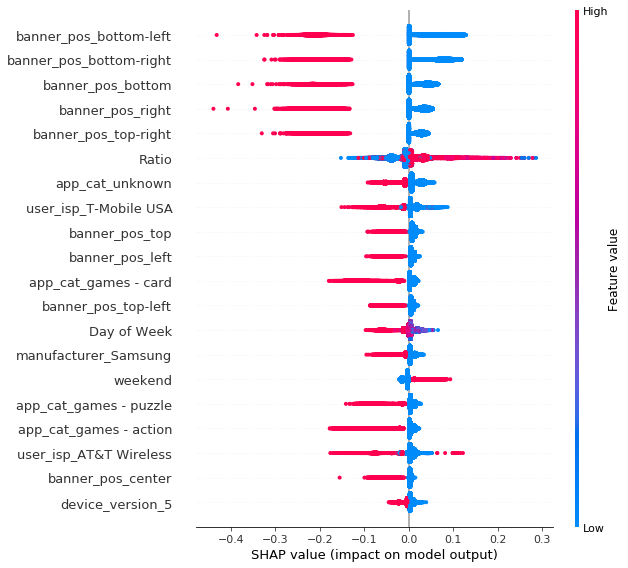

In [104]:
shap.summary_plot(shap_values_XGB_test, x_val_xgb)

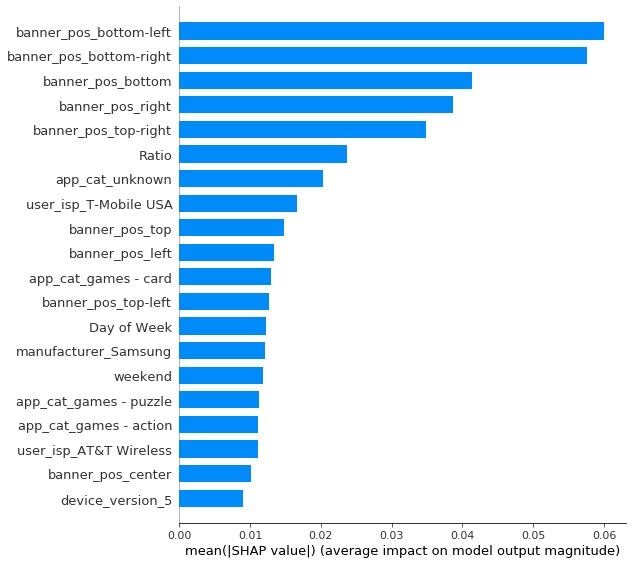

In [105]:
shap.summary_plot(shap_values_XGB_test, x_val_xgb, plot_type="bar")

In [106]:
#create 3 random numbers to have a force plot on
values = np.random.uniform(low=1, high=len(shap_values_XGB_test), size=(3,)).astype('int64')
print(values)

[33895  3190 49097]


In [107]:
shap.force_plot(explainerXGB.expected_value,shap_values_XGB_test[values[0],:], x_val_xgb.iloc[values[0],:],link='logit')

In [108]:
#Explain:

In [109]:
shap.force_plot(explainerXGB.expected_value,shap_values_XGB_test[values[1],:], x_val_xgb.iloc[values[1],:],link='logit')

In [110]:
#Explain:

In [111]:
shap.force_plot(explainerXGB.expected_value,shap_values_XGB_test[values[2],:], x_val_xgb.iloc[values[2],:],link='logit')

# 8. Inference

In [112]:
# df = df.reset_index()
# df.drop(df.index, inplace=True)

In [113]:
train_df = pd.read_csv('ctr_dataset_train.csv')
train_df = pd.DataFrame(train_df)
train_df['train_test'] = 'train'

In [114]:
test_df = pd.read_csv('ctr_dataset_test.csv')
test_df = pd.DataFrame(test_df)
test_df['clicked'] = np.nan
test_df['train_test'] = 'test'

In [115]:
df = pd.concat([train_df, test_df]).reset_index()

In [116]:
df['clicked'] =le.fit_transform(df['clicked'])
df['clicked'] = df['clicked'].astype('int32')

In [117]:
df.loc[df['device_version']=="P", 'device_version'] = '999'
df.loc[df['device_version']=="O", 'device_version'] = '999'
df['device_version'] =le.fit_transform(df['device_version'])
df['device_version'] = df['device_version'].astype('category')

In [118]:
#Nominal columns:
df['banner_pos'] = df['banner_pos'].astype('category')
df['state'] = df['state'].astype('category')

#convert to datetime(late split to weekend, holidays, hours of the day etc.)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')#Should be 2 months we see 4

In [119]:
df.drop(['resolution'], axis=1, inplace=True)#removing this column as it has one unique value therfor has 0 cardinality and will not provide any information
df.drop(['op_id'], axis=1, inplace=True)#removing this as is had too high cardinality and provides no additional informatio - one per row
#df.drop(['app_id'], axis=1, inplace=True)

In [120]:
def MissingData(df):
    df['user_isp'].fillna(df['user_isp'].value_counts().index[0], inplace=True)#Fill na in user isp with most common value - only ~30 missing. 
    df['device_model'].fillna('Unknown', inplace=True)
    df['manufacturer'].fillna('Unknown', inplace=True)
    return df

In [121]:
df["combined"] = df["device_version"].astype(str).str.cat(df[['device_height','device_width']].astype(str), sep="_")
countman = df.groupby('combined')['manufacturer'].nunique()
c = countman[countman ==1]
df_c  = pd.DataFrame(c.keys())
df_c.head()
df_c = pd.merge(df_c, df[['combined','manufacturer']], on='combined' ,how='left')
df_c = df_c.drop_duplicates(subset=['combined','manufacturer'], keep='last')
df_c = df_c[df_c['manufacturer'].isnull()==False]
df[['manufacturer','combined']][df['manufacturer'].isnull()][df['combined'].isin(df_c['combined'])].count()
df = pd.merge(df, df_c, on='combined' ,how='left')
df['manufacturer_x'] = np.where(df['manufacturer_x'].isnull(), df['manufacturer_y'], df['manufacturer_x'])
df['manufacturer_x'][df['manufacturer_x'].isnull()==True].count()
df.drop(['manufacturer_y'], axis=1, inplace=True)
df=df.rename(columns={"manufacturer_x": "manufacturer"})

In [122]:
df = MissingData(df)

In [123]:
x = df['manufacturer'][df['manufacturer'].notna()==True].value_counts().sort_values(ascending=False)
x = x[df['manufacturer'][df['manufacturer'].notna()==True].value_counts()<1000]
#locate the values in the combine list and change them to longTail
df.loc[df['manufacturer'].isin(x.keys()) , "manufacturer"] = 'LongTail'
df['manufacturer'][df['manufacturer'] =='LongTail']
df['manufacturer'] = df['manufacturer'].astype('category')

In [124]:
x = df['app_cat'][df['app_cat'].notna()].value_counts().sort_values(ascending=False)
x = x[df['app_cat'][df['app_cat'].notna()].value_counts()<3000]
#locate the values in the combine list and change them to longTail
df.loc[df['app_cat'].isin(x.keys()) , "app_cat"] = 'LongTail'
df['app_cat'][df['app_cat'] =='LongTail']
df['app_cat'] = df['app_cat'].astype('category')

In [125]:
x = df['user_isp'][df['user_isp'].notna()==True].value_counts().sort_values(ascending=False)
x = x[df['user_isp'][df['user_isp'].notna()==True].value_counts()<6000]
#locate the values in the combine list and change them to LongTail
df.loc[df['user_isp'].isin(x.keys()) , "user_isp"] = 'LongTail'
df['user_isp'][df['user_isp'] =='LongTail']
df['user_isp'] = df['user_isp'].astype('category')

In [126]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%d/%m/%Y %H:%M:%S')
df['Day of Week']=df['timestamp'].dt.dayofweek

In [127]:
df['weekend'] = np.where(df['Day of Week'].isin(['6','7']), 1, 0).astype('int32')

In [128]:
df['month'] = df['timestamp'].dt.month

In [129]:
df['Ratio'] = df['device_height'] / df['device_width']

In [130]:
#upload data
df_states_Region = pd.read_csv('UsStateToRegion.csv')
df_states_Region = pd.DataFrame(df_states_Region)
df_states_Region=df_states_Region.rename(columns={"State": "state"})
x = pd.merge(df, df_states_Region[['state','Region','Division']], how='left', on='state' )
df['Region'] = x['Region']
df['Division'] = x['Division']

In [131]:
df.drop(['combined'], axis=1, inplace=True)
df.drop(['app_id'], axis=1, inplace=True)
df.drop(['timestamp'], axis=1, inplace=True)
df.drop(['device_model'], axis=1, inplace=True)
df.drop(['device_height'], axis=1, inplace=True)
df.drop(['device_width'], axis=1, inplace=True)

In [132]:
cat_feat_list = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_version', 'Region', 'Division']
num_feat_list = ['Day of Week', 'weekend', 'month', 'Ratio']

In [133]:
for feat in cat_feat_list:
    feat_df = feat+'_df'
    feat_df = GetOneHotEnc(df, feat)
    df = pd.merge(df, feat_df, how = 'left', left_index = True, right_index = True)
    df.drop([feat], axis=1, inplace=True)

In [134]:
for feat in num_feat_list:
    df[feat] = NormalizingFromZeroToOne(df[feat])

In [135]:
x_train_final = df[df['train_test'] == 'train'].reset_index(drop=True)
y_train_final = x_train_final.pop('clicked')
x_train_final.drop(['train_test'], axis=1, inplace=True)

In [136]:
x_test_final = df[df['train_test'] == 'test'].reset_index(drop=True)
x_test_final.drop(['train_test'], axis=1, inplace=True)
x_test_final.drop(['clicked'], axis=1, inplace=True)

In [137]:
x_train_final.dtypes

index                                                    int64
Day of Week                                            float16
weekend                                                float16
month                                                  float16
Ratio                                                  float16
state_Alabama                                            int16
state_Alaska                                             int16
state_Arizona                                            int16
state_Arkansas                                           int16
state_California                                         int16
state_Colorado                                           int16
state_Connecticut                                        int16
state_Delaware                                           int16
state_District of Columbia                               int16
state_Florida                                            int16
state_Georgia                                          

In [138]:
# SMOTE
sm = SMOTE(random_state=42, sampling_strategy=0.2)
x_train_final_resmp, y_train_final_resmp = sm.fit_resample(x_train_final, y_train_final)
# x_train_final_resmp = x_train_final
# y_train_final_resmp = y_train_final

In [139]:
pprint.pprint(best_xgb_model)

{'accuracy': 0.8340392156862745,
 'auc': 0.7287718244766394,
 'boosting': 'gbtree',
 'f1': 0.3343818810946839,
 'f1_weighted': 0.8659827225391126,
 'learning_rate': 0.1632972863901326,
 'max_depth': 6,
 'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1632972863901326, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=214, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.8033674434562963,
              scale_pos_weight=5.000052616347899, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1),
 'n_estimators': 214,
 'objective': 'binary:logistic',
 'precision': 0.23078593139383413,
 'precision_weighted': 0.9164401381219319,
 'recall': 0.6067351

In [140]:
 best_xgb_model_aaa= {'accuracy': 0.8582647058823529,
 'auc': 0.6918710666691746,
 'boosting': 'gbtree',
 'f1': 0.3262966587445827,
 'f1_weighted': 0.8799029282543018,
 'learning_rate': 0.1632972863901326,
 'max_depth': 6,
 'n_estimators': 214,
 'objective': 'binary:logistic',
 'precision': 0.24241794765267968,
 'precision_weighted': 0.9104890849208797,
 'recall': 0.4989311671654553,
 'recall_weighted': 0.8582647058823529,
 'reg_lambda': 0.8033674434562963}

In [141]:
pprint.pprint(best_ann_model)

{'# of layers': 3,
 '# of units per layer': 115,
 'Activation function': 'tanh',
 'Dropout': 0.07891923161534266,
 'Optimizer': 'Adadelta',
 'accuracy': 0.8955588235294117,
 'auc': 0.5895476055058965,
 'f1': 0.23617982361798237,
 'f1_weighted': 0.8952569815537927,
 'precision': 0.23766233766233766,
 'precision_weighted': 0.8949567724694513,
 'recall': 0.23471569046601112,
 'recall_weighted': 0.8955588235294117}


In [142]:
pprint.pprint(best_lgbm_model)

{'accuracy': 0.8390117647058823,
 'auc': 0.7088834060192376,
 'boosting': 'dart',
 'f1': 0.32015103338632755,
 'f1_weighted': 0.8687367182603136,
 'learning_rate': 0.0725834727902253,
 'max_depth': 23,
 'metric': 'auc',
 'n_estimators': 653,
 'num_leaves': 50,
 'precision': 0.22442014348401476,
 'precision_weighted': 0.9137096634334414,
 'recall': 0.5583087853058395,
 'recall_weighted': 0.8390117647058823}


In [143]:
scale_pos_weight = len(y_train_final_resmp[y_train_final_resmp == 0])/len(y_train_final_resmp[y_train_final_resmp == 1])
parameters = {
     'scale_pos_weight': scale_pos_weight,
     'objective':best_xgb_model['objective'],
     'booster': best_xgb_model['boosting'],
     'n_estimators': best_xgb_model['n_estimators'], 
     'max_depth': best_xgb_model['max_depth'], 
     'learning_rate': best_xgb_model['learning_rate'],  
     'reg_lambda': best_xgb_model['reg_lambda'],
     'verbosity': 1}

In [144]:
xgb_model = xgb.XGBClassifier(**parameters, random_state = RANDOM_STATE)
xgb_model.fit(x_train_final_resmp, y_train_final_resmp, eval_metric=["error", "logloss"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1632972863901326, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=214, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.8033674434562963,
              scale_pos_weight=5.000006387069166, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [145]:
threshold = 0.5
predicted_proba = xgb_model.predict_proba(x_test_final)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

In [146]:
with open('output_14.txt', 'w') as f:
    for item in predicted:
        f.write("%s\n" % item)

# 9. Bonus

בעיה שעלולה לצוץ היא העובדה שטכנולוגיות משתנות, גדלי הטלפון מי שמייצר אותם והגירסאות שלהם אלה נתונים שעם הזמן כבר לא יהיו רלוונטיים. 
יתכן בכלל שהשימוש בטלפון כבר יפסיק להיות רלוונטי בשלב מסוים. המודל כבר לא יפיק תחזיות בעלות ערך כשהעולם האמיתי כבר מחזיק בבסיס שונה לחלוטין.
בעיקר בעולם הפירסום שבו יש צורך בעדכון בקצב מאוד גבוהה של המודלים מכיוון שהטרנדים משתנים מאוד מהר. 
